In [ ]:
pip install gradio pdfplumber spacy pandas xlsxwriter

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 42.8/42.8 kB 1.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 48.2/48.2 kB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.2/54.2 MB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 323.3/323.3 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.2/60.2 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 34.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 169.4/169.4 kB 9.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.2/95.2 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.9/2.9 MB 34.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.5/11.5 MB 53.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.5/62.5 kB 4.2 MB/s eta 0:00:00


In [ ]:
import pdfplumber
import spacy
import re
import pandas as pd
import tempfile
import os
from io import BytesIO

# Load the SpaCy model
try:
    nlp = spacy.load("en_core_web_sm")
except OSError:
    print("SpaCy model not found. Please download it using: python -m spacy download en_core_web_sm")
    nlp = spacy.blank("en")

# Add scientific entity patterns
try:
    ruler = nlp.add_pipe("entity_ruler")
    patterns = [
        {"label": "SPECIES", "pattern": [{"LOWER": {"REGEX": "[a-z]+"}}], "id": "scientific_species"},
        {"label": "MEASUREMENT", "pattern": [{"SHAPE": "d+.d+"}, {"LOWER": {"IN": ["mm", "cm", "m", "kg", "g"]}}]},
        {"label": "LENGTH", "pattern": [{"LOWER": "fork"}, {"LOWER": "length"}]},
    ]
    ruler.add_patterns(patterns)
except Exception as e:
    print(f"Error setting up entity ruler: {e}")
    if "entity_ruler" not in nlp.pipe_names:
        ruler = nlp.add_pipe("entity_ruler", name="entity_ruler")

# Function to extract text from PDF with better error handling
def extract_text_from_pdf(pdf_path):
    if not pdf_path:
        return "No file provided."

    try:
        text = ""
        with pdfplumber.open(pdf_path) as pdf:
            for page in pdf.pages:
                extracted_text = page.extract_text()
                if extracted_text:
                    text += extracted_text + "\n"

        if not text.strip():
            return "No text could be extracted from the PDF."

        return text
    except Exception as e:
        return f"Error processing PDF: {str(e)}"

# Function to extract entities with better error handling
def extract_entities(text, entity_types):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Limit text size to avoid memory issues
            text = text[:100000]  # Limit to first 100k characters
            doc = nlp(text)

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Extract required entity types
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    extracted[ent.label_].append(ent.text)

            # Special case for scientific species names
            if "SPECIES" in entity_types:
                scientific_names = re.findall(r'[A-Z][a-z]+ [a-z]+', text)
                extracted["SPECIES"].extend(scientific_names)

            # Special case for measurements
            if "MEASUREMENT" in entity_types:
                measurements = re.findall(r'\d+\.?\d*\s*(?:mm|cm|m|kg|g)', text)
                extracted["MEASUREMENT"].extend(measurements)

            # Special case for fork length
            if "LENGTH" in entity_types:
                fork_lengths = re.findall(r'(?:fork|total)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
                extracted["LENGTH"].extend(fork_lengths)

            # Remove duplicates
            for entity_type in entity_types:
                extracted[entity_type] = list(set(extracted[entity_type]))

            return extracted
        except Exception as e:
            return f"Error extracting entities: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

# Main function for processing PDFs
def process_pdf(pdf_path, entity_types):
    if not pdf_path:
        return "Please provide a PDF file path."

    if not entity_types:
        return "Please specify at least one entity type to extract."

    try:
        # Extract text from PDF
        text = extract_text_from_pdf(pdf_path)

        print(f"Extracted text length: {len(text) if isinstance(text, str) else 'Not a string'}")

        if isinstance(text, str) and text.startswith("Error"):
            return text, None

        # Extract entities
        extracted = extract_entities(text, entity_types)

        if isinstance(extracted, str) and extracted.startswith("Error"):
            return extracted, None

        # Prepare results
        result_text = "## Extracted Entities\n\n"

        try:
            # Create Excel file with multiple sheets
            output_file = "extracted_entities.xlsx"
            with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
                for entity_type in entity_types:
                    if extracted[entity_type]:
                        result_text += f"### {entity_type}\n"
                        for item in extracted[entity_type]:
                            result_text += f"- {item}\n"
                        result_text += "\n"

                        # Add sheet to Excel file
                        df = pd.DataFrame({entity_type: extracted[entity_type]})
                        df.to_excel(writer, sheet_name=entity_type[:31], index=False)
                    else:
                        result_text += f"### {entity_type}\n"
                        result_text += "No entities of this type found.\n\n"

            print(result_text)
            print(f"Results saved to {output_file}")
            return result_text, output_file
        except Exception as e:
            return f"Error creating Excel file: {str(e)}", None
    except Exception as e:
        return f"Unexpected error: {str(e)}", None

# Example usage
if __name__ == "__main__":
    # Define the path to your PDF file
    pdf_path = input("Enter the path to your PDF file: ")

    # Define entity types to extract
    print("\nSelect entity types to extract (enter y/n):")
    entity_types = []

    if input("Species Names (y/n): ").lower() == 'y':
        entity_types.append("SPECIES")
    if input("Measurements (y/n): ").lower() == 'y':
        entity_types.append("MEASUREMENT")
    if input("Length Measurements (y/n): ").lower() == 'y':
        entity_types.append("LENGTH")
    if input("Person Names (y/n): ").lower() == 'y':
        entity_types.append("PERSON")
    if input("Organizations (y/n): ").lower() == 'y':
        entity_types.append("ORG")
    if input("Dates (y/n): ").lower() == 'y':
        entity_types.append("DATE")
    if input("Geopolitical Entities (y/n): ").lower() == 'y':
        entity_types.append("GPE")
    if input("Locations (y/n): ").lower() == 'y':
        entity_types.append("LOC")

    # Process the PDF
    result, output_file = process_pdf(pdf_path, entity_types)

    # Display the result
    print("\nResult:")
    print(result)


Enter the path to your PDF file: /content/sek1_animals.pdf

Select entity types to extract (enter y/n):
Species Names (y/n): Y
Measurements (y/n): 
Length Measurements (y/n): 
Person Names (y/n): 
Organizations (y/n): 
Dates (y/n): 
Geopolitical Entities (y/n): 
Locations (y/n): 
Extracted text length: 31138
## Extracted Entities

### SPECIES
- n
- memory
- whiskers
- eye
- king
- Frogs and
- salt
- cold
- turn
- crabs
- sentences
- blood
- Look and
- watch
- meets
- Correct
- Singular
- If
- ee
- mit
- Children´s
- Tiger and
- save
- J
- should
- oh
- x
- c.
- Hippos are
- penguins
- terrib
- My
- The
- Find
- except
- You need
- mammal
- if
- seat
- MN
- favourite
- games
- Campbell books
- toads
- vocabulary
- farm
- print
- salmon
- cages
- to
- ear
- record
- that
- duck
- Ten little
- harmless
- If the
- and
- feathers
- All
- Yes
- play
- acrostic
- eggs
- Was
- dir
- Write and
- Africa in
- GO
- with
- Lions eat
- i
- Sing with
- You are
- LOOK
- animal´s
- In this
- Match the


In [ ]:
!pip install spacy
!python -m spacy download en_core_web_sm
!python -m spacy download en_core_web_md
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_trf

In [ ]:
import pdfplumber
import spacy
import re
import pandas as pd
import tempfile
import os
from io import BytesIO
import logging
import time
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Dictionary to store loaded models
nlp_models = {}

# Available NLP models
AVAILABLE_MODELS = {
    "SpaCy Small": "en_core_web_sm",
    "SpaCy Large": "en_core_web_lg",
}

# Function to load NLP model
def load_nlp_model(model_name):
    if model_name in nlp_models:
        return nlp_models[model_name]

    model_path = AVAILABLE_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown model: {model_name}")
        return None

    try:
        logger.info(f"Loading model: {model_name} ({model_path})")
        nlp = spacy.load(model_path)

        # Add animal entity patterns
        if "entity_ruler" not in nlp.pipe_names:
            ruler = nlp.add_pipe("entity_ruler", before="ner")
            patterns = [
                # Improved SPECIES pattern for scientific names (Genus species)
                {"label": "SPECIES", "pattern": [
                    {"TEXT": {"REGEX": "^[A-Z][a-z]+$"}},  # Genus - capitalized word
                    {"TEXT": {"REGEX": "^[a-z]+$"}}        # species - lowercase word
                ]},
                # Common animal names pattern
                {"label": "SPECIES", "pattern": [
                    {"LOWER": {"IN": ["dog", "cat", "horse", "cow", "pig", "sheep", "goat", "chicken",
                                    "fish", "bird", "elephant", "lion", "tiger", "bear", "wolf",
                                    "fox", "deer", "rabbit", "rat", "mouse", "cattle", "poultry"]}}
                ]},
                # Animal names with adjectives
                {"label": "SPECIES", "pattern": [
                    {"LOWER": {"IN": ["domestic", "farm", "wild", "laboratory", "companion", "pet"]}},
                    {"LOWER": {"IN": ["animal", "animals", "species"]}}
                ]},
                {"label": "ANIMAL_GROUP", "pattern": [
                    {"LOWER": {"IN": ["herd", "flock", "pack", "pod", "school", "colony", "pride", "swarm", "murder"]}}
                ]},
                {"label": "ANIMAL_BODY_PART", "pattern": [
                    {"LOWER": {"IN": ["paw", "claw", "hoof", "beak", "wing", "fin", "tail", "horn", "tusk", "scale",
                                    "feather", "fur", "mane", "whisker", "snout", "bill"]}}
                ]},
                {"label": "MEASUREMENT", "pattern": [
                    {"SHAPE": {"IN": ["d+", "d+.d+"]}},
                    {"LOWER": {"IN": ["mm", "cm", "m", "kg", "g", "ml", "l"]}}
                ]},
                {"label": "LENGTH", "pattern": [
                    {"LOWER": {"IN": ["fork", "total", "standard", "body", "tail"]}},
                    {"LOWER": "length"}
                ]},
                {"label": "HABITAT", "pattern": [
                    {"LOWER": {"IN": ["forest", "jungle", "savanna", "ocean", "lake", "river", "mountain",
                                    "desert", "tundra", "reef", "farm", "pasture", "pen", "enclosure", "cage"]}}
                ]},
            ]
            ruler.add_patterns(patterns)

        nlp_models[model_name] = nlp
        logger.info(f"Model {model_name} loaded successfully")
        return nlp
    except OSError as e:
        logger.warning(f"Error loading SpaCy model {model_path}: {str(e)}")
        logger.warning(f"Please download it using: python -m spacy download {model_path}")

        # Create a blank model as fallback
        nlp = spacy.blank("en")
        nlp_models[model_name] = nlp
        return nlp

# Check which models are installed
def get_available_models():
    installed_models = []
    for name, path in AVAILABLE_MODELS.items():
        try:
            spacy.load(path)
            installed_models.append(name)
        except OSError:
            pass

    # Ensure at least one model is available
    if not installed_models:
        try:
            spacy.load("en_core_web_sm")
            installed_models.append("SpaCy Small")
        except OSError:
            installed_models.append("Blank Model")
            logger.warning("No SpaCy models installed. Please run: python -m spacy download en_core_web_sm")

    return installed_models

# Function to extract text from PDF with better error handling
def extract_text_from_pdf(pdf_file):
    if not pdf_file or not os.path.exists(pdf_file):
        return "No file provided or file does not exist."

    try:
        text = ""
        with pdfplumber.open(pdf_file) as pdf:
            total_pages = len(pdf.pages)
            logger.info(f"Processing PDF with {total_pages} pages")

            for i, page in enumerate(pdf.pages):
                logger.info(f"Extracting text from page {i+1}/{total_pages}")
                extracted_text = page.extract_text()
                if extracted_text:
                    text += extracted_text + "\n"

        if not text.strip():
            return "No text could be extracted from the PDF."

        logger.info(f"Successfully extracted {len(text)} characters of text")
        return text
    except Exception as e:
        logger.error(f"Error processing PDF: {str(e)}", exc_info=True)
        return f"Error processing PDF: {str(e)}"

# Function to extract entities with better error handling and performance
def extract_entities(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Get the specified model
            nlp = nlp_models.get(model_name)
            if nlp is None:
                nlp = load_nlp_model(model_name)
                if nlp is None:
                    return f"Could not load NLP model: {model_name}"

            # Limit text size to avoid memory issues
            if len(text) > 100000:
                logger.warning(f"Text is very large ({len(text)} chars). Limiting to first 100k characters.")
                text = text[:100000]  # Limit to first 100k characters

            logger.info(f"Processing text with {model_name} ({len(text)} chars)")
            doc = nlp(text)

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Extract required entity types
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    extracted[ent.label_].append(ent.text)

            # Special case for animal scientific species names
            if "SPECIES" in entity_types:
                logger.info("Extracting scientific species names with regex")

                # Additional check for common animal names (with capitalized nouns)
                common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
                extracted["SPECIES"].extend(common_animals)

            # Special case for animal groups
            if "ANIMAL_GROUP" in entity_types:
                logger.info("Extracting animal group terms with regex")
                groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder)\s+of\s+\w+\b', text, re.IGNORECASE)
                extracted["ANIMAL_GROUP"].extend(groups)

            # Special case for body parts
            if "ANIMAL_BODY_PART" in entity_types:
                logger.info("Extracting animal body parts with regex")
                body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|beak|bill)\b', text, re.IGNORECASE)
                extracted["ANIMAL_BODY_PART"].extend(body_parts)

            # Special case for habitats
            if "HABITAT" in entity_types:
                logger.info("Extracting habitat terms with regex")
                habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|wetland|marsh|grassland|meadow)\b', text, re.IGNORECASE)
                extracted["HABITAT"].extend(habitats)

            # Special case for measurements - improved regex
            if "MEASUREMENT" in entity_types:
                logger.info("Extracting measurements with regex")
                measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
                extracted["MEASUREMENT"].extend(measurements)

            # Special case for length measurements
            if "LENGTH" in entity_types:
                logger.info("Extracting length measurements with regex")
                length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
                extracted["LENGTH"].extend(length_patterns)

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set(extracted[entity_type])))
                logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with {model_name}")

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with {model_name}: {str(e)}", exc_info=True)
            return f"Error extracting entities with {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

# Function to create Excel file with comparison
def create_comparison_excel(extracted_by_model, entity_types, models, output_path=None):
    try:
        # Create a temporary file if no output path is provided
        if output_path is None:
            temp_dir = tempfile.mkdtemp()
            output_file = os.path.join(temp_dir, "animal_entity_extraction_comparison.xlsx")
        else:
            output_file = output_path

        logger.info(f"Creating comparison Excel file at {output_file}")
        with pd.ExcelWriter(output_file, engine='xlsxwriter') as writer:
            # Add summary sheet
            summary_data = []
            for entity_type in entity_types:
                for model in models:
                    if model in extracted_by_model:
                        count = len(extracted_by_model[model].get(entity_type, []))
                        summary_data.append({
                            'Model': model,
                            'Entity Type': entity_type,
                            'Count': count
                        })

            summary_df = pd.DataFrame(summary_data)
            summary_df.to_excel(writer, sheet_name='Summary', index=False)

            # Create comparison workbook
            workbook = writer.book

            # Add chart sheet
            chart_sheet = workbook.add_worksheet('Comparison Chart')

            # Create a chart for each entity type
            for i, entity_type in enumerate(entity_types):
                chart_data = []
                for model in models:
                    if model in extracted_by_model:
                        count = len(extracted_by_model[model].get(entity_type, []))
                        chart_data.append({
                            'Model': model,
                            'Count': count
                        })

                # Create chart data
                chart_df = pd.DataFrame(chart_data)
                chart_df.to_excel(writer, sheet_name=f'Chart_{entity_type[:20]}', index=False)

                # Add chart
                chart = workbook.add_chart({'type': 'column'})
                chart.add_series({
                    'name': entity_type,
                    'categories': f'=Chart_{entity_type[:20]}!$A$2:$A${len(models)+1}',
                    'values': f'=Chart_{entity_type[:20]}!$B$2:$B${len(models)+1}',
                })

                chart.set_title({'name': f'{entity_type} Count by Model'})
                chart.set_x_axis({'name': 'Model'})
                chart.set_y_axis({'name': 'Count'})

                # Position charts in a grid
                row = (i // 2) * 15
                col = (i % 2) * 8
                chart_sheet.insert_chart(row, col, chart)

            # Add individual sheets for each entity type and model
            for model in models:
                if model in extracted_by_model:
                    for entity_type in entity_types:
                        if extracted_by_model[model].get(entity_type, []):
                            # Sanitize sheet name (Excel has a 31 character limit)
                            sheet_name = f"{model[:15]}_{entity_type[:15]}"
                            df = pd.DataFrame({entity_type: extracted_by_model[model].get(entity_type, [])})
                            df.to_excel(writer, sheet_name=sheet_name, index=False)

            # Add unique/shared entities analysis
            if len(models) > 1:
                for entity_type in entity_types:
                    all_entities = set()
                    for model in models:
                        if model in extracted_by_model:
                            all_entities.update(extracted_by_model[model].get(entity_type, []))

                    comparison_data = []
                    for entity in all_entities:
                        row = {'Entity': entity}
                        for model in models:
                            if model in extracted_by_model:
                                row[model] = entity in extracted_by_model[model].get(entity_type, [])
                        comparison_data.append(row)

                    if comparison_data:
                        sheet_name = f"Comp_{entity_type[:20]}"
                        comp_df = pd.DataFrame(comparison_data)
                        comp_df.to_excel(writer, sheet_name=sheet_name, index=False)

        return output_file
    except Exception as e:
        logger.error(f"Error creating Excel file: {str(e)}", exc_info=True)
        return None

# Function to generate comparison visualization
def generate_comparison_chart(extracted_by_model, entity_types, models, output_path=None):
    try:
        if output_path is None:
            temp_dir = tempfile.mkdtemp()
            chart_file = os.path.join(temp_dir, "animal_comparison_chart.png")
        else:
            chart_file = output_path

        # Set up the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Prepare data
        x = np.arange(len(entity_types))
        width = 0.8 / len(models)

        # Plot bars for each model
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                ax.bar(x + offset, counts, width, label=model)

        # Add labels and title
        ax.set_ylabel('Number of Entities')
        ax.set_title('Animal Entity Extraction Comparison by Model')
        ax.set_xticks(x)
        ax.set_xticklabels(entity_types)
        ax.legend()

        # Save the figure
        plt.tight_layout()
        plt.savefig(chart_file)
        plt.close()

        return chart_file
    except Exception as e:
        logger.error(f"Error creating comparison chart: {str(e)}", exc_info=True)
        return None

# Main function for processing PDFs with multiple models
def process_pdf_multi_model(pdf_path, entity_types, selected_models, output_dir=None):
    if not pdf_path or not os.path.exists(pdf_path):
        return "Please provide a valid PDF file path.", None, None, None

    if not entity_types:
        return "Please specify at least one entity type to extract.", None, None, None

    if not selected_models:
        return "Please specify at least one NLP model.", None, None, None

    try:
        start_time = time.time()

        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Extract text from PDF
        text = extract_text_from_pdf(pdf_path)
        text_extraction_time = time.time() - start_time
        logger.info(f"Text extraction completed in {text_extraction_time:.2f} seconds")

        if isinstance(text, str) and text.startswith("Error"):
            return text, None, None, None

        # Extract entities using each selected model
        extracted_by_model = {}
        entity_extraction_times = {}

        for model_name in selected_models:
            model_start_time = time.time()
            extracted = extract_entities(text, entity_types, model_name)
            extraction_time = time.time() - model_start_time

            if isinstance(extracted, str) and extracted.startswith("Error"):
                extracted_by_model[model_name] = {"ERROR": [extracted]}
            else:
                extracted_by_model[model_name] = extracted

            entity_extraction_times[model_name] = extraction_time
            logger.info(f"Entity extraction with {model_name} completed in {extraction_time:.2f} seconds")

        # Prepare comparison results
        result_text = "## Animal Entity Extraction Comparison\n\n"
        result_text += "### Summary\n"

        # Add summary table to the result text
        result_text += "| Entity Type | " + " | ".join(selected_models) + " |\n"
        result_text += "|" + "---|" * (len(selected_models) + 1) + "\n"

        for entity_type in entity_types:
            result_text += f"| {entity_type} |"
            for model_name in selected_models:
                if model_name in extracted_by_model and entity_type in extracted_by_model[model_name]:
                    count = len(extracted_by_model[model_name][entity_type])
                    result_text += f" {count} |"
                else:
                    result_text += " 0 |"
            result_text += "\n"

        result_text += "\n### Processing Times\n"
        result_text += "| Model | Time (seconds) |\n"
        result_text += "|---|---|\n"
        for model_name, time_taken in entity_extraction_times.items():
            result_text += f"| {model_name} | {time_taken:.2f} |\n"

        # Add detailed results for each model
        for model_name in selected_models:
            result_text += f"\n## Results from {model_name}\n\n"

            if model_name in extracted_by_model:
                if "ERROR" in extracted_by_model[model_name]:
                    result_text += f"Error: {extracted_by_model[model_name]['ERROR'][0]}\n\n"
                    continue

                for entity_type in entity_types:
                    entities = extracted_by_model[model_name].get(entity_type, [])
                    if entities:
                        result_text += f"### {entity_type} ({len(entities)} found)\n"
                        # Show only the first 20 items to keep it manageable
                        for item in entities[:20]:
                            result_text += f"- {item}\n"
                        if len(entities) > 20:
                            result_text += f"- ... and {len(entities) - 20} more (see Excel file for complete list)\n"
                        result_text += "\n"
                    else:
                        result_text += f"### {entity_type}\n"
                        result_text += "No entities of this type found.\n\n"
            else:
                result_text += "No results available.\n\n"

        # Find unique entities
        if len(selected_models) > 1:
            result_text += "\n## Unique and Common Entities\n\n"

            for entity_type in entity_types:
                result_text += f"### {entity_type}\n"

                # Count entities per model
                entity_counts = Counter()
                all_entities = set()

                for model_name in selected_models:
                    if model_name in extracted_by_model and entity_type in extracted_by_model[model_name]:
                        entities = set(extracted_by_model[model_name][entity_type])
                        all_entities.update(entities)
                        entity_counts.update(entities)

                # Find common entities (present in all models)
                common_entities = [entity for entity, count in entity_counts.items()
                                  if count == len(selected_models)]

                # Find unique entities (present in only one model)
                unique_by_model = {}
                for model_name in selected_models:
                    if model_name in extracted_by_model and entity_type in extracted_by_model[model_name]:
                        model_entities = set(extracted_by_model[model_name][entity_type])
                        unique_entities = [entity for entity in model_entities
                                          if entity_counts[entity] == 1]
                        if unique_entities:
                            unique_by_model[model_name] = unique_entities

                # Report common entities
                if common_entities:
                    result_text += f"- **Common across all models**: {len(common_entities)} entities\n"
                    if len(common_entities) <= 5:
                        for entity in common_entities:
                            result_text += f"  - {entity}\n"
                    else:
                        for entity in common_entities[:5]:
                            result_text += f"  - {entity}\n"
                        result_text += f"  - ... and {len(common_entities) - 5} more\n"
                else:
                    result_text += "- No common entities found across all models\n"

                # Report unique entities by model
                for model_name, unique_entities in unique_by_model.items():
                    result_text += f"- **Unique to {model_name}**: {len(unique_entities)} entities\n"
                    if len(unique_entities) <= 3:
                        for entity in unique_entities:
                            result_text += f"  - {entity}\n"
                    else:
                        for entity in list(unique_entities)[:3]:
                            result_text += f"  - {entity}\n"
                        result_text += f"  - ... and {len(unique_entities) - 3} more\n"

                result_text += "\n"

        # Create Excel file
        excel_output_path = None
        if output_dir:
            excel_output_path = os.path.join(output_dir, "animal_entity_extraction_comparison.xlsx")

        excel_start_time = time.time()
        output_file = create_comparison_excel(extracted_by_model, entity_types, selected_models, excel_output_path)
        excel_creation_time = time.time() - excel_start_time
        logger.info(f"Excel file creation completed in {excel_creation_time:.2f} seconds")

        # Create comparison chart
        chart_output_path = None
        if output_dir:
            chart_output_path = os.path.join(output_dir, "animal_entity_comparison_chart.png")

        chart_file = generate_comparison_chart(extracted_by_model, entity_types, selected_models, chart_output_path)

        total_time = time.time() - start_time
        result_text += f"\nProcessing completed in {total_time:.2f} seconds."

        # Provide a sample of the extracted text for reference
        text_sample = text[:500] + "..." if len(text) > 500 else text

        if output_file:
            logger.info(f"Results saved to {output_file}")
            return result_text, output_file, text_sample, chart_file
        else:
            return result_text + "\nFailed to create Excel file.", None, text_sample, None
    except Exception as e:
        logger.error(f"Unexpected error: {str(e)}", exc_info=True)
        return f"Unexpected error: {str(e)}", None, None, None

# Install missing models helper function
def install_model_message():
    print("\nTo install SpaCy models, use the following commands:")
    print("python -m spacy download en_core_web_sm  # Small model (fastest)")
    print("python -m spacy download en_core_web_md  # Medium model")
    print("python -m spacy download en_core_web_lg  # Large model (most accurate)")
    print("python -m spacy download en_core_web_trf  # Transformer model (most accurate but slowest)")

# Example usage
def main():
    # Print available models
    available_models = get_available_models()
    print(f"Available NLP models: {', '.join(available_models)}")

    if len(available_models) < 2:
        print("Only one model is available. For comparison, install additional models.")
        install_model_message()

    # Example usage
    pdf_path = input("Enter the path to your PDF file: ")
    if not os.path.exists(pdf_path):
        print("File not found!")
        return

    # Define animal-specific entity types
    entity_types = ["SPECIES", "ANIMAL_GROUP", "ANIMAL_BODY_PART", "MEASUREMENT", "LENGTH", "HABITAT"]

    # Let user select models
    print("\nAvailable models:")
    for i, model in enumerate(available_models):
        print(f"{i+1}. {model}")

    model_indices = input("\nSelect models (comma-separated numbers, e.g., 1,2): ")
    selected_models = []
    try:
        indices = [int(idx.strip()) for idx in model_indices.split(",")]
        for idx in indices:
            if 1 <= idx <= len(available_models):
                selected_models.append(available_models[idx-1])
    except:
        print("Invalid selection. Using the first available model.")
        selected_models = [available_models[0]]

    # Define output directory
    output_dir = input("\nEnter output directory (leave blank for current directory): ")
    if not output_dir:
        output_dir = "."

    # Process the PDF
    print(f"\nProcessing {pdf_path} with models: {', '.join(selected_models)}")
    results, excel_file, text_sample, chart_file = process_pdf_multi_model(
        pdf_path, entity_types, selected_models, output_dir
    )

    # Print results
    print("\n" + results)

    if excel_file:
        print(f"\nResults saved to Excel file: {excel_file}")

    if chart_file:
        print(f"Comparison chart saved to: {chart_file}")

if __name__ == "__main__":
    main()

Available NLP models: SpaCy Small, SpaCy Large
Enter the path to your PDF file: /content/Weight_Measurement_and_Identification_of_Cow_Type_.pdf

Available models:
1. SpaCy Small
2. SpaCy Large

Select models (comma-separated numbers, e.g., 1,2): 2

Enter output directory (leave blank for current directory): 



Processing /content/Weight_Measurement_and_Identification_of_Cow_Type_.pdf with models: SpaCy Large



## Animal Entity Extraction Comparison

### Summary
| Entity Type | SpaCy Large |
|---|---|
| SPECIES | 81 |
| ANIMAL_GROUP | 0 |
| ANIMAL_BODY_PART | 2 |
| MEASUREMENT | 3 |
| LENGTH | 2 |
| HABITAT | 1 |

### Processing Times
| Model | Time (seconds) |
|---|---|
| SpaCy Large | 4.90 |

## Results from SpaCy Large

### SPECIES (81 found)
- Agriculture and
- Agriculture has
- All content
- Angus cattle
- Angus cows
- Angus type
- Another method
- Article in
- At this
- Body weight
- Brahma cows
- Brahman cow
- Calculation of
- Calculation results
- Carcass characteristics
- Characteristic features
- Computer vision
- Corresponding author
- Cow
- Cows are
- ... and 61 more (see Excel file for complete list)

### ANIMAL_GROUP
No entities of this type found.

### ANIMAL_BODY_PART (2 found)
- horn
- tail

### MEASUREMENT (3 found)
- 260 kg
- 363 kg
- 416 kg

### LENGTH (2 found)
- Body Length
- body length

### HABITAT (1 found)
- pen


Processing completed in 6.05 seconds.

Results saved

\--------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
import pdfplumber
import spacy
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import logging
import time
import os
import tempfile
from io import BytesIO

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Dictionary to store loaded models
nlp_models = {}

# Available NLP models
AVAILABLE_MODELS = {
    "SpaCy Small": "en_core_web_sm",
    "SpaCy Large": "en_core_web_lg",
}

# Function to load NLP model
def load_nlp_model(model_name):
    if model_name in nlp_models:
        return nlp_models[model_name]

    model_path = AVAILABLE_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown model: {model_name}")
        return None

    try:
        logger.info(f"Loading model: {model_name} ({model_path})")
        nlp = spacy.load(model_path)

        # Add animal entity patterns
        if "entity_ruler" not in nlp.pipe_names:
            ruler = nlp.add_pipe("entity_ruler", before="ner")
            patterns = [
                # Improved SPECIES pattern for scientific names (Genus species)
                {"label": "SPECIES", "pattern": [
                    {"TEXT": {"REGEX": "^[A-Z][a-z]+$"}},  # Genus - capitalized word
                    {"TEXT": {"REGEX": "^[a-z]+$"}}        # species - lowercase word
                ]},
                # Common animal names pattern
                {"label": "SPECIES", "pattern": [
                    {"LOWER": {"IN": ["dog", "cat", "horse", "cow", "pig", "sheep", "goat", "chicken",
                                    "fish", "bird", "elephant", "lion", "tiger", "bear", "wolf",
                                    "fox", "deer", "rabbit", "rat", "mouse", "cattle", "poultry"]}}
                ]},
                # Animal names with adjectives
                {"label": "SPECIES", "pattern": [
                    {"LOWER": {"IN": ["domestic", "farm", "wild", "laboratory", "companion", "pet"]}},
                    {"LOWER": {"IN": ["animal", "animals", "species"]}}
                ]},
                {"label": "ANIMAL_GROUP", "pattern": [
                    {"LOWER": {"IN": ["herd", "flock", "pack", "pod", "school", "colony", "pride", "swarm", "murder"]}}
                ]},
                {"label": "ANIMAL_BODY_PART", "pattern": [
                    {"LOWER": {"IN": ["paw", "claw", "hoof", "beak", "wing", "fin", "tail", "horn", "tusk", "scale",
                                    "feather", "fur", "mane", "whisker", "snout", "bill"]}}
                ]},
                {"label": "MEASUREMENT", "pattern": [
                    {"SHAPE": {"IN": ["d+", "d+.d+"]}},
                    {"LOWER": {"IN": ["mm", "cm", "m", "kg", "g", "ml", "l"]}}
                ]},
                {"label": "LENGTH", "pattern": [
                    {"LOWER": {"IN": ["fork", "total", "standard", "body", "tail"]}},
                    {"LOWER": "length"}
                ]},
                {"label": "HABITAT", "pattern": [
                    {"LOWER": {"IN": ["forest", "jungle", "savanna", "ocean", "lake", "river", "mountain",
                                    "desert", "tundra", "reef", "farm", "pasture", "pen", "enclosure", "cage"]}}
                ]},
            ]
            ruler.add_patterns(patterns)

        nlp_models[model_name] = nlp
        logger.info(f"Model {model_name} loaded successfully")
        return nlp
    except OSError as e:
        logger.warning(f"Error loading SpaCy model {model_path}: {str(e)}")
        logger.warning(f"Please download it using: python -m spacy download {model_path}")

        # Create a blank model as fallback
        nlp = spacy.blank("en")
        nlp_models[model_name] = nlp
        return nlp

# Check which models are installed
def get_available_models():
    installed_models = []
    for name, path in AVAILABLE_MODELS.items():
        try:
            spacy.load(path)
            installed_models.append(name)
        except OSError:
            pass

    # Ensure at least one model is available
    if not installed_models:
        try:
            spacy.load("en_core_web_sm")
            installed_models.append("SpaCy Small")
        except OSError:
            installed_models.append("Blank Model")
            logger.warning("No SpaCy models installed. Please run: python -m spacy download en_core_web_sm")

    return installed_models

# Function to extract text from PDF with better error handling
def extract_text_from_pdf(pdf_file):
    if not pdf_file or not os.path.exists(pdf_file):
        return "No file provided or file does not exist."

    try:
        text = ""
        with pdfplumber.open(pdf_file) as pdf:
            total_pages = len(pdf.pages)
            logger.info(f"Processing PDF with {total_pages} pages")

            for i, page in enumerate(pdf.pages):
                logger.info(f"Extracting text from page {i+1}/{total_pages}")
                extracted_text = page.extract_text()
                if extracted_text:
                    text += extracted_text + "\n"

        if not text.strip():
            return "No text could be extracted from the PDF."

        logger.info(f"Successfully extracted {len(text)} characters of text")
        return text
    except Exception as e:
        logger.error(f"Error processing PDF: {str(e)}", exc_info=True)
        return f"Error processing PDF: {str(e)}"

# Function to extract entities with better error handling and performance
def extract_entities(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Get the specified model
            nlp = nlp_models.get(model_name)
            if nlp is None:
                nlp = load_nlp_model(model_name)
                if nlp is None:
                    return f"Could not load NLP model: {model_name}"

            # Limit text size to avoid memory issues
            if len(text) > 100000:
                logger.warning(f"Text is very large ({len(text)} chars). Limiting to first 100k characters.")
                text = text[:100000]  # Limit to first 100k characters

            logger.info(f"Processing text with {model_name} ({len(text)} chars)")
            doc = nlp(text)

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Extract required entity types
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    extracted[ent.label_].append(ent.text)

            # Special case for animal scientific species names
            if "SPECIES" in entity_types:
                logger.info("Extracting scientific species names with regex")

                # Additional check for common animal names (with capitalized nouns)
                common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
                extracted["SPECIES"].extend(common_animals)

            # Special case for animal groups
            if "ANIMAL_GROUP" in entity_types:
                logger.info("Extracting animal group terms with regex")
                groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder)\s+of\s+\w+\b', text, re.IGNORECASE)
                extracted["ANIMAL_GROUP"].extend(groups)

            # Special case for body parts
            if "ANIMAL_BODY_PART" in entity_types:
                logger.info("Extracting animal body parts with regex")
                body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|beak|bill)\b', text, re.IGNORECASE)
                extracted["ANIMAL_BODY_PART"].extend(body_parts)

            # Special case for habitats
            if "HABITAT" in entity_types:
                logger.info("Extracting habitat terms with regex")
                habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|wetland|marsh|grassland|meadow)\b', text, re.IGNORECASE)
                extracted["HABITAT"].extend(habitats)

            # Special case for measurements - improved regex
            if "MEASUREMENT" in entity_types:
                logger.info("Extracting measurements with regex")
                measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
                extracted["MEASUREMENT"].extend(measurements)

            # Special case for length measurements
            if "LENGTH" in entity_types:
                logger.info("Extracting length measurements with regex")
                length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
                extracted["LENGTH"].extend(length_patterns)

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set(extracted[entity_type])))
                logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with {model_name}")

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with {model_name}: {str(e)}", exc_info=True)
            return f"Error extracting entities with {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

# Function to generate comparison visualization
def generate_comparison_chart(extracted_by_model, entity_types, models, output_path=None):
    try:
        if output_path is None:
            temp_dir = tempfile.mkdtemp()
            chart_file = os.path.join(temp_dir, "animal_comparison_chart.png")
        else:
            chart_file = output_path

        # Set up the plot
        fig, ax = plt.subplots(figsize=(10, 6))

        # Prepare data
        x = np.arange(len(entity_types))
        width = 0.8 / len(models)

        # Plot bars for each model
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                ax.bar(x + offset, counts, width, label=model)

        # Add labels and title
        ax.set_ylabel('Number of Entities')
        ax.set_title('Animal Entity Extraction Comparison by Model')
        ax.set_xticks(x)
        ax.set_xticklabels(entity_types)
        ax.legend()

        # Save the figure
        plt.tight_layout()
        plt.savefig(chart_file)
        plt.close()

        return chart_file
    except Exception as e:
        logger.error(f"Error creating comparison chart: {str(e)}", exc_info=True)
        return None

# Main function for processing PDFs with multiple models
def process_pdf_multi_model(pdf_path, entity_types, selected_models, output_dir=None):
    if not pdf_path or not os.path.exists(pdf_path):
        return "Please provide a valid PDF file path.", None, None

    if not entity_types:
        return "Please specify at least one entity type to extract.", None, None

    if not selected_models:
        return "Please specify at least one NLP model.", None, None

    try:
        start_time = time.time()

        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Extract text from PDF
        text = extract_text_from_pdf(pdf_path)
        text_extraction_time = time.time() - start_time
        logger.info(f"Text extraction completed in {text_extraction_time:.2f} seconds")

        if isinstance(text, str) and text.startswith("Error"):
            return text, None, None

        # Extract entities using each selected model
        extracted_by_model = {}
        entity_extraction_times = {}

        for model_name in selected_models:
            model_start_time = time.time()
            extracted = extract_entities(text, entity_types, model_name)
            extraction_time = time.time() - model_start_time

            if isinstance(extracted, str) and extracted.startswith("Error"):
                extracted_by_model[model_name] = {"ERROR": [extracted]}
            else:
                extracted_by_model[model_name] = extracted

            entity_extraction_times[model_name] = extraction_time
            logger.info(f"Entity extraction with {model_name} completed in {extraction_time:.2f} seconds")

        # Prepare comparison results
        result_text = "## Animal Entity Extraction Comparison\n\n"
        result_text += "### Summary\n"

        # Add summary table to the result text
        result_text += "| Entity Type | " + " | ".join(selected_models) + " |\n"
        result_text += "|" + "---|" * (len(selected_models) + 1) + "\n"

        for entity_type in entity_types:
            result_text += f"| {entity_type} |"
            for model_name in selected_models:
                if model_name in extracted_by_model and entity_type in extracted_by_model[model_name]:
                    count = len(extracted_by_model[model_name][entity_type])
                    result_text += f" {count} |"
                else:
                    result_text += " 0 |"
            result_text += "\n"

        result_text += "\n### Processing Times\n"
        result_text += "| Model | Time (seconds) |\n"
        result_text += "|---|---|\n"
        for model_name, time_taken in entity_extraction_times.items():
            result_text += f"| {model_name} | {time_taken:.2f} |\n"

        # Add detailed results for each model
        for model_name in selected_models:
            result_text += f"\n## Results from {model_name}\n\n"

            if model_name in extracted_by_model:
                if "ERROR" in extracted_by_model[model_name]:
                    result_text += f"Error: {extracted_by_model[model_name]['ERROR'][0]}\n\n"
                    continue

                for entity_type in entity_types:
                    entities = extracted_by_model[model_name].get(entity_type, [])
                    if entities:
                        result_text += f"### {entity_type} ({len(entities)} found)\n"
                        # Show all items
                        for item in entities:
                            result_text += f"- {item}\n"
                        result_text += "\n"
                    else:
                        result_text += f"### {entity_type}\n"
                        result_text += "No entities of this type found.\n\n"
            else:
                result_text += "No results available.\n\n"

        # Find unique entities
        if len(selected_models) > 1:
            result_text += "\n## Unique and Common Entities\n\n"

            for entity_type in entity_types:
                result_text += f"### {entity_type}\n"

                # Count entities per model
                entity_counts = Counter()
                all_entities = set()

                for model_name in selected_models:
                    if model_name in extracted_by_model and entity_type in extracted_by_model[model_name]:
                        entities = set(extracted_by_model[model_name][entity_type])
                        all_entities.update(entities)
                        entity_counts.update(entities)

                # Find common entities (present in all models)
                common_entities = [entity for entity, count in entity_counts.items()
                                  if count == len(selected_models)]

                # Find unique entities (present in only one model)
                unique_by_model = {}
                for model_name in selected_models:
                    if model_name in extracted_by_model and entity_type in extracted_by_model[model_name]:
                        model_entities = set(extracted_by_model[model_name][entity_type])
                        unique_entities = [entity for entity in model_entities
                                          if entity_counts[entity] == 1]
                        if unique_entities:
                            unique_by_model[model_name] = unique_entities

                # Report common entities
                if common_entities:
                    result_text += f"- **Common across all models**: {len(common_entities)} entities\n"
                    # Show all common entities
                    for entity in common_entities:
                        result_text += f"  - {entity}\n"
                else:
                    result_text += "- No common entities found across all models\n"

                # Report unique entities by model
                for model_name, unique_entities in unique_by_model.items():
                    result_text += f"- **Unique to {model_name}**: {len(unique_entities)} entities\n"
                    # Show all unique entities
                    for entity in unique_entities:
                        result_text += f"  - {entity}\n"

                result_text += "\n"

        # Create comparison chart
        chart_output_path = None
        if output_dir:
            chart_output_path = os.path.join(output_dir, "animal_entity_comparison_chart.png")

        chart_file = generate_comparison_chart(extracted_by_model, entity_types, selected_models, chart_output_path)

        total_time = time.time() - start_time
        result_text += f"\nProcessing completed in {total_time:.2f} seconds."

        # Provide a sample of the extracted text for reference
        text_sample = text[:500] + "..." if len(text) > 500 else text

        if chart_file:
            logger.info(f"Comparison chart saved to: {chart_file}")
            return result_text, text_sample, chart_file
        else:
            return result_text, text_sample, None
    except Exception as e:
        logger.error(f"Unexpected error: {str(e)}", exc_info=True)
        return f"Unexpected error: {str(e)}", None, None

# Install missing models helper function
def install_model_message():
    print("\nTo install SpaCy models, use the following commands:")
    print("python -m spacy download en_core_web_sm  # Small model (fastest)")
    print("python -m spacy download en_core_web_md  # Medium model")
    print("python -m spacy download en_core_web_lg  # Large model (most accurate)")
    print("python -m spacy download en_core_web_trf  # Transformer model (most accurate but slowest)")

# Example usage
def main():
    # Print available models
    available_models = get_available_models()
    print(f"Available NLP models: {', '.join(available_models)}")

    if len(available_models) < 2:
        print("Only one model is available. For comparison, install additional models.")
        install_model_message()

    # Example usage
    pdf_path = input("Enter the path to your PDF file: ")
    if not os.path.exists(pdf_path):
        print("File not found!")
        return

    # Define animal-specific entity types
    entity_types = ["SPECIES", "ANIMAL_GROUP", "ANIMAL_BODY_PART", "MEASUREMENT", "LENGTH", "HABITAT"]

    # Let user select models
    print("\nAvailable models:")
    for i, model in enumerate(available_models):
        print(f"{i+1}. {model}")

    model_indices = input("\nSelect models (comma-separated numbers, e.g., 1,2): ")
    selected_models = []
    try:
        indices = [int(idx.strip()) for idx in model_indices.split(",")]
        for idx in indices:
            if 1 <= idx <= len(available_models):
                selected_models.append(available_models[idx-1])
    except:
        print("Invalid selection. Using the first available model.")
        selected_models = [available_models[0]]

    # Define output directory
    output_dir = input("\nEnter output directory (leave blank for current directory): ")
    if not output_dir:
        output_dir = "."

    # Process the PDF
    print(f"\nProcessing {pdf_path} with models: {', '.join(selected_models)}")
    results, text_sample, chart_file = process_pdf_multi_model(
        pdf_path, entity_types, selected_models, output_dir
    )

    # Print results
    print("\n" + results)

    if chart_file:
        print(f"Comparison chart saved to: {chart_file}")

if __name__ == "__main__":
    main()

Available NLP models: SpaCy Small, SpaCy Large
Enter the path to your PDF file: /content/story_frogs.pdf

Available models:
1. SpaCy Small
2. SpaCy Large

Select models (comma-separated numbers, e.g., 1,2): 2

Enter output directory (leave blank for current directory): 

Processing /content/story_frogs.pdf with models: SpaCy Large

## Animal Entity Extraction Comparison

### Summary
| Entity Type | SpaCy Large |
|---|---|
| SPECIES | 47 |
| ANIMAL_GROUP | 1 |
| ANIMAL_BODY_PART | 1 |
| MEASUREMENT | 0 |
| LENGTH | 0 |
| HABITAT | 0 |

### Processing Times
| Model | Time (seconds) |
|---|---|
| SpaCy Large | 7.92 |

## Results from SpaCy Large

### SPECIES (47 found)
- Africa in
- As this
- Both of
- Despite all
- Frogs are
- Frogs have
- Fruitful fecundity
- He did
- He put
- He saw
- In many
- In the
- In this
- It has
- Italian scientist
- Long before
- Long live
- Princely models
- Prolific egg
- Researchers also
- Scientists knew
- Scientists watch
- Size matters
- That discovery
-

In [ ]:
ll

In [ ]:
import pdfplumber
import spacy
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import logging
import time
import os
import tempfile
from io import BytesIO
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Dictionary to store loaded models
nlp_models = {}
transformer_models = {}

# Available NLP models
AVAILABLE_MODELS = {
    "SpaCy Small": "en_core_web_sm",
    "SpaCy Large": "en_core_web_lg",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1-named-entity-recognition"
}

# Function to load NLP model
def load_nlp_model(model_name):
    if model_name in nlp_models:
        return nlp_models[model_name]

    model_path = AVAILABLE_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown model: {model_name}")
        return None

    try:
        # BioBERT uses HuggingFace Transformers
        if model_name == "BioBERT":
            logger.info(f"Loading BioBERT model: {model_path}")
            try:
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = AutoModelForTokenClassification.from_pretrained(model_path)

                # Create NER pipeline
                ner_model = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)
                transformer_models[model_name] = ner_model
                nlp_models[model_name] = "transformer"
                logger.info(f"BioBERT model loaded successfully")
                return "transformer"
            except Exception as e:
                logger.error(f"Error loading BioBERT model: {str(e)}")
                logger.warning("Please install transformers: pip install transformers torch")
                return None
        else:
            # SpaCy models
            logger.info(f"Loading model: {model_name} ({model_path})")
            nlp = spacy.load(model_path)

            # Add animal entity patterns
            if "entity_ruler" not in nlp.pipe_names:
                ruler = nlp.add_pipe("entity_ruler", before="ner")
                patterns = [
                    # Improved SPECIES pattern for scientific names (Genus species)
                    {"label": "SPECIES", "pattern": [
                        {"TEXT": {"REGEX": "^[A-Z][a-z]+$"}},  # Genus - capitalized word
                        {"TEXT": {"REGEX": "^[a-z]+$"}}        # species - lowercase word
                    ]},
                    # Common animal names pattern
                    {"label": "SPECIES", "pattern": [
                        {"LOWER": {"IN": ["dog", "cat", "horse", "cow", "pig", "sheep", "goat", "chicken",
                                        "fish", "salmon", "trout", "bass", "butterfly", "bee", "ant", "spider",
                                        "lion", "tiger", "bear", "elephant", "giraffe", "rhinoceros", "zebra",
                                        "cheetah", "leopard", "wolf", "fox", "deer", "moose", "eagle", "hawk",
                                        "owl", "parrot", "dolphin", "whale", "shark", "turtle", "snake",
                                        "crocodile", "alligator", "frog", "toad"]}}
                    ]},
                    # Animal groups with adjectives
                    {"label": "SPECIES", "pattern": [
                        {"LOWER": {"IN": ["african", "asian", "american", "european", "australian",
                                         "western", "eastern", "northern", "southern"]}},
                        {"LOWER": {"IN": ["lion", "tiger", "bear", "elephant", "giraffe", "rhinoceros",
                                         "zebra", "cheetah", "leopard", "wolf", "fox", "deer", "moose",
                                         "eagle", "hawk", "owl", "parrot", "dolphin", "whale", "shark",
                                         "turtle", "snake", "crocodile", "alligator"]}}
                    ]},
                    # Animal groups
                    {"label": "ANIMAL_GROUP", "pattern": [
                        {"LOWER": {"IN": ["herd", "flock", "pack", "pod", "school", "colony", "pride",
                                         "swarm", "murder", "gaggle", "hive", "brood", "drift"]}}
                    ]},
                    # Animal body parts
                    {"label": "ANIMAL_BODY_PART", "pattern": [
                        {"LOWER": {"IN": ["paw", "claw", "hoof", "beak", "wing", "fin", "tail", "horn",
                                         "tusk", "scale", "feather", "fur", "mane", "whisker", "snout",
                                         "bill", "gills", "tentacle", "antenna"]}}
                    ]},
                    # Measurements
                    {"label": "MEASUREMENT", "pattern": [
                        {"SHAPE": {"IN": ["d+", "d+.d+"]}},
                        {"LOWER": {"IN": ["mm", "cm", "m", "kg", "g", "ml", "l"]}}
                    ]},
                    # Length measurements
                    {"label": "LENGTH", "pattern": [
                        {"LOWER": {"IN": ["fork", "total", "standard", "body", "tail"]}},
                        {"LOWER": "length"}
                    ]},
                    # Habitats
                    {"label": "HABITAT", "pattern": [
                        {"LOWER": {"IN": ["forest", "jungle", "savanna", "ocean", "lake", "river", "mountain",
                                        "desert", "tundra", "reef", "farm", "pasture", "pen", "enclosure",
                                        "cage", "burrow", "nest", "den", "wetland", "bog", "marsh"]}}
                    ]},
                ]
                ruler.add_patterns(patterns)

            nlp_models[model_name] = nlp
            logger.info(f"SpaCy model {model_name} loaded successfully")
            return nlp
    except OSError as e:
        logger.warning(f"Error loading model {model_path}: {str(e)}")
        if model_name.startswith("SpaCy"):
            logger.warning(f"Please download it using: python -m spacy download {model_path}")
        elif model_name == "BioBERT":
            logger.warning("Please install transformers: pip install transformers torch")

        # Create a blank model as fallback if it's a SpaCy model
        if model_name.startswith("SpaCy"):
            nlp = spacy.blank("en")
            nlp_models[model_name] = nlp
            return nlp
        return None

# Check which models are installed
def get_available_models():
    installed_models = []

    # Check SpaCy models
    for name, path in AVAILABLE_MODELS.items():
        if name.startswith("SpaCy"):
            try:
                spacy.load(path)
                installed_models.append(name)
            except OSError:
                pass
        elif name == "BioBERT":
            try:
                # Check if transformers is installed
                import transformers

                # Add BioBERT to available models regardless of whether it's downloaded
                # We'll handle the download when it's first used
                installed_models.append(name)

                # Just log that we'll download when needed
                logger.info(f"BioBERT model will be downloaded automatically when first used.")
            except ImportError:
                logger.warning("Transformers package not installed. BioBERT will not be available.")

    # Ensure at least one model is available
    if not installed_models:
        try:
            spacy.load("en_core_web_sm")
            installed_models.append("SpaCy Small")
        except OSError:
            installed_models.append("Blank Model")
            logger.warning("No SpaCy models installed. Please run: python -m spacy download en_core_web_sm")
            logger.warning("For BioBERT: pip install transformers torch")

    return installed_models

# Function to extract text from PDF with better error handling
def extract_text_from_pdf(pdf_file):
    if not pdf_file or not os.path.exists(pdf_file):
        return "No file provided or file does not exist."

    try:
        text = ""
        with pdfplumber.open(pdf_file) as pdf:
            total_pages = len(pdf.pages)
            logger.info(f"Processing PDF with {total_pages} pages")

            for i, page in enumerate(pdf.pages):
                logger.info(f"Extracting text from page {i+1}/{total_pages}")
                extracted_text = page.extract_text()
                if extracted_text:
                    text += extracted_text + "\n"

        if not text.strip():
            return "No text could be extracted from the PDF."

        logger.info(f"Successfully extracted {len(text)} characters of text")
        return text
    except Exception as e:
        logger.error(f"Error processing PDF: {str(e)}", exc_info=True)
        return f"Error processing PDF: {str(e)}"

# Extract entities using BioBERT
def extract_entities_biobert(text, entity_types):
    try:
        if "BioBERT" not in transformer_models:
            model_path = AVAILABLE_MODELS.get("BioBERT")
            try:
                logger.info(f"BioBERT model not loaded yet. Downloading and initializing...")

                # Set download settings
                logger.info("Setting up to download BioBERT model...")

                # Print info about what's happening
                print("\nDownloading BioBERT model. This may take a few minutes on first run...")
                print("Model: dmis-lab/biobert-base-cased-v1.1-named-entity-recognition")

                # Load tokenizer with progress reporting
                print("Loading tokenizer...")
                tokenizer = AutoTokenizer.from_pretrained(model_path)

                # Load model with progress reporting
                print("Loading model weights (this might take a while)...")
                model = AutoModelForTokenClassification.from_pretrained(model_path)

                print("Creating NER pipeline...")
                ner_model = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

                transformer_models["BioBERT"] = ner_model
                print("BioBERT model loaded successfully!\n")
            except Exception as e:
                logger.error(f"Error loading BioBERT model: {str(e)}")
                print(f"\nError: Could not load BioBERT model. Details: {str(e)}")
                print("Common solutions:")
                print("1. Check internet connection")
                print("2. Ensure 'transformers' and 'torch' are installed: pip install transformers torch")
                print("3. Try again or use a different model\n")
                return f"Error: Could not load BioBERT model: {str(e)}"

        ner_model = transformer_models["BioBERT"]

        # Process text in chunks to avoid CUDA out of memory errors
        max_length = 512  # Maximum length for BERT models
        chunks = [text[i:i+max_length] for i in range(0, len(text), max_length)]

        logger.info(f"Processing {len(chunks)} chunks with BioBERT")

        all_entities = []
        for i, chunk in enumerate(chunks):
            if i % 10 == 0:
                logger.info(f"Processing chunk {i+1}/{len(chunks)}")

            if not chunk.strip():
                continue

            try:
                chunk_entities = ner_model(chunk)
                all_entities.extend(chunk_entities)
            except Exception as e:
                logger.warning(f"Error processing chunk {i}: {str(e)}")
                continue

        # Map BioBERT entity types to our types and extract entities
        extracted = {entity_type: [] for entity_type in entity_types}

        # BioBERT's default entity types: 'B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'
        # Map BioBERT entity types to our custom types
        entity_mapping = {
            'B-MISC': ['ANIMAL_BODY_PART', 'MEASUREMENT', 'LENGTH'],
            'I-MISC': ['ANIMAL_BODY_PART', 'MEASUREMENT', 'LENGTH'],
            'B-PER': ['SPECIES'],  # Sometimes species names are recognized as persons
            'I-PER': ['SPECIES'],
            'B-ORG': ['ANIMAL_GROUP'],
            'I-ORG': ['ANIMAL_GROUP'],
            'B-LOC': ['HABITAT'],
            'I-LOC': ['HABITAT'],
        }

        # Process entities
        for entity in all_entities:
            entity_text = entity['word']
            entity_type = entity['entity']
            score = entity['score']

            # Only consider entities with confidence above threshold
            if score < 0.75:
                continue

            # Map BioBERT entity types to our types
            mapped_types = entity_mapping.get(entity_type, [])

            # Add entity to all compatible types
            for mapped_type in mapped_types:
                if mapped_type in entity_types:
                    extracted[mapped_type].append(entity_text)

        # Additional regex-based extraction for specific entity types
        # Scientific species names (Genus species)
        if "SPECIES" in entity_types:
            species_pattern = r'\b[A-Z][a-z]+\s+[a-z]+\b'
            scientific_names = re.findall(species_pattern, text)
            extracted["SPECIES"].extend(scientific_names)

            # Common animal names
            common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
            extracted["SPECIES"].extend(common_animals)

        # Animal groups
        if "ANIMAL_GROUP" in entity_types:
            groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder|gaggle|hive|brood|drift)\s+of\s+\w+\b', text, re.IGNORECASE)
            extracted["ANIMAL_GROUP"].extend(groups)

        # Body parts
        if "ANIMAL_BODY_PART" in entity_types:
            body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|bill|gills|tentacle|antenna)s?\b', text, re.IGNORECASE)
            extracted["ANIMAL_BODY_PART"].extend(body_parts)

        # Measurements
        if "MEASUREMENT" in entity_types:
            measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
            extracted["MEASUREMENT"].extend(measurements)

        # Length measurements
        if "LENGTH" in entity_types:
            length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
            extracted["LENGTH"].extend(length_patterns)

        # Habitats
        if "HABITAT" in entity_types:
            habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|farm|pasture|pen|enclosure|cage|burrow|nest|den|wetland|bog|marsh)\b', text, re.IGNORECASE)
            extracted["HABITAT"].extend(habitats)

        # Remove duplicates and sort
        for entity_type in entity_types:
            extracted[entity_type] = sorted(list(set([e.strip() for e in extracted[entity_type] if e.strip()])))
            logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with BioBERT")

        return extracted
    except Exception as e:
        logger.error(f"Error extracting entities with BioBERT: {str(e)}", exc_info=True)
        return f"Error extracting entities with BioBERT: {str(e)}"

# Function to extract entities with better error handling and performance
def extract_entities(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Special handling for BioBERT model
            if model_name == "BioBERT":
                return extract_entities_biobert(text, entity_types)

            # Get the specified SpaCy model
            nlp = load_nlp_model(model_name)
            if nlp is None:
                return f"Could not load NLP model: {model_name}"
            if nlp == "transformer":
                return extract_entities_biobert(text, entity_types)

            # Limit text size for SpaCy models to avoid memory issues
            if len(text) > 100000:
                logger.warning(f"Text is very large ({len(text)} chars). Limiting to first 100k characters.")
                text = text[:100000]  # Limit to first 100k characters

            logger.info(f"Processing text with {model_name} ({len(text)} chars)")
            doc = nlp(text)

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Extract required entity types
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    extracted[ent.label_].append(ent.text)

            # Special case for animal scientific species names
            if "SPECIES" in entity_types:
                logger.info("Extracting scientific species names with regex")

                # Scientific names pattern (Genus species)
                scientific_names = re.findall(r'\b[A-Z][a-z]+\s+[a-z]+\b', text)
                extracted["SPECIES"].extend(scientific_names)

                # Additional check for common animal names (with capitalized nouns)
                common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
                extracted["SPECIES"].extend(common_animals)

            # Special case for animal groups
            if "ANIMAL_GROUP" in entity_types:
                logger.info("Extracting animal group terms with regex")
                groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder|gaggle|hive|brood|drift)\s+of\s+\w+\b', text, re.IGNORECASE)
                extracted["ANIMAL_GROUP"].extend(groups)

            # Special case for body parts
            if "ANIMAL_BODY_PART" in entity_types:
                logger.info("Extracting animal body parts with regex")
                body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|bill|gills|tentacle|antenna)s?\b', text, re.IGNORECASE)
                extracted["ANIMAL_BODY_PART"].extend(body_parts)

            # Special case for measurements
            if "MEASUREMENT" in entity_types:
                logger.info("Extracting measurements with regex")
                measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
                extracted["MEASUREMENT"].extend(measurements)

            # Special case for length measurements
            if "LENGTH" in entity_types:
                logger.info("Extracting length measurements with regex")
                length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
                extracted["LENGTH"].extend(length_patterns)

            # Special case for habitats
            if "HABITAT" in entity_types:
                logger.info("Extracting habitat terms with regex")
                habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|farm|pasture|pen|enclosure|cage|burrow|nest|den|wetland|bog|marsh)\b', text, re.IGNORECASE)
                extracted["HABITAT"].extend(habitats)

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set([e.strip() for e in extracted[entity_type] if e.strip()])))
                logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with {model_name}")

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with {model_name}: {str(e)}", exc_info=True)
            return f"Error extracting entities with {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

# Function to generate comparison visualization
def generate_comparison_chart(extracted_by_model, entity_types, models, output_path=None):
    try:
        if output_path is None:
            temp_dir = tempfile.mkdtemp()
            chart_file = os.path.join(temp_dir, "animal_comparison_chart.png")
        else:
            chart_file = output_path

        # Set up the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Prepare data
        x = np.arange(len(entity_types))
        width = 0.8 / len(models)

        # Define a color palette
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        # Plot bars for each model
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                ax.bar(x + offset, counts, width, label=model, color=colors[i % len(colors)])

        # Add labels and title
        ax.set_ylabel('Number of Entities', fontsize=12)
        ax.set_title('Comparison of Entity Extraction Between Models', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(entity_types, rotation=45, ha='right', fontsize=10)
        ax.legend(loc='best')

        # Add value labels on top of each bar
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                for j, count in enumerate(counts):
                    ax.text(x[j] + offset, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)

        # Add a grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()
        plt.savefig(chart_file, dpi=300, bbox_inches='tight')
        plt.close()

        return chart_file
    except Exception as e:
        logger.error(f"Error creating comparison chart: {str(e)}", exc_info=True)
        return None

# Main function for processing PDFs with multiple models
def process_pdf_multi_model(pdf_path, entity_types, selected_models, output_dir=None):
    if not pdf_path or not os.path.exists(pdf_path):
        return "Please provide a valid PDF file path.", None, None

    if not entity_types:
        return "Please specify at least one entity type to extract.", None, None

    if not selected_models:
        return "Please specify at least one NLP model.", None, None

    try:
        start_time = time.time()

        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Extract text from PDF
        text = extract_text_from_pdf(pdf_path)
        text_extraction_time = time.time() - start_time
        logger.info(f"Text extraction completed in {text_extraction_time:.2f} seconds")

        if isinstance(text, str) and text.startswith("Error"):
            return text, None, None

        # Extract entities using each selected model
        extracted_by_model = {}
        entity_extraction_times = {}

        for model_name in selected_models:
            model_start_time = time.time()
            extracted = extract_entities(text, entity_types, model_name)
            extraction_time = time.time() - model_start_time

            if isinstance(extracted, str) and extracted.startswith("Error"):
                extracted_by_model[model_name] = {"ERROR": [extracted]}
            else:
                extracted_by_model[model_name] = extracted

            entity_extraction_times[model_name] = extraction_time
            logger.info(f"Entity extraction with {model_name} completed in {extraction_time:.2f} seconds")

        # Prepare comparison results
        result_text = "# Animal Entity Extraction Analysis\n\n"
        result_text += "## Summary of Results\n\n"

        # Add summary table to the result text
        result_text += "### Entity Count by Model\n\n"
        result_text += "| Entity Type | " + " | ".join(selected_models) + " |\n"
        result_text += "|" + "---|" * (len(selected_models) + 1) + "\n"

        for entity_type in entity_types:
            result_text += f"| {entity_type} |"
            for model_name in selected_models:
                if model_name in extracted_by_model and "ERROR" not in extracted_by_model[model_name]:
                    count = len(extracted_by_model[model_name].get(entity_type, []))
                    result_text += f" {count} |"
                else:
                    result_text += " Error |"
            result_text += "\n"

        result_text += "\n### Processing Times\n\n"
        result_text += "| Model | Processing Time (seconds) |\n"
        result_text += "|---|---|\n"
        for model_name, time_taken in entity_extraction_times.items():
            result_text += f"| {model_name} | {time_taken:.2f} |\n"

        # Add detailed results for each model
        for model_name in selected_models:
            result_text += f"\n## Detailed Results: {model_name}\n\n"

            if model_name in extracted_by_model:
                if "ERROR" in extracted_by_model[model_name]:
                    result_text += f"Error: {extracted_by_model[model_name]['ERROR'][0]}\n\n"
                    continue

                for entity_type in entity_types:
                    entities = extracted_by_model[model_name].get(entity_type, [])
                    if entities:
                        result_text += f"### {entity_type} ({len(entities)} found)\n\n"
                        # Show all items
                        for item in entities:
                            result_text += f"- {item}\n"
                        result_text += "\n"
                    else:
                        result_text += f"### {entity_type}\n\n"
                        result_text += "No entities of this type found.\n\n"
            else:
                result_text += "No results available.\n\n"

        # Find unique entities
        if len(selected_models) > 1:
            result_text += "\n## Unique and Common Entities\n\n"

            for entity_type in entity_types:
                result_text += f"### {entity_type}\n\n"

                # Count entities per model
                entity_counts = Counter()
                all_entities = set()

                # Skip models with errors
                valid_models = []
                for model_name in selected_models:
                    if model_name in extracted_by_model and "ERROR" not in extracted_by_model[model_name]:
                        valid_models.append(model_name)
                        entities = set(extracted_by_model[model_name].get(entity_type, []))
                        all_entities.update(entities)
                        entity_counts.update(entities)

                # Find common entities (present in all valid models)
                common_entities = [entity for entity, count in entity_counts.items()
                                  if count == len(valid_models) and len(valid_models) > 0]

                # Find unique entities (present in only one model)
                unique_by_model = {}
                for model_name in valid_models:
                    model_entities = set(extracted_by_model[model_name].get(entity_type, []))
                    unique_entities = [entity for entity in model_entities
                                      if entity_counts[entity] == 1]
                    if unique_entities:
                        unique_by_model[model_name] = unique_entities

                # Report common entities
                if common_entities:
                    result_text += f"**Common across all models**: {len(common_entities)} entities\n\n"
                    # Show all common entities
                    for entity in sorted(common_entities):
                        result_text += f"- {entity}\n"
                    result_text += "\n"
                else:
                    result_text += "No entities found in common across all models.\n\n"

                # Report unique entities by model
                for model_name, unique_entities in unique_by_model.items():
                    result_text += f"**Unique to {model_name}**: {len(unique_entities)} entities\n\n"
                    # Show all unique entities
                    for entity in sorted(unique_entities):
                        result_text += f"- {entity}\n"
                    result_text += "\n"

        # Create comparison chart
        chart_output_path = None
        if output_dir:
            chart_output_path = os.path.join(output_dir, "entity_extraction_comparison.png")
        print(extracted_by_model)
        chart_file = generate_comparison_chart(extracted_by_model, entity_types, selected_models, chart_output_path)

        total_time = time.time() - start_time
        result_text += f"\n## Performance Summary\n\n"
        result_text += f"Total processing time: {total_time:.2f} seconds\n"
        result_text += f"- Text extraction: {text_extraction_time:.2f} seconds\n"

        # List extraction times by model
        for model_name, model_time in entity_extraction_times.items():
            result_text += f"- {model_name} extraction: {model_time:.2f} seconds\n"

        # Provide a sample of the extracted text for reference
        text_sample = text[:500] + "..." if len(text) > 500 else text
        result_text += f"\n## Sample of Extracted Text\n\n```\n{text_sample}\n```\n"

        # Add model comparison summary
        if len(selected_models) > 1:
            result_text += "\n## Model Comparison Summary\n\n"

            # Calculate total entities extracted by each model
            model_totals = {}
            for model_name in selected_models:
                if model_name in extracted_by_model and "ERROR" not in extracted_by_model[model_name]:
                    total = sum(len(extracted_by_model[model_name].get(entity_type, [])) for entity_type in entity_types)
                    model_totals[model_name] = total

            # Sort models by total entities found
            sorted_models = sorted(model_totals.keys(), key=lambda x: model_totals[x], reverse=True)

            for i, model_name in enumerate(sorted_models):
                result_text += f"{i+1}. **{model_name}**: {model_totals[model_name]} total entities"
                result_text += f" (processed in {entity_extraction_times[model_name]:.2f} seconds)\n"

                # Add the strongest entity types for this model
                strengths = []
                for entity_type in entity_types:
                    count = len(extracted_by_model[model_name].get(entity_type, []))
                    strengths.append((entity_type, count))

                # Sort strengths by count
                strengths.sort(key=lambda x: x[1], reverse=True)

                # List the top 3 strengths or all if less than 3
                top_strengths = strengths[:min(3, len(strengths))]
                if top_strengths:
                    strength_text = ", ".join([f"{ent_type}: {count}" for ent_type, count in top_strengths])
                    result_text += f"   - Strongest in: {strength_text}\n"

            result_text += "\n"

        if chart_file:
            logger.info(f"Comparison chart saved to: {chart_file}")
            return result_text, text_sample, chart_file
        else:
            return result_text, text_sample, None
    except Exception as e:
        logger.error(f"Unexpected error: {str(e)}", exc_info=True)
        return f"Unexpected error: {str(e)}", None, None

# Install missing models helper function
def install_model_message():
    print("\n===== Installation Instructions =====")
    print("\nTo install required models, use the following commands:")
    print("\n1. SpaCy models:")
    print("   python -m spacy download en_core_web_sm  # Small model (fastest)")
    print("   python -m spacy download en_core_web_lg  # Large model (most accurate)")

    print("\n2. BioBERT requirements:")
    print("   pip install transformers torch  # Required for BioBERT")
    print("   # BioBERT model will be downloaded automatically when first used")

    print("\n3. Other dependencies:")
    print("   pip install pdfplumber matplotlib numpy")

    print("\nNote: BioBERT requires approximately 500MB of disk space when downloaded.")
    print("The first time you use BioBERT, it will download automatically.")

# Example usage
def main():
    print("\n===============================================")
    print("  PDF Animal Entity Extractor with BioBERT")
    print("===============================================")
    print("\nThis tool extracts animal-related entities from PDF documents.")
    print("It supports multiple NLP models, including BioBERT for biomedical text.")

    # Print available models
    available_models = get_available_models()
    print(f"\nAvailable NLP models: {', '.join(available_models)}")

    # Check for transformers installation
    try:
        import transformers
        has_transformers = True
    except ImportError:
        has_transformers = False

    if not has_transformers and "BioBERT" in available_models:
        print("\nWARNING: BioBERT is listed as available, but the 'transformers' package")
        print("is not installed. To use BioBERT, install required packages:")
        print("  pip install transformers torch")

    if len(available_models) < 2:
        print("\nOnly one model is available. For comparison, install additional models.")
        install_model_message()

    # Example usage
    pdf_path = input("Enter the path to your PDF file: ")
    if not os.path.exists(pdf_path):
        print("File not found!")
        return

    # Define animal-specific entity types
    entity_types = ["SPECIES", "ANIMAL_GROUP", "ANIMAL_BODY_PART", "MEASUREMENT", "LENGTH", "HABITAT"]

    # Let user select entity types
    print("\nAvailable entity types:")
    for i, entity_type in enumerate(entity_types):
        print(f"{i+1}. {entity_type}")

    entity_indices = input("\nSelect entity types to extract (comma-separated numbers, e.g., 1,2,3 or 'all'): ")
    selected_entity_types = []

    if entity_indices.lower() == 'all':
        selected_entity_types = entity_types
    else:
        try:
            indices = [int(idx.strip()) for idx in entity_indices.split(",")]
            for idx in indices:
                if 1 <= idx <= len(entity_types):
                    selected_entity_types.append(entity_types[idx-1])
        except:
            print("Invalid selection. Using all entity types.")
            selected_entity_types = entity_types

    if not selected_entity_types:
        selected_entity_types = entity_types

    print(f"Selected entity types: {', '.join(selected_entity_types)}")

    # Let user select models
    print("\nAvailable models:")
    for i, model in enumerate(available_models):
        print(f"{i+1}. {model}")

    model_indices = input("\nSelect models (comma-separated numbers, e.g., 1,2 or 'all'): ")
    selected_models = []

    if model_indices.lower() == 'all':
        selected_models = available_models
    else:
        try:
            indices = [int(idx.strip()) for idx in model_indices.split(",")]
            for idx in indices:
                if 1 <= idx <= len(available_models):
                    selected_models.append(available_models[idx-1])
        except:
            print("Invalid selection. Using the first available model.")
            selected_models = [available_models[0]]

    if not selected_models:
        selected_models = [available_models[0]]

    # Define output directory
    output_dir = input("\nEnter output directory (leave blank for current directory): ")
    if not output_dir:
        output_dir = "."

    # Process the PDF
    print(f"\nProcessing {pdf_path} with models: {', '.join(selected_models)}")
    print(f"Extracting entity types: {', '.join(selected_entity_types)}")

    results, text_sample, chart_file = process_pdf_multi_model(
        pdf_path, selected_entity_types, selected_models, output_dir
    )

    # Print results
    print("\n" + results)

    if chart_file:
        print(f"Comparison chart saved to: {chart_file}")

    # Save results to file
    results_file = os.path.join(output_dir, "entity_extraction_results.md")
    try:
        with open(results_file, 'w', encoding='utf-8') as f:
            f.write(results)
        print(f"Results saved to: {results_file}")
    except Exception as e:
        print(f"Error saving results to file: {str(e)}")

if __name__ == "__main__":
    main()


  PDF Animal Entity Extractor with BioBERT

This tool extracts animal-related entities from PDF documents.
It supports multiple NLP models, including BioBERT for biomedical text.

Available NLP models: SpaCy Small, SpaCy Large, BioBERT
Enter the path to your PDF file: /content/story_frogs.pdf

Available entity types:
1. SPECIES
2. ANIMAL_GROUP
3. ANIMAL_BODY_PART
4. MEASUREMENT
5. LENGTH
6. HABITAT

Select entity types to extract (comma-separated numbers, e.g., 1,2,3 or 'all'): 
Invalid selection. Using all entity types.
Selected entity types: SPECIES, ANIMAL_GROUP, ANIMAL_BODY_PART, MEASUREMENT, LENGTH, HABITAT

Available models:
1. SpaCy Small
2. SpaCy Large
3. BioBERT

Select models (comma-separated numbers, e.g., 1,2 or 'all'): 
Invalid selection. Using the first available model.

Enter output directory (leave blank for current directory): 

Processing /content/story_frogs.pdf with models: SpaCy Small
Extracting entity types: SPECIES, ANIMAL_GROUP, ANIMAL_BODY_PART, MEASUREMENT, L

In [ ]:
import pdfplumber
import spacy
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import logging
import time
import os
import tempfile
from io import BytesIO
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline, AutoModel
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
from matplotlib.colors import LinearSegmentedColormap
import warnings
from IPython.display import display, HTML, Image
warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Dictionary to store loaded models
nlp_models = {}
transformer_models = {}
attention_models = {}

# Available NLP models
AVAILABLE_MODELS = {
    "SpaCy Small": "en_core_web_sm",
    "SpaCy Large": "en_core_web_lg",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1-named-entity-recognition",
    "BERT-base": "bert-base-uncased"  # Added for attention-based relationship extraction
}

# Function to load NLP model
def load_nlp_model(model_name):
    if model_name in nlp_models:
        return nlp_models[model_name]

    model_path = AVAILABLE_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown model: {model_name}")
        return None

    try:
        # BioBERT uses HuggingFace Transformers
        if model_name == "BioBERT":
            logger.info(f"Loading BioBERT model: {model_path}")
            try:
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = AutoModelForTokenClassification.from_pretrained(model_path)

                # Create NER pipeline
                ner_model = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)
                transformer_models[model_name] = ner_model
                nlp_models[model_name] = "transformer"
                logger.info(f"BioBERT model loaded successfully")
                return "transformer"
            except Exception as e:
                logger.error(f"Error loading BioBERT model: {str(e)}")
                logger.warning("Please install transformers: pip install transformers torch")
                return None
        elif model_name == "BERT-base":
            logger.info(f"Loading BERT-base model for attention: {model_path}")
            try:
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = AutoModel.from_pretrained(model_path, output_attentions=True)

                attention_models[model_name] = {
                    "tokenizer": tokenizer,
                    "model": model
                }
                nlp_models[model_name] = "attention"
                logger.info(f"BERT-base model loaded successfully for attention analysis")
                return "attention"
            except Exception as e:
                logger.error(f"Error loading BERT-base model: {str(e)}")
                logger.warning("Please install transformers: pip install transformers torch")
                return None
        else:
            # SpaCy models
            logger.info(f"Loading model: {model_name} ({model_path})")
            nlp = spacy.load(model_path)

            # Add animal entity patterns
            if "entity_ruler" not in nlp.pipe_names:
                ruler = nlp.add_pipe("entity_ruler", before="ner")
                patterns = [
                    # Improved SPECIES pattern for scientific names (Genus species)
                    {"label": "SPECIES", "pattern": [
                        {"TEXT": {"REGEX": "^[A-Z][a-z]+$"}},  # Genus - capitalized word
                        {"TEXT": {"REGEX": "^[a-z]+$"}}        # species - lowercase word
                    ]},
                    # Common animal names pattern
                    {"label": "SPECIES", "pattern": [
                        {"LOWER": {"IN": ["dog", "cat", "horse", "cow", "pig", "sheep", "goat", "chicken",
                                        "fish", "salmon", "trout", "bass", "butterfly", "bee", "ant", "spider",
                                        "lion", "tiger", "bear", "elephant", "giraffe", "rhinoceros", "zebra",
                                        "cheetah", "leopard", "wolf", "fox", "deer", "moose", "eagle", "hawk",
                                        "owl", "parrot", "dolphin", "whale", "shark", "turtle", "snake",
                                        "crocodile", "alligator", "frog", "toad"]}}
                    ]},
                    # Animal groups with adjectives
                    {"label": "SPECIES", "pattern": [
                        {"LOWER": {"IN": ["african", "asian", "american", "european", "australian",
                                         "western", "eastern", "northern", "southern"]}},
                        {"LOWER": {"IN": ["lion", "tiger", "bear", "elephant", "giraffe", "rhinoceros",
                                         "zebra", "cheetah", "leopard", "wolf", "fox", "deer", "moose",
                                         "eagle", "hawk", "owl", "parrot", "dolphin", "whale", "shark",
                                         "turtle", "snake", "crocodile", "alligator"]}}
                    ]},
                    # Animal groups
                    {"label": "ANIMAL_GROUP", "pattern": [
                        {"LOWER": {"IN": ["herd", "flock", "pack", "pod", "school", "colony", "pride",
                                         "swarm", "murder", "gaggle", "hive", "brood", "drift"]}}
                    ]},
                    # Animal body parts
                    {"label": "ANIMAL_BODY_PART", "pattern": [
                        {"LOWER": {"IN": ["paw", "claw", "hoof", "beak", "wing", "fin", "tail", "horn",
                                         "tusk", "scale", "feather", "fur", "mane", "whisker", "snout",
                                         "bill", "gills", "tentacle", "antenna"]}}
                    ]},
                    # Measurements
                    {"label": "MEASUREMENT", "pattern": [
                        {"SHAPE": {"IN": ["d+", "d+.d+"]}},
                        {"LOWER": {"IN": ["mm", "cm", "m", "kg", "g", "ml", "l"]}}
                    ]},
                    # Length measurements
                    {"label": "LENGTH", "pattern": [
                        {"LOWER": {"IN": ["fork", "total", "standard", "body", "tail"]}},
                        {"LOWER": "length"}
                    ]},
                    # Habitats
                    {"label": "HABITAT", "pattern": [
                        {"LOWER": {"IN": ["forest", "jungle", "savanna", "ocean", "lake", "river", "mountain",
                                        "desert", "tundra", "reef", "farm", "pasture", "pen", "enclosure",
                                        "cage", "burrow", "nest", "den", "wetland", "bog", "marsh"]}}
                    ]},
                ]
                ruler.add_patterns(patterns)

            nlp_models[model_name] = nlp
            logger.info(f"SpaCy model {model_name} loaded successfully")
            return nlp
    except OSError as e:
        logger.warning(f"Error loading model {model_path}: {str(e)}")
        if model_name.startswith("SpaCy"):
            logger.warning(f"Please download it using: python -m spacy download {model_path}")
        elif model_name in ["BioBERT", "BERT-base"]:
            logger.warning("Please install transformers: pip install transformers torch")

        # Create a blank model as fallback if it's a SpaCy model
        if model_name.startswith("SpaCy"):
            nlp = spacy.blank("en")
            nlp_models[model_name] = nlp
            return nlp
        return None

# Check which models are installed
def get_available_models():
    installed_models = []

    # Check SpaCy models
    for name, path in AVAILABLE_MODELS.items():
        if name.startswith("SpaCy"):
            try:
                spacy.load(path)
                installed_models.append(name)
            except OSError:
                pass
        elif name in ["BioBERT", "BERT-base"]:
            try:
                # Check if transformers is installed
                import transformers

                # Add transformer models to available models regardless of whether they're downloaded
                # We'll handle the download when it's first used
                installed_models.append(name)

                # Just log that we'll download when needed
                logger.info(f"{name} model will be downloaded automatically when first used.")
            except ImportError:
                logger.warning("Transformers package not installed. Transformer models will not be available.")

    # Ensure at least one model is available
    if not installed_models:
        try:
            spacy.load("en_core_web_sm")
            installed_models.append("SpaCy Small")
        except OSError:
            installed_models.append("Blank Model")
            logger.warning("No SpaCy models installed. Please run: python -m spacy download en_core_web_sm")
            logger.warning("For transformer models: pip install transformers torch")

    return installed_models

# Function to extract text from PDF with better error handling
def extract_text_from_pdf(pdf_file):
    if not pdf_file or not os.path.exists(pdf_file):
        return "No file provided or file does not exist."

    try:
        text = ""
        with pdfplumber.open(pdf_file) as pdf:
            total_pages = len(pdf.pages)
            logger.info(f"Processing PDF with {total_pages} pages")

            for i, page in enumerate(pdf.pages):
                logger.info(f"Extracting text from page {i+1}/{total_pages}")
                extracted_text = page.extract_text()
                if extracted_text:
                    text += extracted_text + "\n"

        if not text.strip():
            return "No text could be extracted from the PDF."

        logger.info(f"Successfully extracted {len(text)} characters of text")
        return text
    except Exception as e:
        logger.error(f"Error processing PDF: {str(e)}", exc_info=True)
        return f"Error processing PDF: {str(e)}"

# Extract entities using BioBERT
def extract_entities_biobert(text, entity_types):
    try:
        if "BioBERT" not in transformer_models:
            model_path = AVAILABLE_MODELS.get("BioBERT")
            try:
                logger.info(f"BioBERT model not loaded yet. Downloading and initializing...")

                # Set download settings
                logger.info("Setting up to download BioBERT model...")

                # Print info about what's happening
                print("\nDownloading BioBERT model. This may take a few minutes on first run...")
                print("Model: dmis-lab/biobert-base-cased-v1.1-named-entity-recognition")

                # Load tokenizer with progress reporting
                print("Loading tokenizer...")
                tokenizer = AutoTokenizer.from_pretrained(model_path)

                # Load model with progress reporting
                print("Loading model weights (this might take a while)...")
                model = AutoModelForTokenClassification.from_pretrained(model_path)

                print("Creating NER pipeline...")
                ner_model = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

                transformer_models["BioBERT"] = ner_model
                print("BioBERT model loaded successfully!\n")
            except Exception as e:
                logger.error(f"Error loading BioBERT model: {str(e)}")
                print(f"\nError: Could not load BioBERT model. Details: {str(e)}")
                print("Common solutions:")
                print("1. Check internet connection")
                print("2. Ensure 'transformers' and 'torch' are installed: pip install transformers torch")
                print("3. Try again or use a different model\n")
                return f"Error: Could not load BioBERT model: {str(e)}"

        ner_model = transformer_models["BioBERT"]

        # Process text in chunks to avoid CUDA out of memory errors
        max_length = 512  # Maximum length for BERT models
        chunks = [text[i:i+max_length] for i in range(0, len(text), max_length)]

        logger.info(f"Processing {len(chunks)} chunks with BioBERT")

        all_entities = []
        for i, chunk in enumerate(chunks):
            if i % 10 == 0:
                logger.info(f"Processing chunk {i+1}/{len(chunks)}")

            if not chunk.strip():
                continue

            try:
                chunk_entities = ner_model(chunk)
                all_entities.extend(chunk_entities)
            except Exception as e:
                logger.warning(f"Error processing chunk {i}: {str(e)}")
                continue

        # Map BioBERT entity types to our types and extract entities
        extracted = {entity_type: [] for entity_type in entity_types}

        # BioBERT's default entity types: 'B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'
        # Map BioBERT entity types to our custom types
        entity_mapping = {
            'B-MISC': ['ANIMAL_BODY_PART', 'MEASUREMENT', 'LENGTH'],
            'I-MISC': ['ANIMAL_BODY_PART', 'MEASUREMENT', 'LENGTH'],
            'B-PER': ['SPECIES'],  # Sometimes species names are recognized as persons
            'I-PER': ['SPECIES'],
            'B-ORG': ['ANIMAL_GROUP'],
            'I-ORG': ['ANIMAL_GROUP'],
            'B-LOC': ['HABITAT'],
            'I-LOC': ['HABITAT'],
        }

        # Process entities
        for entity in all_entities:
            entity_text = entity['word']
            entity_type = entity['entity']
            score = entity['score']

            # Only consider entities with confidence above threshold
            if score < 0.75:
                continue

            # Map BioBERT entity types to our types
            mapped_types = entity_mapping.get(entity_type, [])

            # Add entity to all compatible types
            for mapped_type in mapped_types:
                if mapped_type in entity_types:
                    extracted[mapped_type].append(entity_text)

        # Additional regex-based extraction for specific entity types
        # Scientific species names (Genus species)
        if "SPECIES" in entity_types:
            species_pattern = r'\b[A-Z][a-z]+\s+[a-z]+\b'
            scientific_names = re.findall(species_pattern, text)
            extracted["SPECIES"].extend(scientific_names)

            # Common animal names
            common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
            extracted["SPECIES"].extend(common_animals)

        # Animal groups
        if "ANIMAL_GROUP" in entity_types:
            groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder|gaggle|hive|brood|drift)\s+of\s+\w+\b', text, re.IGNORECASE)
            extracted["ANIMAL_GROUP"].extend(groups)

        # Body parts
        if "ANIMAL_BODY_PART" in entity_types:
            body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|bill|gills|tentacle|antenna)s?\b', text, re.IGNORECASE)
            extracted["ANIMAL_BODY_PART"].extend(body_parts)

        # Measurements
        if "MEASUREMENT" in entity_types:
            measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
            extracted["MEASUREMENT"].extend(measurements)

        # Length measurements
        if "LENGTH" in entity_types:
            length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
            extracted["LENGTH"].extend(length_patterns)

        # Habitats
        if "HABITAT" in entity_types:
            habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|farm|pasture|pen|enclosure|cage|burrow|nest|den|wetland|bog|marsh)\b', text, re.IGNORECASE)
            extracted["HABITAT"].extend(habitats)

        # Remove duplicates and sort
        for entity_type in entity_types:
            extracted[entity_type] = sorted(list(set([e.strip() for e in extracted[entity_type] if e.strip()])))
            logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with BioBERT")

        return extracted
    except Exception as e:
        logger.error(f"Error extracting entities with BioBERT: {str(e)}", exc_info=True)
        return f"Error extracting entities with BioBERT: {str(e)}"

# Function to extract entities with better error handling and performance
def extract_entities(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Special handling for BioBERT model
            if model_name == "BioBERT":
                return extract_entities_biobert(text, entity_types)

            # Get the specified SpaCy model
            nlp = load_nlp_model(model_name)
            if nlp is None:
                return f"Could not load NLP model: {model_name}"
            if nlp == "transformer":
                return extract_entities_biobert(text, entity_types)
            if nlp == "attention":
                # Attention models are not used for entity extraction directly
                # but instead for relationship extraction
                logger.warning(f"{model_name} is an attention model, not used for entity extraction")
                return {entity_type: [] for entity_type in entity_types}

            # Limit text size for SpaCy models to avoid memory issues
            if len(text) > 100000:
                logger.warning(f"Text is very large ({len(text)} chars). Limiting to first 100k characters.")
                text = text[:100000]  # Limit to first 100k characters

            logger.info(f"Processing text with {model_name} ({len(text)} chars)")
            doc = nlp(text)

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Extract required entity types
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    extracted[ent.label_].append(ent.text)

            # Special case for animal scientific species names
            if "SPECIES" in entity_types:
                logger.info("Extracting scientific species names with regex")

                # Scientific names pattern (Genus species)
                scientific_names = re.findall(r'\b[A-Z][a-z]+\s+[a-z]+\b', text)
                extracted["SPECIES"].extend(scientific_names)

                # Additional check for common animal names (with capitalized nouns)
                common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
                extracted["SPECIES"].extend(common_animals)

            # Special case for animal groups
            if "ANIMAL_GROUP" in entity_types:
                logger.info("Extracting animal group terms with regex")
                groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder|gaggle|hive|brood|drift)\s+of\s+\w+\b', text, re.IGNORECASE)
                extracted["ANIMAL_GROUP"].extend(groups)

            # Special case for body parts
            if "ANIMAL_BODY_PART" in entity_types:
                logger.info("Extracting animal body parts with regex")
                body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|bill|gills|tentacle|antenna)s?\b', text, re.IGNORECASE)
                extracted["ANIMAL_BODY_PART"].extend(body_parts)

            # Special case for measurements
            if "MEASUREMENT" in entity_types:
                logger.info("Extracting measurements with regex")
                measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
                extracted["MEASUREMENT"].extend(measurements)

            # Special case for length measurements
            if "LENGTH" in entity_types:
                logger.info("Extracting length measurements with regex")
                length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
                extracted["LENGTH"].extend(length_patterns)

            # Special case for habitats
            if "HABITAT" in entity_types:
                logger.info("Extracting habitat terms with regex")
                habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|farm|pasture|pen|enclosure|cage|burrow|nest|den|wetland|bog|marsh)\b', text, re.IGNORECASE)
                extracted["HABITAT"].extend(habitats)

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set([e.strip() for e in extracted[entity_type] if e.strip()])))
                logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with {model_name}")

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with {model_name}: {str(e)}", exc_info=True)
            return f"Error extracting entities with {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

# Function to generate comparison visualization
def generate_comparison_chart(extracted_by_model, entity_types, models, output_path=None):
    try:
        if output_path is None:
            temp_dir = tempfile.mkdtemp()
            chart_file = os.path.join(temp_dir, "animal_comparison_chart.png")
        else:
            chart_file = output_path

        # Set up the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Prepare data
        x = np.arange(len(entity_types))
        width = 0.8 / len(models)

        # Define a color palette
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        # Plot bars for each model
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                ax.bar(x + offset, counts, width, label=model, color=colors[i % len(colors)])

        # Add labels and title
        ax.set_ylabel('Number of Entities', fontsize=12)
        ax.set_title('Comparison of Entity Extraction Between Models', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(entity_types, rotation=45, ha='right', fontsize=10)
        ax.legend(loc='best')

        # Add value labels on top of each bar
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                for j, count in enumerate(counts):
                    ax.text(x[j] + offset, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)

        # Add a grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()
        plt.savefig(chart_file, dpi=300, bbox_inches='tight')

        # Display in notebook if in notebook environment
        try:
            from IPython import get_ipython
            if get_ipython() is not None:
                plt.show()
        except (ImportError, NameError):
            pass

        plt.close()

        return chart_file
    except Exception as e:
        logger.error(f"Error creating comparison chart: {str(e)}", exc_info=True)
        return None

# NEW FUNCTION: Extract entity relationships using pattern-based approach
def extract_entity_relationships(text, extracted_entities, nlp_model):
    """
    Extract relationships between different entities using dependency parsing and co-occurrence.

    Args:
        text: The text content from the PDF
        extracted_entities: Dictionary of extracted entities by type
        nlp_model: The loaded SpaCy NLP model (must be SpaCy, not BioBERT)

    Returns:
        Dictionary of relationship types and their instances
    """
    if isinstance(nlp_model, str):
        return {"error": ["Relationship extraction requires a SpaCy model"]}

    relationships = {
        "species_habitat": [],       # Which species live in which habitats
        "species_body_part": [],     # Which body parts belong to which species
        "species_measurement": [],   # Measurements associated with species
        "species_group": []          # Species associated with animal groups
    }

    # Flatten entity lists into entity-type mappings for fast lookup
    entity_map = {}
    for entity_type, entities in extracted_entities.items():
        for entity in entities:
            entity_map[entity.lower()] = entity_type

    # Process text in manageable chunks to avoid memory issues
    max_chunk_size = 5000
    chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]

    logger.info(f"Processing {len(chunks)} chunks for entity relationships")

    # Process each chunk
    for i, chunk in enumerate(chunks):
        if i % 10 == 0:
            logger.info(f"Processing relationship chunk {i+1}/{len(chunks)}")

        if not chunk.strip():
            continue

        try:
            # Process with spaCy
            doc = nlp_model(chunk)

            # Extract sentences
            sentences = list(doc.sents)

            # Analyze each sentence for entity relationships
            for sentence in sentences:
                sentence_text = sentence.text.lower()

                # Find entities in this sentence
                sentence_entities = {}
                for entity, entity_type in entity_map.items():
                    if entity.lower() in sentence_text:
                        start = sentence_text.find(entity.lower())
                        if start >= 0:
                            sentence_entities[(start, start + len(entity))] = (entity, entity_type)

                # If we have multiple entity types in the sentence, check for relationships
                entity_types_in_sent = set(et for _, et in sentence_entities.values())

                # Species and habitat relationship
                if "SPECIES" in entity_types_in_sent and "HABITAT" in entity_types_in_sent:
                    # Look for habitat relationship patterns
                    habitat_patterns = [
                        "found in", "lives in", "inhabits", "native to", "occurs in",
                        "present in", "located in", "resides in", "dwells in", "occupies"
                    ]

                    for pattern in habitat_patterns:
                        if pattern in sentence_text:
                            # Find closest species and habitat entities
                            pattern_pos = sentence_text.find(pattern)
                            species_entities = [(pos, entity) for pos, (entity, entity_type)
                                               in sentence_entities.items()
                                               if entity_type == "SPECIES"]
                            habitat_entities = [(pos, entity) for pos, (entity, entity_type)
                                              in sentence_entities.items()
                                              if entity_type == "HABITAT"]

                            if species_entities and habitat_entities:
                                # Find closest species before the pattern
                                species_before = [(abs(pattern_pos - (pos + len(entity[0]))), entity[0])
                                               for pos, entity in species_entities
                                               if pos < pattern_pos]

                                # Find closest habitat after the pattern
                                habitat_after = [(abs(pos - (pattern_pos + len(pattern))), entity[0])
                                              for pos, entity in habitat_entities
                                              if pos > pattern_pos]

                                if species_before and habitat_after:
                                    species = min(species_before, key=lambda x: x[0])[1]
                                    habitat = min(habitat_after, key=lambda x: x[0])[1]
                                    relationship = (species, habitat, sentence.text)
                                    if relationship not in relationships["species_habitat"]:
                                        relationships["species_habitat"].append(relationship)

                # Species and body part relationship
                if "SPECIES" in entity_types_in_sent and "ANIMAL_BODY_PART" in entity_types_in_sent:
                    # Find possession patterns
                    possession_patterns = [
                        "has", "with", "possesses", "featuring", "characterized by",
                        "'s", "of the", "of its", "their", "its"
                    ]

                    for pattern in possession_patterns:
                        if pattern in sentence_text:
                            pattern_pos = sentence_text.find(pattern)
                            species_entities = [(pos, entity) for pos, (entity, entity_type)
                                               in sentence_entities.items()
                                               if entity_type == "SPECIES"]
                            body_part_entities = [(pos, entity) for pos, (entity, entity_type)
                                                in sentence_entities.items()
                                                if entity_type == "ANIMAL_BODY_PART"]

                            if species_entities and body_part_entities:
                                species_before = [(abs(pattern_pos - (pos + len(entity[0]))), entity[0])
                                               for pos, entity in species_entities
                                               if pos < pattern_pos]

                                body_part_after = [(abs(pos - (pattern_pos + len(pattern))), entity[0])
                                              for pos, entity in body_part_entities
                                              if pos > pattern_pos]

                                if species_before and body_part_after:
                                    species = min(species_before, key=lambda x: x[0])[1]
                                    body_part = min(body_part_after, key=lambda x: x[0])[1]
                                    relationship = (species, body_part, sentence.text)
                                    if relationship not in relationships["species_body_part"]:
                                        relationships["species_body_part"].append(relationship)

                # Species and measurements
                if "SPECIES" in entity_types_in_sent and ("MEASUREMENT" in entity_types_in_sent or "LENGTH" in entity_types_in_sent):
                    # Look for measurement patterns
                    measurement_patterns = [
                        "measures", "weighs", "length of", "size of", "weight of",
                        "is about", "approximately", "typically", "averages", "ranging from"
                    ]

                    measurement_entities = [(pos, entity) for pos, (entity, entity_type)
                                           in sentence_entities.items()
                                           if entity_type in ["MEASUREMENT", "LENGTH"]]

                    species_entities = [(pos, entity) for pos, (entity, entity_type)
                                       in sentence_entities.items()
                                       if entity_type == "SPECIES"]

                    if species_entities and measurement_entities:
                        for species_pos, species_entity in species_entities:
                            for measurement_pos, measurement_entity in measurement_entities:
                                # Check if they're close to each other (within 50 characters)
                                if abs(species_pos - measurement_pos) < 50:
                                    relationship = (species_entity[0], measurement_entity[0], sentence.text)
                                    if relationship not in relationships["species_measurement"]:
                                        relationships["species_measurement"].append(relationship)

                # Species and group relationships
                if "SPECIES" in entity_types_in_sent and "ANIMAL_GROUP" in entity_types_in_sent:
                    group_entities = [(pos, entity) for pos, (entity, entity_type)
                                     in sentence_entities.items()
                                     if entity_type == "ANIMAL_GROUP"]

                    species_entities = [(pos, entity) for pos, (entity, entity_type)
                                       in sentence_entities.items()
                                       if entity_type == "SPECIES"]

                    if species_entities and group_entities:
                        for group_pos, group_entity in group_entities:
                            # Group terms usually have "of X" structure, check for the species after "of"
                            if "of " in group_entity[0]:
                                group_text = group_entity[0]
                                after_of = group_text.split("of ")[1].strip().lower()

                                # Check if any species appears in or matches the group description
                                for _, species_entity in species_entities:
                                    species_text = species_entity[0].lower()
                                    if species_text in after_of or after_of in species_text:
                                        relationship = (species_entity[0], group_entity[0], sentence.text)
                                        if relationship not in relationships["species_group"]:
                                            relationships["species_group"].append(relationship)

        except Exception as e:
            logger.warning(f"Error processing chunk {i} for relationships: {str(e)}")
            continue

    # Log results
    for relation_type, relations in relationships.items():
        logger.info(f"Found {len(relations)} {relation_type} relationships")

    return relationships

# NEW FUNCTION: Extract entity relationships with transformer attention
def extract_entity_relationships_with_attention(text, extracted_entities, model_name="BERT-base"):
    """
    Extract relationships between entities using transformer attention mechanisms.

    Args:
        text: The text content from the PDF
        extracted_entities: Dictionary of extracted entities by type
        model_name: Pretrained transformer model to use

    Returns:
        Dictionary of relationship types and their instances with attention scores
    """
    try:
        if model_name not in attention_models:
            # Load the model if not already loaded
            load_nlp_model(model_name)

            if model_name not in attention_models:
                return {"error": [f"Could not load attention model: {model_name}"]}

        tokenizer = attention_models[model_name]["tokenizer"]
        model = attention_models[model_name]["model"]

        # Prepare relationships dictionary
        relationships = {
            "species_habitat": [],
            "species_body_part": [],
            "species_measurement": [],
            "species_group": []
        }

        # Prepare entity mapping for lookup
        entity_spans = []
        entity_types = []

        for entity_type, entities in extracted_entities.items():
            for entity in entities:
                entity_spans.append((entity, entity_type))

        # Process text in chunks that fit within model's max context
        max_length = tokenizer.model_max_length
        sentences = re.split(r'(?<=[.!?])\s+', text)

        logger.info(f"Processing {len(sentences)} sentences with attention model")

        # Process sentences to find relationships
        for i, sentence in enumerate(sentences):
            if i % 100 == 0:
                logger.info(f"Processing sentence {i+1}/{len(sentences)} with attention")

            if not sentence.strip() or len(sentence) > max_length:
                continue

            # Find entities in this sentence
            entities_in_sentence = []
            for entity, entity_type in entity_spans:
                if entity.lower() in sentence.lower():
                    entities_in_sentence.append((entity, entity_type))

            # Skip if less than 2 entities or no species in the sentence
            if len(entities_in_sentence) < 2:
                continue

            has_species = any(et == "SPECIES" for _, et in entities_in_sentence)
            if not has_species:
                continue

            # Tokenize sentence
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

            # Get model outputs with attention weights
            with torch.no_grad():
                outputs = model(**inputs)

            # Extract attention matrices from the last layer
            # Shape: [batch_size, num_heads, seq_length, seq_length]
            attention = outputs.attentions[-1].mean(dim=1).squeeze(0)  # Average over attention heads

            # Map tokens back to entities
            token_to_entity = {}
            for entity, entity_type in entities_in_sentence:
                entity_tokens = tokenizer.encode(entity, add_special_tokens=False)

                # Find the entity tokens in the sentence tokens
                sentence_tokens = inputs.input_ids[0].tolist()
                for i in range(len(sentence_tokens) - len(entity_tokens) + 1):
                    if sentence_tokens[i:i+len(entity_tokens)] == entity_tokens:
                        for j in range(i, i+len(entity_tokens)):
                            token_to_entity[j] = (entity, entity_type)

            # Build entity attention matrix
            entity_attention = {}
            for i in range(attention.shape[0]):
                if i in token_to_entity:
                    entity_i, type_i = token_to_entity[i]
                    for j in range(attention.shape[1]):
                        if j in token_to_entity and i != j:
                            entity_j, type_j = token_to_entity[j]

                            # Skip if same entity
                            if entity_i == entity_j:
                                continue

                            # Get attention score
                            att_score = float(attention[i, j])

                            key = ((entity_i, type_i), (entity_j, type_j))
                            if key not in entity_attention or att_score > entity_attention[key][0]:
                                entity_attention[key] = (att_score, sentence)

            # Extract relationships based on entity types and attention scores
            for ((entity1, type1), (entity2, type2)), (score, context) in entity_attention.items():
                # Only consider high attention scores (threshold can be adjusted)
                if score < 0.1:
                    continue

                # Define relationships based on entity types and attention score
                if type1 == "SPECIES" and type2 == "HABITAT" and score > 0.3:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_habitat"].append(relationship)

                elif type1 == "SPECIES" and type2 == "ANIMAL_BODY_PART" and score > 0.4:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_body_part"].append(relationship)

                elif type1 == "SPECIES" and type2 in ["MEASUREMENT", "LENGTH"] and score > 0.3:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_measurement"].append(relationship)

                elif type1 == "SPECIES" and type2 == "ANIMAL_GROUP" and score > 0.3:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_group"].append(relationship)

                # Check reverse direction for asymmetric relationships
                elif type2 == "SPECIES" and type1 == "HABITAT" and score > 0.3:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_habitat"].append(relationship)

                elif type2 == "SPECIES" and type1 == "ANIMAL_BODY_PART" and score > 0.4:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_body_part"].append(relationship)

                elif type2 == "SPECIES" and type1 in ["MEASUREMENT", "LENGTH"] and score > 0.3:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_measurement"].append(relationship)

                elif type2 == "SPECIES" and type1 == "ANIMAL_GROUP" and score > 0.3:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_group"].append(relationship)

        # Remove duplicates and sort by score
        for relation_type in relationships:
            unique_relations = {}
            for entity1, entity2, context, score in relationships[relation_type]:
                key = (entity1, entity2)
                if key not in unique_relations or score > unique_relations[key][2]:
                    unique_relations[key] = (entity1, entity2, score, context)

            # Sort by attention score
            relationships[relation_type] = [(e1, e2, ctx, score) for e1, e2, score, ctx in sorted(
                unique_relations.values(), key=lambda x: x[2], reverse=True
            )]

            logger.info(f"Found {len(relationships[relation_type])} unique {relation_type} relationships with attention")

        return relationships

    except Exception as e:
        logger.error(f"Error extracting relationships with attention: {str(e)}", exc_info=True)
        return {"error": [f"Error extracting relationships with attention: {str(e)}"]}

# Function to create a relationship graph
def create_relationship_graph(relationships, entity_types, min_weight=1, use_attention_scores=False):
    """
    Create a NetworkX graph representing entity relationships.

    Args:
        relationships: Dictionary of relationship types and their instances
        entity_types: List of entity types to include
        min_weight: Minimum weight to include an edge
        use_attention_scores: Whether to use attention scores for edge weights

    Returns:
        NetworkX graph
    """
    G = nx.Graph()

    # Add nodes with entity type information
    entity_nodes = set()

    # Process each relationship type
    for relation_type, relations in relationships.items():
        for relation in relations:
            if use_attention_scores and len(relation) == 4:
                entity1, entity2, context, score = relation
                weight = score  # Use attention score as weight
            else:
                if len(relation) == 3:
                    entity1, entity2, context = relation
                    weight = 1  # Default weight
                else:
                    continue  # Skip invalid relations

            # Determine entity types
            entity1_type = None
            entity2_type = None

            if relation_type == "species_habitat":
                entity1_type = "SPECIES"
                entity2_type = "HABITAT"
            elif relation_type == "species_body_part":
                entity1_type = "SPECIES"
                entity2_type = "ANIMAL_BODY_PART"
            elif relation_type == "species_measurement":
                entity1_type = "SPECIES"
                entity2_type = "MEASUREMENT"
            elif relation_type == "species_group":
                entity1_type = "SPECIES"
                entity2_type = "ANIMAL_GROUP"

            # Add nodes if they don't exist
            if entity1 not in entity_nodes:
                G.add_node(entity1, type=entity1_type)
                entity_nodes.add(entity1)

            if entity2 not in entity_nodes:
                G.add_node(entity2, type=entity2_type)
                entity_nodes.add(entity2)

            # Add or update edge
            if G.has_edge(entity1, entity2):
                if use_attention_scores:
                    # Use maximum attention score if multiple relations exist
                    G[entity1][entity2]['weight'] = max(G[entity1][entity2]['weight'], weight)
                else:
                    G[entity1][entity2]['weight'] += 1

                G[entity1][entity2]['examples'].append(context)
                G[entity1][entity2]['types'].add(relation_type)
            else:
                G.add_edge(
                    entity1,
                    entity2,
                    weight=weight,
                    examples=[context],
                    types={relation_type}
                )

    # Remove edges below the minimum weight
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_weight]
    G.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

# Function to visualize entity relationships
def visualize_entity_relationships(G, output_path=None, max_nodes=50, title="Entity Relationship Network"):
    """
    Create a visualization of entity relationships using NetworkX.

    Args:
        G: NetworkX graph of entity relationships
        output_path: Path to save the visualization
        max_nodes: Maximum number of nodes to include in the visualization
        title: Title for the visualization

    Returns:
        Path to the saved visualization
    """
    if output_path is None:
        temp_dir = tempfile.mkdtemp()
        output_file = os.path.join(temp_dir, "entity_relationships.png")
    else:
        output_file = output_path

    # If graph is too large, take a subgraph
    if len(G.nodes()) > max_nodes:
        # Sort edges by weight
        edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

        # Take top N edges
        top_edges = edges[:max_nodes]

        # Create subgraph
        nodes = set()
        for u, v, _ in top_edges:
            nodes.add(u)
            nodes.add(v)

        G = G.subgraph(nodes)

    # Set up plot
    plt.figure(figsize=(14, 10))

    # Define node colors by type
    color_map = {
        'SPECIES': '#1f77b4',       # Blue
        'HABITAT': '#2ca02c',       # Green
        'ANIMAL_BODY_PART': '#d62728',  # Red
        'MEASUREMENT': '#9467bd',   # Purple
        'LENGTH': '#8c564b',        # Brown
        'ANIMAL_GROUP': '#e377c2'   # Pink
    }

    # Get node colors
    node_colors = [color_map.get(G.nodes[node]['type'], '#7f7f7f') for node in G.nodes()]

    # Get edge weights for line thickness
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

    # Create position layout
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors, alpha=0.8)

    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, edge_color='gray')

    # Draw labels with smaller font size for better readability
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    # Create legend for node types
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 label=entity_type,
                                 markerfacecolor=color, markersize=10)
                      for entity_type, color in color_map.items()]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Display in notebook if in notebook environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            plt.show()
    except (ImportError, NameError):
        pass

    plt.close()

    return output_file

# Function to create a heatmap visualization of entity co-occurrences
def visualize_cooccurrence_matrix(cooccurrence_df, output_path=None, max_items=50):
    """
    Create a heatmap visualization of entity co-occurrences.

    Args:
        cooccurrence_df: DataFrame with co-occurrence counts
        output_path: Path to save the visualization
        max_items: Maximum number of items to include in the visualization

    Returns:
        Path to the saved visualization
    """
    if output_path is None:
        temp_dir = tempfile.mkdtemp()
        output_file = os.path.join(temp_dir, "entity_cooccurrence.png")
    else:
        output_file = output_path

    # If matrix is too large, take a subset with highest values
    if len(cooccurrence_df) > max_items:
        # Get the sum of co-occurrences for each entity
        row_sums = cooccurrence_df.sum(axis=1)

        # Get the top entities
        top_entities = row_sums.nlargest(max_items).index

        # Filter the matrix
        cooccurrence_df = cooccurrence_df.loc[top_entities, top_entities]

    # Set up figure
    plt.figure(figsize=(16, 14))

    # Create a custom colormap from white to blue
    colors = [(1, 1, 1), (0.12, 0.47, 0.71)]
    cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=100)

    # Create heatmap
    ax = sns.heatmap(cooccurrence_df, cmap=cmap, linewidths=0.5,
                     linecolor='gray', square=True, cbar_kws={"shrink": 0.8})

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)

    plt.title("Entity Co-occurrence Matrix", fontsize=16)
    plt.tight_layout()

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Display in notebook if in notebook environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            plt.show()
    except (ImportError, NameError):
        pass

    plt.close()

    return output_file


  PDF Animal Entity Extractor with Relationship Detection

This tool extracts animal-related entities from PDF documents
and identifies relationships between entities using attention mechanisms.

Available NLP models: SpaCy Small, BioBERT, BERT-base
Enter the path to your PDF file: /story_frogs.pdf

Available entity types:
1. SPECIES
2. ANIMAL_GROUP
3. ANIMAL_BODY_PART
4. MEASUREMENT
5. LENGTH
6. HABITAT

Select entity types to extract (comma-separated numbers, e.g., 1,2,3 or 'all'): 
Invalid selection. Using all entity types.
Selected entity types: SPECIES, ANIMAL_GROUP, ANIMAL_BODY_PART, MEASUREMENT, LENGTH, HABITAT

Available models:
1. SpaCy Small
2. BioBERT
3. BERT-base

Select models (comma-separated numbers, e.g., 1,2 or 'all'): 
Invalid selection. Using the first available model.

Extract entity relationships? (y/n, default: y): 

Adding BERT-base model for attention-based relationship extraction.
Use transformer attention for relationship detection? (y/n, default: y): 

Enter

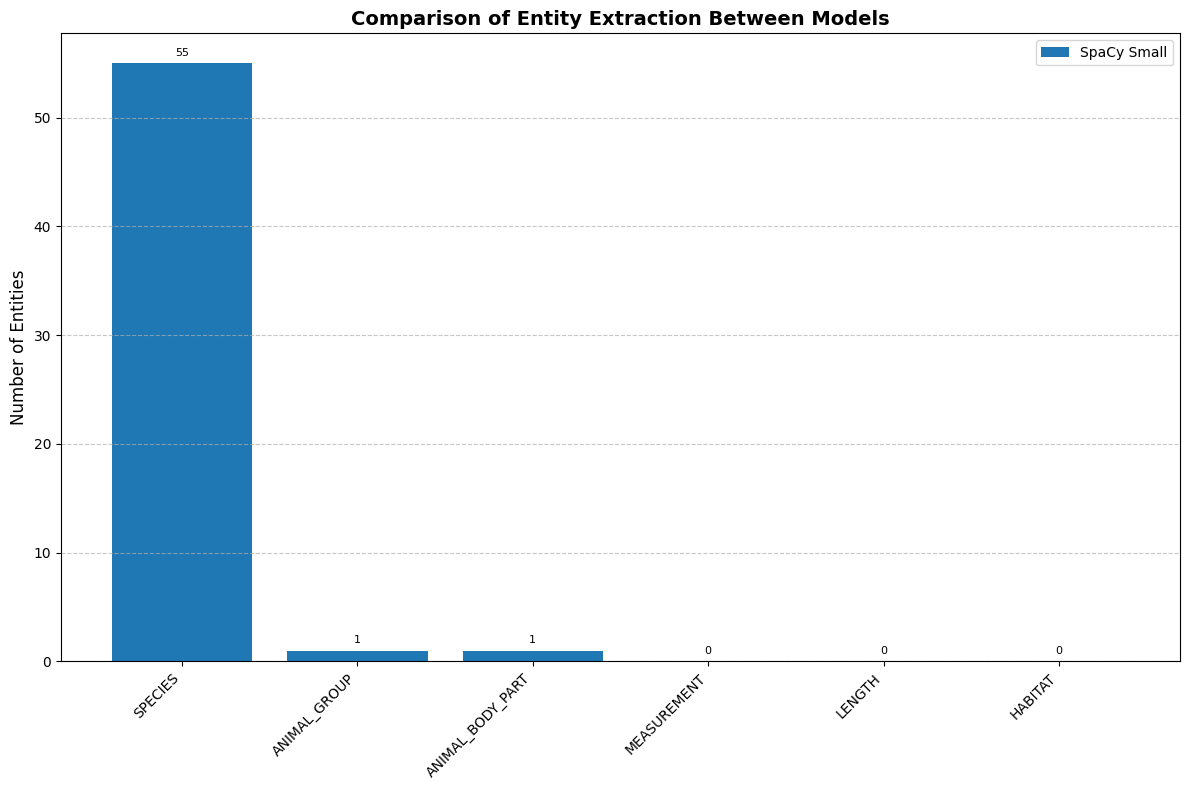


Visualizations created:
- entity_comparison: ./entity_extraction_comparison.png

Results saved to: ./animal_entity_analysis_results.md

Analysis complete!

Would you like to open visualization files now? (y/n): 

Would you like to process another PDF? (y/n): 

Thank you for using the Animal Entity Extractor!


In [ ]:
# Enhanced function for processing PDFs with relationship detection
def process_pdf_with_relationships(pdf_path, entity_types, selected_models, output_dir=None, use_attention=True):
    """
    Process a PDF file to extract entities and their relationships using multiple models.

    Args:
        pdf_path: Path to the PDF file
        entity_types: List of entity types to extract
        selected_models: List of NLP models to use
        output_dir: Directory to save outputs
        use_attention: Whether to use transformer attention for relationship detection

    Returns:
        Tuple of (result_text, text_sample, files)
    """
    if not pdf_path or not os.path.exists(pdf_path):
        return "Please provide a valid PDF file path.", None, {}

    if not entity_types:
        return "Please specify at least one entity type to extract.", None, {}

    if not selected_models:
        return "Please specify at least one NLP model.", None, {}

    try:
        start_time = time.time()
        files = {}

        if output_dir and not os.path.exists(output_dir):
            os.makedirs(output_dir)

        # Extract text from PDF
        text = extract_text_from_pdf(pdf_path)
        text_extraction_time = time.time() - start_time
        logger.info(f"Text extraction completed in {text_extraction_time:.2f} seconds")

        if isinstance(text, str) and text.startswith("Error"):
            return text, None, {}

        # Extract entities using each selected model
        extracted_by_model = {}
        entity_extraction_times = {}
        relationships_by_model = {}
        relationship_times = {}

        # First, extract entities with all models
        for model_name in selected_models:
            if model_name == "BERT-base" and "BERT-base" not in selected_models:
                # Skip attention-only models for entity extraction
                continue

            model_start_time = time.time()
            extracted = extract_entities(text, entity_types, model_name)
            extraction_time = time.time() - model_start_time

            if isinstance(extracted, str) and extracted.startswith("Error"):
                extracted_by_model[model_name] = {"ERROR": [extracted]}
            else:
                extracted_by_model[model_name] = extracted

            entity_extraction_times[model_name] = extraction_time
            logger.info(f"Entity extraction with {model_name} completed in {extraction_time:.2f} seconds")

        # Then, extract relationships for each model that has valid entities
        for model_name in selected_models:
            if model_name not in extracted_by_model or "ERROR" in extracted_by_model[model_name]:
                continue

            # Skip relationship extraction if no entities were found
            if sum(len(entities) for entities in extracted_by_model[model_name].values()) == 0:
                relationships_by_model[model_name] = {
                    "species_habitat": [],
                    "species_body_part": [],
                    "species_measurement": [],
                    "species_group": []
                }
                relationship_times[model_name] = 0
                continue

            # Extract relationships
            relationship_start_time = time.time()

            # Use attention-based extraction if requested and model is not already an attention model
            if use_attention and model_name != "BERT-base":
                logger.info(f"Extracting relationships with attention model for {model_name} entities")
                relationships = extract_entity_relationships_with_attention(
                    text, extracted_by_model[model_name], "BERT-base"
                )
            elif model_name.startswith("SpaCy"):
                # Use pattern-based extraction for SpaCy models
                logger.info(f"Extracting relationships with pattern-based approach for {model_name}")
                relationships = extract_entity_relationships(
                    text, extracted_by_model[model_name], nlp_models[model_name]
                )
            else:
                # Skip relationship extraction for non-SpaCy models without attention
                logger.warning(f"Skipping relationship extraction for {model_name} - not supported")
                relationships = {
                    "species_habitat": [],
                    "species_body_part": [],
                    "species_measurement": [],
                    "species_group": []
                }

            relationship_time = time.time() - relationship_start_time

            if "error" in relationships:
                logger.error(f"Error extracting relationships: {relationships['error']}")
                relationships = {
                    "species_habitat": [],
                    "species_body_part": [],
                    "species_measurement": [],
                    "species_group": []
                }

            relationships_by_model[model_name] = relationships
            relationship_times[model_name] = relationship_time

            logger.info(f"Relationship extraction for {model_name} completed in {relationship_time:.2f} seconds")

            # Create visualizations for each model
            if sum(len(relations) for relations in relationships.values()) > 0:
                # Create relationship graph
                graph_method = "_attention" if use_attention else "_pattern"
                if output_dir:
                    graph_file = os.path.join(output_dir, f"{model_name}_relationship_graph{graph_method}.png")
                else:
                    graph_file = None

                use_scores = graph_method == "_attention"
                G = create_relationship_graph(relationships, entity_types, min_weight=0.2 if use_scores else 1,
                                             use_attention_scores=use_scores)

                if G.number_of_nodes() > 0:
                    graph_viz = visualize_entity_relationships(
                        G, graph_file,
                        title=f"{model_name} Entity Relationships ({graph_method.strip('_')})"
                    )

                    if graph_viz:
                        files[f"{model_name}_graph{graph_method}"] = graph_viz

                # Generate co-occurrence matrix for the entities
                matrix_df = generate_cooccurrence_matrix(extracted_by_model[model_name], entity_types)

                if not matrix_df.empty:
                    if output_dir:
                        matrix_file = os.path.join(output_dir, f"{model_name}_cooccurrence_matrix.png")
                    else:
                        matrix_file = None

                    matrix_viz = visualize_cooccurrence_matrix(matrix_df, matrix_file)

                    if matrix_viz:
                        files[f"{model_name}_matrix"] = matrix_viz

        # Create comparison chart for entities
        if output_dir:
            chart_output_path = os.path.join(output_dir, "entity_extraction_comparison.png")
        else:
            chart_output_path = None

        chart_file = generate_comparison_chart(extracted_by_model, entity_types,
                                             [m for m in selected_models if m != "BERT-base"],
                                             chart_output_path)

        if chart_file:
            files["entity_comparison"] = chart_file

        # Prepare the results document
        result_text = "# Animal Entity Extraction and Relationship Analysis\n\n"
        result_text += "## Summary of Results\n\n"

        # Entity counts by model
        result_text += "### Entity Count by Model\n\n"
        result_text += "| Entity Type | " + " | ".join([m for m in selected_models if m != "BERT-base"]) + " |\n"
        result_text += "|" + "---|" * (len([m for m in selected_models if m != "BERT-base"]) + 1) + "\n"

        for entity_type in entity_types:
            result_text += f"| {entity_type} |"
            for model_name in selected_models:
                if model_name == "BERT-base":
                    continue
                if model_name in extracted_by_model and "ERROR" not in extracted_by_model[model_name]:
                    count = len(extracted_by_model[model_name].get(entity_type, []))
                    result_text += f" {count} |"
                else:
                    result_text += " Error |"
            result_text += "\n"

        # Relationship counts by model
        result_text += "\n### Relationship Count by Model\n\n"
        result_text += "| Relationship Type | " + " | ".join(selected_models) + " |\n"
        result_text += "|" + "---|" * (len(selected_models) + 1) + "\n"

        for rel_type in ["species_habitat", "species_body_part", "species_measurement", "species_group"]:
            result_text += f"| {rel_type.replace('_', ' ').title()} |"
            for model_name in selected_models:
                if model_name in relationships_by_model:
                    count = len(relationships_by_model[model_name].get(rel_type, []))
                    result_text += f" {count} |"
                else:
                    result_text += " N/A |"
            result_text += "\n"

        # Processing times
        result_text += "\n### Processing Times\n\n"
        result_text += "| Model | Entity Extraction (s) | Relationship Extraction (s) |\n"
        result_text += "|---|---|---|\n"
        for model_name in selected_models:
            if model_name == "BERT-base":
                continue
            entity_time = entity_extraction_times.get(model_name, "N/A")
            if not isinstance(entity_time, str):
                entity_time = f"{entity_time:.2f}"

            rel_time = relationship_times.get(model_name, "N/A")
            if not isinstance(rel_time, str):
                rel_time = f"{rel_time:.2f}"

            result_text += f"| {model_name} | {entity_time} | {rel_time} |\n"

        # Add attention model time if used
        if use_attention and "BERT-base" in selected_models:
            result_text += f"| BERT-base (attention) | N/A | N/A |\n"

        # Add detailed entity results for each model
        for model_name in selected_models:
            if model_name == "BERT-base":
                continue

            result_text += f"\n## Entity Extraction Results: {model_name}\n\n"

            if model_name in extracted_by_model:
                if "ERROR" in extracted_by_model[model_name]:
                    result_text += f"Error: {extracted_by_model[model_name]['ERROR'][0]}\n\n"
                    continue

                for entity_type in entity_types:
                    entities = extracted_by_model[model_name].get(entity_type, [])
                    if entities:
                        result_text += f"### {entity_type} ({len(entities)} found)\n\n"
                        # Show up to 20 items, then summarize the rest
                        for item in entities[:20]:
                            result_text += f"- {item}\n"

                        if len(entities) > 20:
                            result_text += f"- *...and {len(entities) - 20} more*\n"
                        result_text += "\n"
                    else:
                        result_text += f"### {entity_type}\n\n"
                        result_text += "No entities of this type found.\n\n"
            else:
                result_text += "No results available.\n\n"

        # Add relationship results for each model
        for model_name in selected_models:
            if model_name not in relationships_by_model:
                continue

            method = "Attention" if use_attention and model_name != "BERT-base" else "Pattern"
            result_text += f"\n## Relationship Results: {model_name} ({method}-based)\n\n"

            relationships = relationships_by_model[model_name]
            total_relationships = sum(len(relations) for relations in relationships.values())

            if total_relationships == 0:
                result_text += "No relationships found.\n\n"
                continue

            result_text += f"Found {total_relationships} total relationships.\n\n"

            # Report on each relationship type
            for relation_type, relations in relationships.items():
                if not relations:
                    continue

                relation_name = relation_type.replace('_', ' ').title()
                result_text += f"### {relation_name} ({len(relations)} found)\n\n"

                # Show top examples (up to 10)
                max_examples = min(10, len(relations))

                for idx, relation in enumerate(relations[:max_examples]):
                    if use_attention and len(relation) == 4:
                        entity1, entity2, context, score = relation
                        result_text += f"{idx+1}. **{entity1}** → **{entity2}** (score: {score:.2f})\n"
                    else:
                        entity1, entity2, context = relation
                        result_text += f"{idx+1}. **{entity1}** → **{entity2}**\n"

                    # Show a snippet of the context
                    context_snippet = context[:100] + "..." if len(context) > 100 else context
                    result_text += f"   *Context: \"{context_snippet.strip()}\"*\n\n"

                if len(relations) > max_examples:
                    result_text += f"*...and {len(relations) - max_examples} more relationships*\n\n"

        # Add visualization information
        if files:
            result_text += "\n## Visualizations\n\n"
            for name, file_path in files.items():
                result_text += f"- **{name}**: {file_path}\n"

            # Add description for each type of visualization
            result_text += "\n### Visualization Types\n\n"
            result_text += "1. **Entity Comparison**: Bar chart comparing entity counts across models\n"
            result_text += "2. **Relationship Graph**: Network visualization showing connections between entities\n"
            result_text += "3. **Co-occurrence Matrix**: Heatmap showing which entity types appear together\n\n"

        # Performance summary
        total_time = time.time() - start_time
        result_text += f"\n## Performance Summary\n\n"
        result_text += f"Total processing time: {total_time:.2f} seconds\n"
        result_text += f"- Text extraction: {text_extraction_time:.2f} seconds\n"

        # Text sample
        text_sample = text[:500] + "..." if len(text) > 500 else text
        result_text += f"\n## Sample of Extracted Text\n\n```\n{text_sample}\n```\n"

        return result_text, text_sample, files

    except Exception as e:
        logger.error(f"Unexpected error: {str(e)}", exc_info=True)
        return f"Unexpected error: {str(e)}", None, {}

# Function to generate a co-occurrence matrix of entities
def generate_cooccurrence_matrix(extracted_entities, entity_types):
    """
    Generate a co-occurrence matrix of entities based on entity types.

    Args:
        extracted_entities: Dictionary of extracted entities by type
        entity_types: List of entity types to include

    Returns:
        DataFrame with co-occurrence counts
    """
    # Create a flat list of all entities with their types
    all_entities = []
    for entity_type in entity_types:
        entities = extracted_entities.get(entity_type, [])
        all_entities.extend([(entity, entity_type) for entity in entities])

    # Create a dictionary to store co-occurrence counts
    cooccurrence = defaultdict(int)

    # Count co-occurrences by looking at all pairs
    for (entity1, type1), (entity2, type2) in combinations(all_entities, 2):
        if type1 != type2:  # Only interested in relationships between different types
            key = (f"{type1}: {entity1}", f"{type2}: {entity2}")
            cooccurrence[key] += 1

    # Convert to a matrix format
    unique_labeled_entities = sorted(set([f"{type}: {entity}" for entity, type in all_entities]))
    matrix_size = len(unique_labeled_entities)

    # Map entity labels to indices
    entity_to_idx = {entity: i for i, entity in enumerate(unique_labeled_entities)}

    # Create a sparse matrix
    row, col, data = [], [], []

    for (entity1, entity2), count in cooccurrence.items():
        if entity1 in entity_to_idx and entity2 in entity_to_idx:
            i, j = entity_to_idx[entity1], entity_to_idx[entity2]
            row.append(i)
            col.append(j)
            data.append(count)
            # Make it symmetric
            row.append(j)
            col.append(i)
            data.append(count)

    # Create the sparse matrix
    if not row:  # Empty matrix
        return pd.DataFrame()

    matrix = csr_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

    # Convert to DataFrame
    cooccurrence_df = pd.DataFrame(matrix.toarray(), index=unique_labeled_entities, columns=unique_labeled_entities)

    return cooccurrence_df
import pdfplumber
import spacy
import re
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter, defaultdict
import logging
import time
import os
import tempfile
from io import BytesIO
import torch
from transformers import AutoTokenizer, AutoModelForTokenClassification, pipeline, AutoModel
import seaborn as sns
import pandas as pd
import networkx as nx
from scipy.sparse import csr_matrix
from matplotlib.colors import LinearSegmentedColormap
import warnings
from IPython.display import display, HTML, Image
warnings.filterwarnings("ignore")

# Set up logging
logging.basicConfig(
    level=logging.INFO,
    format='%(asctime)s - %(name)s - %(levelname)s - %(message)s',
    handlers=[logging.StreamHandler()]
)
logger = logging.getLogger(__name__)

# Dictionary to store loaded models
nlp_models = {}
transformer_models = {}
attention_models = {}

# Available NLP models
AVAILABLE_MODELS = {
    "SpaCy Small": "en_core_web_sm",
    "SpaCy Large": "en_core_web_lg",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1-named-entity-recognition",
    "BERT-base": "bert-base-uncased"  # Added for attention-based relationship extraction
}

# Function to load NLP model
def load_nlp_model(model_name):
    if model_name in nlp_models:
        return nlp_models[model_name]

    model_path = AVAILABLE_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown model: {model_name}")
        return None

    try:
        # BioBERT uses HuggingFace Transformers
        if model_name == "BioBERT":
            logger.info(f"Loading BioBERT model: {model_path}")
            try:
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = AutoModelForTokenClassification.from_pretrained(model_path)

                # Create NER pipeline
                ner_model = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)
                transformer_models[model_name] = ner_model
                nlp_models[model_name] = "transformer"
                logger.info(f"BioBERT model loaded successfully")
                return "transformer"
            except Exception as e:
                logger.error(f"Error loading BioBERT model: {str(e)}")
                logger.warning("Please install transformers: pip install transformers torch")
                return None
        elif model_name == "BERT-base":
            logger.info(f"Loading BERT-base model for attention: {model_path}")
            try:
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                model = AutoModel.from_pretrained(model_path, output_attentions=True)

                attention_models[model_name] = {
                    "tokenizer": tokenizer,
                    "model": model
                }
                nlp_models[model_name] = "attention"
                logger.info(f"BERT-base model loaded successfully for attention analysis")
                return "attention"
            except Exception as e:
                logger.error(f"Error loading BERT-base model: {str(e)}")
                logger.warning("Please install transformers: pip install transformers torch")
                return None
        else:
            # SpaCy models
            logger.info(f"Loading model: {model_name} ({model_path})")
            nlp = spacy.load(model_path)

            # Add animal entity patterns
            if "entity_ruler" not in nlp.pipe_names:
                ruler = nlp.add_pipe("entity_ruler", before="ner")
                patterns = [
                    # Improved SPECIES pattern for scientific names (Genus species)
                    {"label": "SPECIES", "pattern": [
                        {"TEXT": {"REGEX": "^[A-Z][a-z]+$"}},  # Genus - capitalized word
                        {"TEXT": {"REGEX": "^[a-z]+$"}}        # species - lowercase word
                    ]},
                    # Common animal names pattern
                    {"label": "SPECIES", "pattern": [
                        {"LOWER": {"IN": ["dog", "cat", "horse", "cow", "pig", "sheep", "goat", "chicken",
                                        "fish", "salmon", "trout", "bass", "butterfly", "bee", "ant", "spider",
                                        "lion", "tiger", "bear", "elephant", "giraffe", "rhinoceros", "zebra",
                                        "cheetah", "leopard", "wolf", "fox", "deer", "moose", "eagle", "hawk",
                                        "owl", "parrot", "dolphin", "whale", "shark", "turtle", "snake",
                                        "crocodile", "alligator", "frog", "toad"]}}
                    ]},
                    # Animal groups with adjectives
                    {"label": "SPECIES", "pattern": [
                        {"LOWER": {"IN": ["african", "asian", "american", "european", "australian",
                                         "western", "eastern", "northern", "southern"]}},
                        {"LOWER": {"IN": ["lion", "tiger", "bear", "elephant", "giraffe", "rhinoceros",
                                         "zebra", "cheetah", "leopard", "wolf", "fox", "deer", "moose",
                                         "eagle", "hawk", "owl", "parrot", "dolphin", "whale", "shark",
                                         "turtle", "snake", "crocodile", "alligator"]}}
                    ]},
                    # Animal groups
                    {"label": "ANIMAL_GROUP", "pattern": [
                        {"LOWER": {"IN": ["herd", "flock", "pack", "pod", "school", "colony", "pride",
                                         "swarm", "murder", "gaggle", "hive", "brood", "drift"]}}
                    ]},
                    # Animal body parts
                    {"label": "ANIMAL_BODY_PART", "pattern": [
                        {"LOWER": {"IN": ["paw", "claw", "hoof", "beak", "wing", "fin", "tail", "horn",
                                         "tusk", "scale", "feather", "fur", "mane", "whisker", "snout",
                                         "bill", "gills", "tentacle", "antenna"]}}
                    ]},
                    # Measurements
                    {"label": "MEASUREMENT", "pattern": [
                        {"SHAPE": {"IN": ["d+", "d+.d+"]}},
                        {"LOWER": {"IN": ["mm", "cm", "m", "kg", "g", "ml", "l"]}}
                    ]},
                    # Length measurements
                    {"label": "LENGTH", "pattern": [
                        {"LOWER": {"IN": ["fork", "total", "standard", "body", "tail"]}},
                        {"LOWER": "length"}
                    ]},
                    # Habitats
                    {"label": "HABITAT", "pattern": [
                        {"LOWER": {"IN": ["forest", "jungle", "savanna", "ocean", "lake", "river", "mountain",
                                        "desert", "tundra", "reef", "farm", "pasture", "pen", "enclosure",
                                        "cage", "burrow", "nest", "den", "wetland", "bog", "marsh"]}}
                    ]},
                ]
                ruler.add_patterns(patterns)

            nlp_models[model_name] = nlp
            logger.info(f"SpaCy model {model_name} loaded successfully")
            return nlp
    except OSError as e:
        logger.warning(f"Error loading model {model_path}: {str(e)}")
        if model_name.startswith("SpaCy"):
            logger.warning(f"Please download it using: python -m spacy download {model_path}")
        elif model_name in ["BioBERT", "BERT-base"]:
            logger.warning("Please install transformers: pip install transformers torch")

        # Create a blank model as fallback if it's a SpaCy model
        if model_name.startswith("SpaCy"):
            nlp = spacy.blank("en")
            nlp_models[model_name] = nlp
            return nlp
        return None

# Check which models are installed
def get_available_models():
    installed_models = []

    # Check SpaCy models
    for name, path in AVAILABLE_MODELS.items():
        if name.startswith("SpaCy"):
            try:
                spacy.load(path)
                installed_models.append(name)
            except OSError:
                pass
        elif name in ["BioBERT", "BERT-base"]:
            try:
                # Check if transformers is installed
                import transformers

                # Add transformer models to available models regardless of whether they're downloaded
                # We'll handle the download when it's first used
                installed_models.append(name)

                # Just log that we'll download when needed
                logger.info(f"{name} model will be downloaded automatically when first used.")
            except ImportError:
                logger.warning("Transformers package not installed. Transformer models will not be available.")

    # Ensure at least one model is available
    if not installed_models:
        try:
            spacy.load("en_core_web_sm")
            installed_models.append("SpaCy Small")
        except OSError:
            installed_models.append("Blank Model")
            logger.warning("No SpaCy models installed. Please run: python -m spacy download en_core_web_sm")
            logger.warning("For transformer models: pip install transformers torch")

    return installed_models

# Function to extract text from PDF with better error handling
def extract_text_from_pdf(pdf_file):
    if not pdf_file or not os.path.exists(pdf_file):
        return "No file provided or file does not exist."

    try:
        text = ""
        with pdfplumber.open(pdf_file) as pdf:
            total_pages = len(pdf.pages)
            logger.info(f"Processing PDF with {total_pages} pages")

            for i, page in enumerate(pdf.pages):
                logger.info(f"Extracting text from page {i+1}/{total_pages}")
                extracted_text = page.extract_text()
                if extracted_text:
                    text += extracted_text + "\n"

        if not text.strip():
            return "No text could be extracted from the PDF."

        logger.info(f"Successfully extracted {len(text)} characters of text")
        return text
    except Exception as e:
        logger.error(f"Error processing PDF: {str(e)}", exc_info=True)
        return f"Error processing PDF: {str(e)}"

# Extract entities using BioBERT
def extract_entities_biobert(text, entity_types):
    try:
        if "BioBERT" not in transformer_models:
            model_path = AVAILABLE_MODELS.get("BioBERT")
            try:
                logger.info(f"BioBERT model not loaded yet. Downloading and initializing...")

                # Set download settings
                logger.info("Setting up to download BioBERT model...")

                # Print info about what's happening
                print("\nDownloading BioBERT model. This may take a few minutes on first run...")
                print("Model: dmis-lab/biobert-base-cased-v1.1-named-entity-recognition")

                # Load tokenizer with progress reporting
                print("Loading tokenizer...")
                tokenizer = AutoTokenizer.from_pretrained(model_path)

                # Load model with progress reporting
                print("Loading model weights (this might take a while)...")
                model = AutoModelForTokenClassification.from_pretrained(model_path)

                print("Creating NER pipeline...")
                ner_model = pipeline('ner', model=model, tokenizer=tokenizer, grouped_entities=True)

                transformer_models["BioBERT"] = ner_model
                print("BioBERT model loaded successfully!\n")
            except Exception as e:
                logger.error(f"Error loading BioBERT model: {str(e)}")
                print(f"\nError: Could not load BioBERT model. Details: {str(e)}")
                print("Common solutions:")
                print("1. Check internet connection")
                print("2. Ensure 'transformers' and 'torch' are installed: pip install transformers torch")
                print("3. Try again or use a different model\n")
                return f"Error: Could not load BioBERT model: {str(e)}"

        ner_model = transformer_models["BioBERT"]

        # Process text in chunks to avoid CUDA out of memory errors
        max_length = 512  # Maximum length for BERT models
        chunks = [text[i:i+max_length] for i in range(0, len(text), max_length)]

        logger.info(f"Processing {len(chunks)} chunks with BioBERT")

        all_entities = []
        for i, chunk in enumerate(chunks):
            if i % 10 == 0:
                logger.info(f"Processing chunk {i+1}/{len(chunks)}")

            if not chunk.strip():
                continue

            try:
                chunk_entities = ner_model(chunk)
                all_entities.extend(chunk_entities)
            except Exception as e:
                logger.warning(f"Error processing chunk {i}: {str(e)}")
                continue

        # Map BioBERT entity types to our types and extract entities
        extracted = {entity_type: [] for entity_type in entity_types}

        # BioBERT's default entity types: 'B-MISC', 'I-MISC', 'O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'
        # Map BioBERT entity types to our custom types
        entity_mapping = {
            'B-MISC': ['ANIMAL_BODY_PART', 'MEASUREMENT', 'LENGTH'],
            'I-MISC': ['ANIMAL_BODY_PART', 'MEASUREMENT', 'LENGTH'],
            'B-PER': ['SPECIES'],  # Sometimes species names are recognized as persons
            'I-PER': ['SPECIES'],
            'B-ORG': ['ANIMAL_GROUP'],
            'I-ORG': ['ANIMAL_GROUP'],
            'B-LOC': ['HABITAT'],
            'I-LOC': ['HABITAT'],
        }

        # Process entities
        for entity in all_entities:
            entity_text = entity['word']
            entity_type = entity['entity']
            score = entity['score']

            # Only consider entities with confidence above threshold
            if score < 0.75:
                continue

            # Map BioBERT entity types to our types
            mapped_types = entity_mapping.get(entity_type, [])

            # Add entity to all compatible types
            for mapped_type in mapped_types:
                if mapped_type in entity_types:
                    extracted[mapped_type].append(entity_text)

        # Additional regex-based extraction for specific entity types
        # Scientific species names (Genus species)
        if "SPECIES" in entity_types:
            species_pattern = r'\b[A-Z][a-z]+\s+[a-z]+\b'
            scientific_names = re.findall(species_pattern, text)
            extracted["SPECIES"].extend(scientific_names)

            # Common animal names
            common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
            extracted["SPECIES"].extend(common_animals)

        # Animal groups
        if "ANIMAL_GROUP" in entity_types:
            groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder|gaggle|hive|brood|drift)\s+of\s+\w+\b', text, re.IGNORECASE)
            extracted["ANIMAL_GROUP"].extend(groups)

        # Body parts
        if "ANIMAL_BODY_PART" in entity_types:
            body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|bill|gills|tentacle|antenna)s?\b', text, re.IGNORECASE)
            extracted["ANIMAL_BODY_PART"].extend(body_parts)

        # Measurements
        if "MEASUREMENT" in entity_types:
            measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
            extracted["MEASUREMENT"].extend(measurements)

        # Length measurements
        if "LENGTH" in entity_types:
            length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
            extracted["LENGTH"].extend(length_patterns)

        # Habitats
        if "HABITAT" in entity_types:
            habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|farm|pasture|pen|enclosure|cage|burrow|nest|den|wetland|bog|marsh)\b', text, re.IGNORECASE)
            extracted["HABITAT"].extend(habitats)

        # Remove duplicates and sort
        for entity_type in entity_types:
            extracted[entity_type] = sorted(list(set([e.strip() for e in extracted[entity_type] if e.strip()])))
            logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with BioBERT")

        return extracted
    except Exception as e:
        logger.error(f"Error extracting entities with BioBERT: {str(e)}", exc_info=True)
        return f"Error extracting entities with BioBERT: {str(e)}"

# Function to extract entities with better error handling and performance
def extract_entities(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Special handling for BioBERT model
            if model_name == "BioBERT":
                return extract_entities_biobert(text, entity_types)

            # Get the specified SpaCy model
            nlp = load_nlp_model(model_name)
            if nlp is None:
                return f"Could not load NLP model: {model_name}"
            if nlp == "transformer":
                return extract_entities_biobert(text, entity_types)
            if nlp == "attention":
                # Attention models are not used for entity extraction directly
                # but instead for relationship extraction
                logger.warning(f"{model_name} is an attention model, not used for entity extraction")
                return {entity_type: [] for entity_type in entity_types}

            # Limit text size for SpaCy models to avoid memory issues
            if len(text) > 100000:
                logger.warning(f"Text is very large ({len(text)} chars). Limiting to first 100k characters.")
                text = text[:100000]  # Limit to first 100k characters

            logger.info(f"Processing text with {model_name} ({len(text)} chars)")
            doc = nlp(text)

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Extract required entity types
            for ent in doc.ents:
                if ent.label_ in entity_types:
                    extracted[ent.label_].append(ent.text)

            # Special case for animal scientific species names
            if "SPECIES" in entity_types:
                logger.info("Extracting scientific species names with regex")

                # Scientific names pattern (Genus species)
                scientific_names = re.findall(r'\b[A-Z][a-z]+\s+[a-z]+\b', text)
                extracted["SPECIES"].extend(scientific_names)

                # Additional check for common animal names (with capitalized nouns)
                common_animals = re.findall(r'\b(?:African|Asian|American|European|Australian|Western|Eastern|Northern|Southern)?\s*(?:Lion|Tiger|Bear|Elephant|Giraffe|Rhinoceros|Zebra|Cheetah|Leopard|Wolf|Fox|Deer|Moose|Eagle|Hawk|Owl|Parrot|Dolphin|Whale|Shark|Turtle|Snake|Crocodile|Alligator|Frog|Toad|Fish|Salmon|Trout|Bass|Butterfly|Bee|Ant|Spider)\b', text)
                extracted["SPECIES"].extend(common_animals)

            # Special case for animal groups
            if "ANIMAL_GROUP" in entity_types:
                logger.info("Extracting animal group terms with regex")
                groups = re.findall(r'\b(?:herd|flock|pack|pod|school|colony|pride|swarm|murder|gaggle|hive|brood|drift)\s+of\s+\w+\b', text, re.IGNORECASE)
                extracted["ANIMAL_GROUP"].extend(groups)

            # Special case for body parts
            if "ANIMAL_BODY_PART" in entity_types:
                logger.info("Extracting animal body parts with regex")
                body_parts = re.findall(r'\b(?:paw|claw|hoof|beak|wing|fin|tail|horn|tusk|scale|feather|fur|mane|whisker|snout|bill|gills|tentacle|antenna)s?\b', text, re.IGNORECASE)
                extracted["ANIMAL_BODY_PART"].extend(body_parts)

            # Special case for measurements
            if "MEASUREMENT" in entity_types:
                logger.info("Extracting measurements with regex")
                measurements = re.findall(r'\b\d+\.?\d*\s*(?:mm|cm|m|kg|g|ml|l)\b', text)
                extracted["MEASUREMENT"].extend(measurements)

            # Special case for length measurements
            if "LENGTH" in entity_types:
                logger.info("Extracting length measurements with regex")
                length_patterns = re.findall(r'(?:fork|total|standard|body|tail)?\s*length\s*(?:of)?\s*\d+\.?\d*\s*(?:mm|cm|m)', text, re.IGNORECASE)
                extracted["LENGTH"].extend(length_patterns)

            # Special case for habitats
            if "HABITAT" in entity_types:
                logger.info("Extracting habitat terms with regex")
                habitats = re.findall(r'\b(?:forest|jungle|savanna|ocean|lake|river|mountain|desert|tundra|reef|farm|pasture|pen|enclosure|cage|burrow|nest|den|wetland|bog|marsh)\b', text, re.IGNORECASE)
                extracted["HABITAT"].extend(habitats)

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set([e.strip() for e in extracted[entity_type] if e.strip()])))
                logger.info(f"Found {len(extracted[entity_type])} unique {entity_type} entities with {model_name}")

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with {model_name}: {str(e)}", exc_info=True)
            return f"Error extracting entities with {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

# Function to generate comparison visualization
def generate_comparison_chart(extracted_by_model, entity_types, models, output_path=None):
    try:
        if output_path is None:
            temp_dir = tempfile.mkdtemp()
            chart_file = os.path.join(temp_dir, "animal_comparison_chart.png")
        else:
            chart_file = output_path

        # Set up the plot
        fig, ax = plt.subplots(figsize=(12, 8))

        # Prepare data
        x = np.arange(len(entity_types))
        width = 0.8 / len(models)

        # Define a color palette
        colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']

        # Plot bars for each model
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                ax.bar(x + offset, counts, width, label=model, color=colors[i % len(colors)])

        # Add labels and title
        ax.set_ylabel('Number of Entities', fontsize=12)
        ax.set_title('Comparison of Entity Extraction Between Models', fontsize=14, fontweight='bold')
        ax.set_xticks(x)
        ax.set_xticklabels(entity_types, rotation=45, ha='right', fontsize=10)
        ax.legend(loc='best')

        # Add value labels on top of each bar
        for i, model in enumerate(models):
            if model in extracted_by_model:
                counts = [len(extracted_by_model[model].get(entity_type, [])) for entity_type in entity_types]
                offset = width * i - width * (len(models) - 1) / 2
                for j, count in enumerate(counts):
                    ax.text(x[j] + offset, count + 0.5, str(count), ha='center', va='bottom', fontsize=8)

        # Add a grid for better readability
        ax.grid(axis='y', linestyle='--', alpha=0.7)

        # Improve layout
        plt.tight_layout()
        plt.savefig(chart_file, dpi=300, bbox_inches='tight')

        # Display in notebook if in notebook environment
        try:
            from IPython import get_ipython
            if get_ipython() is not None:
                plt.show()
        except (ImportError, NameError):
            pass

        plt.close()

        return chart_file
    except Exception as e:
        logger.error(f"Error creating comparison chart: {str(e)}", exc_info=True)
        return None

# NEW FUNCTION: Extract entity relationships using pattern-based approach
def extract_entity_relationships(text, extracted_entities, nlp_model):
    """
    Extract relationships between different entities using dependency parsing and co-occurrence.

    Args:
        text: The text content from the PDF
        extracted_entities: Dictionary of extracted entities by type
        nlp_model: The loaded SpaCy NLP model (must be SpaCy, not BioBERT)

    Returns:
        Dictionary of relationship types and their instances
    """
    if isinstance(nlp_model, str):
        return {"error": ["Relationship extraction requires a SpaCy model"]}

    relationships = {
        "species_habitat": [],       # Which species live in which habitats
        "species_body_part": [],     # Which body parts belong to which species
        "species_measurement": [],   # Measurements associated with species
        "species_group": []          # Species associated with animal groups
    }

    # Flatten entity lists into entity-type mappings for fast lookup
    entity_map = {}
    for entity_type, entities in extracted_entities.items():
        for entity in entities:
            entity_map[entity.lower()] = entity_type

    # Process text in manageable chunks to avoid memory issues
    max_chunk_size = 5000
    chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]

    logger.info(f"Processing {len(chunks)} chunks for entity relationships")

    # Process each chunk
    for i, chunk in enumerate(chunks):
        if i % 10 == 0:
            logger.info(f"Processing relationship chunk {i+1}/{len(chunks)}")

        if not chunk.strip():
            continue

        try:
            # Process with spaCy
            doc = nlp_model(chunk)

            # Extract sentences
            sentences = list(doc.sents)

            # Analyze each sentence for entity relationships
            for sentence in sentences:
                sentence_text = sentence.text.lower()

                # Find entities in this sentence
                sentence_entities = {}
                for entity, entity_type in entity_map.items():
                    if entity.lower() in sentence_text:
                        start = sentence_text.find(entity.lower())
                        if start >= 0:
                            sentence_entities[(start, start + len(entity))] = (entity, entity_type)

                # If we have multiple entity types in the sentence, check for relationships
                entity_types_in_sent = set(et for _, et in sentence_entities.values())

                # Species and habitat relationship
                if "SPECIES" in entity_types_in_sent and "HABITAT" in entity_types_in_sent:
                    # Look for habitat relationship patterns
                    habitat_patterns = [
                        "found in", "lives in", "inhabits", "native to", "occurs in",
                        "present in", "located in", "resides in", "dwells in", "occupies"
                    ]

                    for pattern in habitat_patterns:
                        if pattern in sentence_text:
                            # Find closest species and habitat entities
                            pattern_pos = sentence_text.find(pattern)
                            species_entities = [(pos, entity) for pos, (entity, entity_type)
                                               in sentence_entities.items()
                                               if entity_type == "SPECIES"]
                            habitat_entities = [(pos, entity) for pos, (entity, entity_type)
                                              in sentence_entities.items()
                                              if entity_type == "HABITAT"]

                            if species_entities and habitat_entities:
                                # Find closest species before the pattern
                                species_before = [(abs(pattern_pos - (pos + len(entity[0]))), entity[0])
                                               for pos, entity in species_entities
                                               if pos < pattern_pos]

                                # Find closest habitat after the pattern
                                habitat_after = [(abs(pos - (pattern_pos + len(pattern))), entity[0])
                                              for pos, entity in habitat_entities
                                              if pos > pattern_pos]

                                if species_before and habitat_after:
                                    species = min(species_before, key=lambda x: x[0])[1]
                                    habitat = min(habitat_after, key=lambda x: x[0])[1]
                                    relationship = (species, habitat, sentence.text)
                                    if relationship not in relationships["species_habitat"]:
                                        relationships["species_habitat"].append(relationship)

                # Species and body part relationship
                if "SPECIES" in entity_types_in_sent and "ANIMAL_BODY_PART" in entity_types_in_sent:
                    # Find possession patterns
                    possession_patterns = [
                        "has", "with", "possesses", "featuring", "characterized by",
                        "'s", "of the", "of its", "their", "its"
                    ]

                    for pattern in possession_patterns:
                        if pattern in sentence_text:
                            pattern_pos = sentence_text.find(pattern)
                            species_entities = [(pos, entity) for pos, (entity, entity_type)
                                               in sentence_entities.items()
                                               if entity_type == "SPECIES"]
                            body_part_entities = [(pos, entity) for pos, (entity, entity_type)
                                                in sentence_entities.items()
                                                if entity_type == "ANIMAL_BODY_PART"]

                            if species_entities and body_part_entities:
                                species_before = [(abs(pattern_pos - (pos + len(entity[0]))), entity[0])
                                               for pos, entity in species_entities
                                               if pos < pattern_pos]

                                body_part_after = [(abs(pos - (pattern_pos + len(pattern))), entity[0])
                                              for pos, entity in body_part_entities
                                              if pos > pattern_pos]

                                if species_before and body_part_after:
                                    species = min(species_before, key=lambda x: x[0])[1]
                                    body_part = min(body_part_after, key=lambda x: x[0])[1]
                                    relationship = (species, body_part, sentence.text)
                                    if relationship not in relationships["species_body_part"]:
                                        relationships["species_body_part"].append(relationship)

                # Species and measurements
                if "SPECIES" in entity_types_in_sent and ("MEASUREMENT" in entity_types_in_sent or "LENGTH" in entity_types_in_sent):
                    # Look for measurement patterns
                    measurement_patterns = [
                        "measures", "weighs", "length of", "size of", "weight of",
                        "is about", "approximately", "typically", "averages", "ranging from"
                    ]

                    measurement_entities = [(pos, entity) for pos, (entity, entity_type)
                                           in sentence_entities.items()
                                           if entity_type in ["MEASUREMENT", "LENGTH"]]

                    species_entities = [(pos, entity) for pos, (entity, entity_type)
                                       in sentence_entities.items()
                                       if entity_type == "SPECIES"]

                    if species_entities and measurement_entities:
                        for species_pos, species_entity in species_entities:
                            for measurement_pos, measurement_entity in measurement_entities:
                                # Check if they're close to each other (within 50 characters)
                                if abs(species_pos - measurement_pos) < 50:
                                    relationship = (species_entity[0], measurement_entity[0], sentence.text)
                                    if relationship not in relationships["species_measurement"]:
                                        relationships["species_measurement"].append(relationship)

                # Species and group relationships
                if "SPECIES" in entity_types_in_sent and "ANIMAL_GROUP" in entity_types_in_sent:
                    group_entities = [(pos, entity) for pos, (entity, entity_type)
                                     in sentence_entities.items()
                                     if entity_type == "ANIMAL_GROUP"]

                    species_entities = [(pos, entity) for pos, (entity, entity_type)
                                       in sentence_entities.items()
                                       if entity_type == "SPECIES"]

                    if species_entities and group_entities:
                        for group_pos, group_entity in group_entities:
                            # Group terms usually have "of X" structure, check for the species after "of"
                            if "of " in group_entity[0]:
                                group_text = group_entity[0]
                                after_of = group_text.split("of ")[1].strip().lower()

                                # Check if any species appears in or matches the group description
                                for _, species_entity in species_entities:
                                    species_text = species_entity[0].lower()
                                    if species_text in after_of or after_of in species_text:
                                        relationship = (species_entity[0], group_entity[0], sentence.text)
                                        if relationship not in relationships["species_group"]:
                                            relationships["species_group"].append(relationship)

        except Exception as e:
            logger.warning(f"Error processing chunk {i} for relationships: {str(e)}")
            continue

    # Log results
    for relation_type, relations in relationships.items():
        logger.info(f"Found {len(relations)} {relation_type} relationships")

    return relationships

# NEW FUNCTION: Extract entity relationships with transformer attention
def extract_entity_relationships_with_attention(text, extracted_entities, model_name="BERT-base"):
    """
    Extract relationships between entities using transformer attention mechanisms.

    Args:
        text: The text content from the PDF
        extracted_entities: Dictionary of extracted entities by type
        model_name: Pretrained transformer model to use

    Returns:
        Dictionary of relationship types and their instances with attention scores
    """
    try:
        if model_name not in attention_models:
            # Load the model if not already loaded
            load_nlp_model(model_name)

            if model_name not in attention_models:
                return {"error": [f"Could not load attention model: {model_name}"]}

        tokenizer = attention_models[model_name]["tokenizer"]
        model = attention_models[model_name]["model"]

        # Prepare relationships dictionary
        relationships = {
            "species_habitat": [],
            "species_body_part": [],
            "species_measurement": [],
            "species_group": []
        }

        # Prepare entity mapping for lookup
        entity_spans = []
        entity_types = []

        for entity_type, entities in extracted_entities.items():
            for entity in entities:
                entity_spans.append((entity, entity_type))

        # Process text in chunks that fit within model's max context
        max_length = tokenizer.model_max_length
        sentences = re.split(r'(?<=[.!?])\s+', text)

        logger.info(f"Processing {len(sentences)} sentences with attention model")

        # Process sentences to find relationships
        for i, sentence in enumerate(sentences):
            if i % 100 == 0:
                logger.info(f"Processing sentence {i+1}/{len(sentences)} with attention")

            if not sentence.strip() or len(sentence) > max_length:
                continue

            # Find entities in this sentence
            entities_in_sentence = []
            for entity, entity_type in entity_spans:
                if entity.lower() in sentence.lower():
                    entities_in_sentence.append((entity, entity_type))

            # Skip if less than 2 entities or no species in the sentence
            if len(entities_in_sentence) < 2:
                continue

            has_species = any(et == "SPECIES" for _, et in entities_in_sentence)
            if not has_species:
                continue

            # Tokenize sentence
            inputs = tokenizer(sentence, return_tensors="pt", padding=True, truncation=True)

            # Get model outputs with attention weights
            with torch.no_grad():
                outputs = model(**inputs)

            # Extract attention matrices from the last layer
            # Shape: [batch_size, num_heads, seq_length, seq_length]
            attention = outputs.attentions[-1].mean(dim=1).squeeze(0)  # Average over attention heads

            # Map tokens back to entities
            token_to_entity = {}
            for entity, entity_type in entities_in_sentence:
                entity_tokens = tokenizer.encode(entity, add_special_tokens=False)

                # Find the entity tokens in the sentence tokens
                sentence_tokens = inputs.input_ids[0].tolist()
                for i in range(len(sentence_tokens) - len(entity_tokens) + 1):
                    if sentence_tokens[i:i+len(entity_tokens)] == entity_tokens:
                        for j in range(i, i+len(entity_tokens)):
                            token_to_entity[j] = (entity, entity_type)

            # Build entity attention matrix
            entity_attention = {}
            for i in range(attention.shape[0]):
                if i in token_to_entity:
                    entity_i, type_i = token_to_entity[i]
                    for j in range(attention.shape[1]):
                        if j in token_to_entity and i != j:
                            entity_j, type_j = token_to_entity[j]

                            # Skip if same entity
                            if entity_i == entity_j:
                                continue

                            # Get attention score
                            att_score = float(attention[i, j])

                            key = ((entity_i, type_i), (entity_j, type_j))
                            if key not in entity_attention or att_score > entity_attention[key][0]:
                                entity_attention[key] = (att_score, sentence)

            # Extract relationships based on entity types and attention scores
            for ((entity1, type1), (entity2, type2)), (score, context) in entity_attention.items():
                # Only consider high attention scores (threshold can be adjusted)
                if score < 0.1:
                    continue

                # Define relationships based on entity types and attention score
                if type1 == "SPECIES" and type2 == "HABITAT" and score > 0.3:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_habitat"].append(relationship)

                elif type1 == "SPECIES" and type2 == "ANIMAL_BODY_PART" and score > 0.4:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_body_part"].append(relationship)

                elif type1 == "SPECIES" and type2 in ["MEASUREMENT", "LENGTH"] and score > 0.3:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_measurement"].append(relationship)

                elif type1 == "SPECIES" and type2 == "ANIMAL_GROUP" and score > 0.3:
                    relationship = (entity1, entity2, context, score)
                    relationships["species_group"].append(relationship)

                # Check reverse direction for asymmetric relationships
                elif type2 == "SPECIES" and type1 == "HABITAT" and score > 0.3:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_habitat"].append(relationship)

                elif type2 == "SPECIES" and type1 == "ANIMAL_BODY_PART" and score > 0.4:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_body_part"].append(relationship)

                elif type2 == "SPECIES" and type1 in ["MEASUREMENT", "LENGTH"] and score > 0.3:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_measurement"].append(relationship)

                elif type2 == "SPECIES" and type1 == "ANIMAL_GROUP" and score > 0.3:
                    relationship = (entity2, entity1, context, score)
                    relationships["species_group"].append(relationship)

        # Remove duplicates and sort by score
        for relation_type in relationships:
            unique_relations = {}
            for entity1, entity2, context, score in relationships[relation_type]:
                key = (entity1, entity2)
                if key not in unique_relations or score > unique_relations[key][2]:
                    unique_relations[key] = (entity1, entity2, score, context)

            # Sort by attention score
            relationships[relation_type] = [(e1, e2, ctx, score) for e1, e2, score, ctx in sorted(
                unique_relations.values(), key=lambda x: x[2], reverse=True
            )]

            logger.info(f"Found {len(relationships[relation_type])} unique {relation_type} relationships with attention")

        return relationships

    except Exception as e:
        logger.error(f"Error extracting relationships with attention: {str(e)}", exc_info=True)
        return {"error": [f"Error extracting relationships with attention: {str(e)}"]}

# Function to create a relationship graph
def create_relationship_graph(relationships, entity_types, min_weight=1, use_attention_scores=False):
    """
    Create a NetworkX graph representing entity relationships.

    Args:
        relationships: Dictionary of relationship types and their instances
        entity_types: List of entity types to include
        min_weight: Minimum weight to include an edge
        use_attention_scores: Whether to use attention scores for edge weights

    Returns:
        NetworkX graph
    """
    G = nx.Graph()

    # Add nodes with entity type information
    entity_nodes = set()

    # Process each relationship type
    for relation_type, relations in relationships.items():
        for relation in relations:
            if use_attention_scores and len(relation) == 4:
                entity1, entity2, context, score = relation
                weight = score  # Use attention score as weight
            else:
                if len(relation) == 3:
                    entity1, entity2, context = relation
                    weight = 1  # Default weight
                else:
                    continue  # Skip invalid relations

            # Determine entity types
            entity1_type = None
            entity2_type = None

            if relation_type == "species_habitat":
                entity1_type = "SPECIES"
                entity2_type = "HABITAT"
            elif relation_type == "species_body_part":
                entity1_type = "SPECIES"
                entity2_type = "ANIMAL_BODY_PART"
            elif relation_type == "species_measurement":
                entity1_type = "SPECIES"
                entity2_type = "MEASUREMENT"
            elif relation_type == "species_group":
                entity1_type = "SPECIES"
                entity2_type = "ANIMAL_GROUP"

            # Add nodes if they don't exist
            if entity1 not in entity_nodes:
                G.add_node(entity1, type=entity1_type)
                entity_nodes.add(entity1)

            if entity2 not in entity_nodes:
                G.add_node(entity2, type=entity2_type)
                entity_nodes.add(entity2)

            # Add or update edge
            if G.has_edge(entity1, entity2):
                if use_attention_scores:
                    # Use maximum attention score if multiple relations exist
                    G[entity1][entity2]['weight'] = max(G[entity1][entity2]['weight'], weight)
                else:
                    G[entity1][entity2]['weight'] += 1

                G[entity1][entity2]['examples'].append(context)
                G[entity1][entity2]['types'].add(relation_type)
            else:
                G.add_edge(
                    entity1,
                    entity2,
                    weight=weight,
                    examples=[context],
                    types={relation_type}
                )

    # Remove edges below the minimum weight
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_weight]
    G.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

# Function to visualize entity relationships
def visualize_entity_relationships(G, output_path=None, max_nodes=50, title="Entity Relationship Network"):
    """
    Create a visualization of entity relationships using NetworkX.

    Args:
        G: NetworkX graph of entity relationships
        output_path: Path to save the visualization
        max_nodes: Maximum number of nodes to include in the visualization
        title: Title for the visualization

    Returns:
        Path to the saved visualization
    """
    if output_path is None:
        temp_dir = tempfile.mkdtemp()
        output_file = os.path.join(temp_dir, "entity_relationships.png")
    else:
        output_file = output_path

    # If graph is too large, take a subgraph
    if len(G.nodes()) > max_nodes:
        # Sort edges by weight
        edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

        # Take top N edges
        top_edges = edges[:max_nodes]

        # Create subgraph
        nodes = set()
        for u, v, _ in top_edges:
            nodes.add(u)
            nodes.add(v)

        G = G.subgraph(nodes)

    # Set up plot
    plt.figure(figsize=(14, 10))

    # Define node colors by type
    color_map = {
        'SPECIES': '#1f77b4',       # Blue
        'HABITAT': '#2ca02c',       # Green
        'ANIMAL_BODY_PART': '#d62728',  # Red
        'MEASUREMENT': '#9467bd',   # Purple
        'LENGTH': '#8c564b',        # Brown
        'ANIMAL_GROUP': '#e377c2'   # Pink
    }

    # Get node colors
    node_colors = [color_map.get(G.nodes[node]['type'], '#7f7f7f') for node in G.nodes()]

    # Get edge weights for line thickness
    edge_weights = [G[u][v]['weight'] * 2 for u, v in G.edges()]

    # Create position layout
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors, alpha=0.8)

    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, edge_color='gray')

    # Draw labels with smaller font size for better readability
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    # Create legend for node types
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 label=entity_type,
                                 markerfacecolor=color, markersize=10)
                      for entity_type, color in color_map.items()]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Display in notebook if in notebook environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            plt.show()
    except (ImportError, NameError):
        pass

    plt.close()

    return output_file

# Function to create a heatmap visualization of entity co-occurrences
def visualize_cooccurrence_matrix(cooccurrence_df, output_path=None, max_items=50):
    """
    Create a heatmap visualization of entity co-occurrences.

    Args:
        cooccurrence_df: DataFrame with co-occurrence counts
        output_path: Path to save the visualization
        max_items: Maximum number of items to include in the visualization

    Returns:
        Path to the saved visualization
    """
    if output_path is None:
        temp_dir = tempfile.mkdtemp()
        output_file = os.path.join(temp_dir, "entity_cooccurrence.png")
    else:
        output_file = output_path

    # If matrix is too large, take a subset with highest values
    if len(cooccurrence_df) > max_items:
        # Get the sum of co-occurrences for each entity
        row_sums = cooccurrence_df.sum(axis=1)

        # Get the top entities
        top_entities = row_sums.nlargest(max_items).index

        # Filter the matrix
        cooccurrence_df = cooccurrence_df.loc[top_entities, top_entities]

    # Set up figure
    plt.figure(figsize=(16, 14))

    # Create a custom colormap from white to blue
    colors = [(1, 1, 1), (0.12, 0.47, 0.71)]
    cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=100)

    # Create heatmap
    ax = sns.heatmap(cooccurrence_df, cmap=cmap, linewidths=0.5,
                     linecolor='gray', square=True, cbar_kws={"shrink": 0.8})

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)

    plt.title("Entity Co-occurrence Matrix", fontsize=16)
    plt.tight_layout()

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')

    # Display in notebook if in notebook environment
    try:
        from IPython import get_ipython
        if get_ipython() is not None:
            plt.show()
    except (ImportError, NameError):
        pass

    plt.close()

    return output_file
# Main function to run the animal entity extractor
def main():
    """
    Main function to run the enhanced animal entity extractor with relationship detection.
    This function provides a command-line interface to extract entities and relationships
    from PDF files using multiple NLP models and visualize the results.
    """
    print("\n===============================================")
    print("  PDF Animal Entity Extractor with Relationship Detection")
    print("===============================================")
    print("\nThis tool extracts animal-related entities from PDF documents")
    print("and identifies relationships between entities using attention mechanisms.")

    # Print available models
    available_models = get_available_models()
    print(f"\nAvailable NLP models: {', '.join(available_models)}")

    # Check for transformers installation
    try:
        import transformers
        has_transformers = True
    except ImportError:
        has_transformers = False

    if not has_transformers and any(m in available_models for m in ["BioBERT", "BERT-base"]):
        print("\nWARNING: Transformer models are listed as available, but the 'transformers' package")
        print("is not installed. To use these models, install required packages:")
        print("  pip install transformers torch")

    if len(available_models) < 2:
        print("\nOnly one model is available. For comparison, install additional models.")
        install_model_message()

    # Get PDF path
    pdf_path = input("Enter the path to your PDF file: ")
    if not os.path.exists(pdf_path):
        print("File not found!")
        return

    # Define animal-specific entity types
    entity_types = ["SPECIES", "ANIMAL_GROUP", "ANIMAL_BODY_PART", "MEASUREMENT", "LENGTH", "HABITAT"]

    # Let user select entity types
    print("\nAvailable entity types:")
    for i, entity_type in enumerate(entity_types):
        print(f"{i+1}. {entity_type}")

    entity_indices = input("\nSelect entity types to extract (comma-separated numbers, e.g., 1,2,3 or 'all'): ")
    selected_entity_types = []

    if entity_indices.lower() == 'all':
        selected_entity_types = entity_types
    else:
        try:
            indices = [int(idx.strip()) for idx in entity_indices.split(",")]
            for idx in indices:
                if 1 <= idx <= len(entity_types):
                    selected_entity_types.append(entity_types[idx-1])
        except:
            print("Invalid selection. Using all entity types.")
            selected_entity_types = entity_types

    if not selected_entity_types:
        selected_entity_types = entity_types

    print(f"Selected entity types: {', '.join(selected_entity_types)}")

    # Let user select models
    print("\nAvailable models:")
    for i, model in enumerate(available_models):
        print(f"{i+1}. {model}")

    model_indices = input("\nSelect models (comma-separated numbers, e.g., 1,2 or 'all'): ")
    selected_models = []

    if model_indices.lower() == 'all':
        selected_models = available_models
    else:
        try:
            indices = [int(idx.strip()) for idx in model_indices.split(",")]
            for idx in indices:
                if 1 <= idx <= len(available_models):
                    selected_models.append(available_models[idx-1])
        except:
            print("Invalid selection. Using the first available model.")
            selected_models = [available_models[0]]

    if not selected_models:
        selected_models = [available_models[0]]

    # Ask about relationship detection
    use_attention = False
    extract_relationships = input("\nExtract entity relationships? (y/n, default: y): ").lower() != 'n'

    if extract_relationships:
        # Add BERT model for attention if not already selected
        if "BERT-base" not in selected_models and "BERT-base" in available_models and has_transformers:
            print("\nAdding BERT-base model for attention-based relationship extraction.")
            selected_models.append("BERT-base")
            use_attention = input("Use transformer attention for relationship detection? (y/n, default: y): ").lower() != 'n'
        else:
            print("\nUsing pattern-based relationship extraction.")

    # Define output directory
    output_dir = input("\nEnter output directory (leave blank for current directory): ")
    if not output_dir:
        output_dir = "."

    # Process the PDF with relationship detection
    print(f"\nProcessing {pdf_path} with models: {', '.join(selected_models)}")
    print(f"Extracting entity types: {', '.join(selected_entity_types)}")

    if extract_relationships:
        print("Extracting entity relationships...")
        if use_attention:
            print("Using transformer attention for relationship detection.")

        results, text_sample, files = process_pdf_with_relationships(
            pdf_path, selected_entity_types, selected_models, output_dir, use_attention
        )

        # Print relationship visualization information
        if files:
            print("\nVisualizations created:")
            for name, file_path in files.items():
                print(f"- {name}: {file_path}")

                # Attempt to display images in Jupyter notebook if running in one
                try:
                    from IPython.display import display, Image
                    from IPython import get_ipython
                    if get_ipython() is not None:
                        if "graph" in name or "matrix" in name:
                            display(Image(filename=file_path))
                except (ImportError, NameError):
                    pass
    else:
        # Just do entity extraction without relationships
        results, text_sample, chart_file = process_pdf_multi_model(
            pdf_path, selected_entity_types, selected_models, output_dir
        )

        if chart_file:
            print(f"\nComparison chart saved to: {chart_file}")

            # Attempt to display in Jupyter notebook
            try:
                from IPython.display import display, Image
                from IPython import get_ipython
                if get_ipython() is not None:
                    display(Image(filename=chart_file))
            except (ImportError, NameError):
                pass

    # Save results to file
    results_file = os.path.join(output_dir, "animal_entity_analysis_results.md")
    try:
        with open(results_file, 'w', encoding='utf-8') as f:
            f.write(results)
        print(f"\nResults saved to: {results_file}")
    except Exception as e:
        print(f"\nError saving results to file: {str(e)}")

    print("\nAnalysis complete!")

    # Offer to open visualizations
    try:
        show_viz = input("\nWould you like to open visualization files now? (y/n): ").lower() == 'y'
        if show_viz:
            import webbrowser
            import platform

            if extract_relationships and files:
                for name, file_path in files.items():
                    if os.path.exists(file_path):
                        if platform.system() == 'Darwin':  # macOS
                            os.system(f"open {file_path}")
                        elif platform.system() == 'Windows':  # Windows
                            os.system(f"start {file_path}")
                        else:  # Linux
                            os.system(f"xdg-open {file_path}")
            elif not extract_relationships and chart_file and os.path.exists(chart_file):
                if platform.system() == 'Darwin':  # macOS
                    os.system(f"open {chart_file}")
                elif platform.system() == 'Windows':  # Windows
                    os.system(f"start {chart_file}")
                else:  # Linux
                    os.system(f"xdg-open {chart_file}")
    except Exception as e:
        print(f"Error opening visualization files: {str(e)}")

    # Ask if user wants to run again
    run_again = input("\nWould you like to process another PDF? (y/n): ").lower() == 'y'
    if run_again:
        main()
    else:
        print("\nThank you for using the Animal Entity Extractor!")

if __name__ == "__main__":
    main()

In [ ]:
# New imports for relationship extraction and visualization
import networkx as nx
from itertools import combinations
from collections import defaultdict
import pandas as pd
from scipy.sparse import csr_matrix
import seaborn as sns
from matplotlib.colors import LinearSegmentedColormap

# New function to extract relationships between entities
def extract_entity_relationships(text, extracted_entities, nlp_model):
    """
    Extract relationships between different entities using dependency parsing and co-occurrence.

    Args:
        text: The text content from the PDF
        extracted_entities: Dictionary of extracted entities by type
        nlp_model: The loaded SpaCy NLP model (must be SpaCy, not BioBERT)

    Returns:
        Dictionary of relationship types and their instances
    """
    if isinstance(nlp_model, str):
        return {"error": ["Relationship extraction requires a SpaCy model"]}

    relationships = {
        "species_habitat": [],       # Which species live in which habitats
        "species_body_part": [],     # Which body parts belong to which species
        "species_measurement": [],   # Measurements associated with species
        "species_group": []          # Species associated with animal groups
    }

    # Flatten entity lists into entity-type mappings for fast lookup
    entity_map = {}
    for entity_type, entities in extracted_entities.items():
        for entity in entities:
            entity_map[entity.lower()] = entity_type

    # Process text in manageable chunks to avoid memory issues
    max_chunk_size = 5000
    chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]

    logger.info(f"Processing {len(chunks)} chunks for entity relationships")

    # Process each chunk
    for i, chunk in enumerate(chunks):
        if i % 10 == 0:
            logger.info(f"Processing relationship chunk {i+1}/{len(chunks)}")

        if not chunk.strip():
            continue

        try:
            # Process with spaCy
            doc = nlp_model(chunk)

            # Extract sentences
            sentences = list(doc.sents)

            # Analyze each sentence for entity relationships
            for sentence in sentences:
                sentence_text = sentence.text.lower()

                # Find entities in this sentence
                sentence_entities = {}
                for entity, entity_type in entity_map.items():
                    if entity.lower() in sentence_text:
                        start = sentence_text.find(entity.lower())
                        if start >= 0:
                            sentence_entities[(start, start + len(entity))] = (entity, entity_type)

                # If we have multiple entity types in the sentence, check for relationships
                entity_types_in_sent = set(et for _, et in sentence_entities.values())

                # Species and habitat relationship
                if "SPECIES" in entity_types_in_sent and "HABITAT" in entity_types_in_sent:
                    # Look for habitat relationship patterns
                    habitat_patterns = [
                        "found in", "lives in", "inhabits", "native to", "occurs in",
                        "present in", "located in", "resides in", "dwells in", "occupies"
                    ]

                    for pattern in habitat_patterns:
                        if pattern in sentence_text:
                            # Find closest species and habitat entities
                            pattern_pos = sentence_text.find(pattern)
                            species_entities = [(pos, entity) for pos, (entity, entity_type)
                                               in sentence_entities.items()
                                               if entity_type == "SPECIES"]
                            habitat_entities = [(pos, entity) for pos, (entity, entity_type)
                                              in sentence_entities.items()
                                              if entity_type == "HABITAT"]

                            if species_entities and habitat_entities:
                                # Find closest species before the pattern
                                species_before = [(abs(pattern_pos - (pos + len(entity[0]))), entity[0])
                                               for pos, entity in species_entities
                                               if pos < pattern_pos]

                                # Find closest habitat after the pattern
                                habitat_after = [(abs(pos - (pattern_pos + len(pattern))), entity[0])
                                              for pos, entity in habitat_entities
                                              if pos > pattern_pos]

                                if species_before and habitat_after:
                                    species = min(species_before, key=lambda x: x[0])[1]
                                    habitat = min(habitat_after, key=lambda x: x[0])[1]
                                    relationship = (species, habitat, sentence.text)
                                    if relationship not in relationships["species_habitat"]:
                                        relationships["species_habitat"].append(relationship)

                # Species and body part relationship
                if "SPECIES" in entity_types_in_sent and "ANIMAL_BODY_PART" in entity_types_in_sent:
                    # Find possession patterns
                    possession_patterns = [
                        "has", "with", "possesses", "featuring", "characterized by",
                        "'s", "of the", "of its", "their", "its"
                    ]

                    for pattern in possession_patterns:
                        if pattern in sentence_text:
                            pattern_pos = sentence_text.find(pattern)
                            species_entities = [(pos, entity) for pos, (entity, entity_type)
                                               in sentence_entities.items()
                                               if entity_type == "SPECIES"]
                            body_part_entities = [(pos, entity) for pos, (entity, entity_type)
                                                in sentence_entities.items()
                                                if entity_type == "ANIMAL_BODY_PART"]

                            if species_entities and body_part_entities:
                                species_before = [(abs(pattern_pos - (pos + len(entity[0]))), entity[0])
                                               for pos, entity in species_entities
                                               if pos < pattern_pos]

                                body_part_after = [(abs(pos - (pattern_pos + len(pattern))), entity[0])
                                              for pos, entity in body_part_entities
                                              if pos > pattern_pos]

                                if species_before and body_part_after:
                                    species = min(species_before, key=lambda x: x[0])[1]
                                    body_part = min(body_part_after, key=lambda x: x[0])[1]
                                    relationship = (species, body_part, sentence.text)
                                    if relationship not in relationships["species_body_part"]:
                                        relationships["species_body_part"].append(relationship)

                # Species and measurements
                if "SPECIES" in entity_types_in_sent and ("MEASUREMENT" in entity_types_in_sent or "LENGTH" in entity_types_in_sent):
                    # Look for measurement patterns
                    measurement_patterns = [
                        "measures", "weighs", "length of", "size of", "weight of",
                        "is about", "approximately", "typically", "averages", "ranging from"
                    ]

                    measurement_entities = [(pos, entity) for pos, (entity, entity_type)
                                           in sentence_entities.items()
                                           if entity_type in ["MEASUREMENT", "LENGTH"]]

                    species_entities = [(pos, entity) for pos, (entity, entity_type)
                                       in sentence_entities.items()
                                       if entity_type == "SPECIES"]

                    if species_entities and measurement_entities:
                        for species_pos, species_entity in species_entities:
                            for measurement_pos, measurement_entity in measurement_entities:
                                # Check if they're close to each other (within 50 characters)
                                if abs(species_pos - measurement_pos) < 50:
                                    relationship = (species_entity[0], measurement_entity[0], sentence.text)
                                    if relationship not in relationships["species_measurement"]:
                                        relationships["species_measurement"].append(relationship)

                # Species and group relationships
                if "SPECIES" in entity_types_in_sent and "ANIMAL_GROUP" in entity_types_in_sent:
                    group_entities = [(pos, entity) for pos, (entity, entity_type)
                                     in sentence_entities.items()
                                     if entity_type == "ANIMAL_GROUP"]

                    species_entities = [(pos, entity) for pos, (entity, entity_type)
                                       in sentence_entities.items()
                                       if entity_type == "SPECIES"]

                    if species_entities and group_entities:
                        for group_pos, group_entity in group_entities:
                            # Group terms usually have "of X" structure, check for the species after "of"
                            if "of " in group_entity[0]:
                                group_text = group_entity[0]
                                after_of = group_text.split("of ")[1].strip().lower()

                                # Check if any species appears in or matches the group description
                                for _, species_entity in species_entities:
                                    species_text = species_entity[0].lower()
                                    if species_text in after_of or after_of in species_text:
                                        relationship = (species_entity[0], group_entity[0], sentence.text)
                                        if relationship not in relationships["species_group"]:
                                            relationships["species_group"].append(relationship)

        except Exception as e:
            logger.warning(f"Error processing chunk {i} for relationships: {str(e)}")
            continue

    # Log results
    for relation_type, relations in relationships.items():
        logger.info(f"Found {len(relations)} {relation_type} relationships")

    return relationships

# Function to generate a co-occurrence matrix of entities
def generate_cooccurrence_matrix(extracted_entities, entity_types):
    """
    Generate a co-occurrence matrix of entities based on entity types.

    Args:
        extracted_entities: Dictionary of extracted entities by type
        entity_types: List of entity types to include

    Returns:
        DataFrame with co-occurrence counts
    """
    # Create a flat list of all entities with their types
    all_entities = []
    for entity_type in entity_types:
        entities = extracted_entities.get(entity_type, [])
        all_entities.extend([(entity, entity_type) for entity in entities])

    # Create a dictionary to store co-occurrence counts
    cooccurrence = defaultdict(int)

    # Count co-occurrences by looking at all pairs
    for (entity1, type1), (entity2, type2) in combinations(all_entities, 2):
        if type1 != type2:  # Only interested in relationships between different types
            key = (f"{type1}: {entity1}", f"{type2}: {entity2}")
            cooccurrence[key] += 1

    # Convert to a matrix format
    unique_labeled_entities = sorted(set([f"{type}: {entity}" for entity, type in all_entities]))
    matrix_size = len(unique_labeled_entities)

    # Map entity labels to indices
    entity_to_idx = {entity: i for i, entity in enumerate(unique_labeled_entities)}

    # Create a sparse matrix
    row, col, data = [], [], []

    for (entity1, entity2), count in cooccurrence.items():
        if entity1 in entity_to_idx and entity2 in entity_to_idx:
            i, j = entity_to_idx[entity1], entity_to_idx[entity2]
            row.append(i)
            col.append(j)
            data.append(count)
            # Make it symmetric
            row.append(j)
            col.append(i)
            data.append(count)

    # Create the sparse matrix
    matrix = csr_matrix((data, (row, col)), shape=(matrix_size, matrix_size))

    # Convert to DataFrame
    cooccurrence_df = pd.DataFrame(matrix.toarray(), index=unique_labeled_entities, columns=unique_labeled_entities)

    return cooccurrence_df

# Function to create a relationship graph
def create_relationship_graph(relationships, entity_types, min_weight=1):
    """
    Create a NetworkX graph representing entity relationships.

    Args:
        relationships: Dictionary of relationship types and their instances
        entity_types: List of entity types to include
        min_weight: Minimum weight to include an edge

    Returns:
        NetworkX graph
    """
    G = nx.Graph()

    # Add nodes with entity type information
    entity_nodes = set()

    # Process each relationship type
    for relation_type, relations in relationships.items():
        for relation in relations:
            entity1, entity2, _ = relation

            # Determine entity types
            entity1_type = None
            entity2_type = None

            if relation_type == "species_habitat":
                entity1_type = "SPECIES"
                entity2_type = "HABITAT"
            elif relation_type == "species_body_part":
                entity1_type = "SPECIES"
                entity2_type = "ANIMAL_BODY_PART"
            elif relation_type == "species_measurement":
                entity1_type = "SPECIES"
                entity2_type = "MEASUREMENT"
            elif relation_type == "species_group":
                entity1_type = "SPECIES"
                entity2_type = "ANIMAL_GROUP"

            # Add nodes if they don't exist
            if entity1 not in entity_nodes:
                G.add_node(entity1, type=entity1_type)
                entity_nodes.add(entity1)

            if entity2 not in entity_nodes:
                G.add_node(entity2, type=entity2_type)
                entity_nodes.add(entity2)

            # Add or update edge
            if G.has_edge(entity1, entity2):
                G[entity1][entity2]['weight'] += 1
                G[entity1][entity2]['examples'].append(relation[2])
                G[entity1][entity2]['types'].add(relation_type)
            else:
                G.add_edge(
                    entity1,
                    entity2,
                    weight=1,
                    examples=[relation[2]],
                    types={relation_type}
                )

    # Remove edges below the minimum weight
    edges_to_remove = [(u, v) for u, v, d in G.edges(data=True) if d['weight'] < min_weight]
    G.remove_edges_from(edges_to_remove)

    # Remove isolated nodes
    G.remove_nodes_from(list(nx.isolates(G)))

    return G

# Function to visualize entity relationships
def visualize_entity_relationships(G, output_path=None, max_nodes=50):
    """
    Create a visualization of entity relationships using NetworkX.

    Args:
        G: NetworkX graph of entity relationships
        output_path: Path to save the visualization
        max_nodes: Maximum number of nodes to include in the visualization

    Returns:
        Path to the saved visualization
    """
    if output_path is None:
        temp_dir = tempfile.mkdtemp()
        output_file = os.path.join(temp_dir, "entity_relationships.png")
    else:
        output_file = output_path

    # If graph is too large, take a subgraph
    if len(G.nodes()) > max_nodes:
        # Sort edges by weight
        edges = sorted(G.edges(data=True), key=lambda x: x[2]['weight'], reverse=True)

        # Take top N edges
        top_edges = edges[:max_nodes]

        # Create subgraph
        nodes = set()
        for u, v, _ in top_edges:
            nodes.add(u)
            nodes.add(v)

        G = G.subgraph(nodes)

    # Set up plot
    plt.figure(figsize=(14, 10))

    # Define node colors by type
    color_map = {
        'SPECIES': '#1f77b4',       # Blue
        'HABITAT': '#2ca02c',       # Green
        'ANIMAL_BODY_PART': '#d62728',  # Red
        'MEASUREMENT': '#9467bd',   # Purple
        'LENGTH': '#8c564b',        # Brown
        'ANIMAL_GROUP': '#e377c2'   # Pink
    }

    # Get node colors
    node_colors = [color_map.get(G.nodes[node]['type'], '#7f7f7f') for node in G.nodes()]

    # Get edge weights for line thickness
    edge_weights = [G[u][v]['weight'] * 0.5 for u, v in G.edges()]

    # Create position layout
    pos = nx.spring_layout(G, k=0.3, iterations=50, seed=42)

    # Draw the graph
    nx.draw_networkx_nodes(G, pos, node_size=800, node_color=node_colors, alpha=0.8)

    nx.draw_networkx_edges(G, pos, width=edge_weights, alpha=0.6, edge_color='gray')

    # Draw labels with smaller font size for better readability
    nx.draw_networkx_labels(G, pos, font_size=8, font_family='sans-serif')

    # Create legend for node types
    legend_elements = [plt.Line2D([0], [0], marker='o', color='w',
                                 label=entity_type,
                                 markerfacecolor=color, markersize=10)
                      for entity_type, color in color_map.items()]

    plt.legend(handles=legend_elements, loc='upper right')

    plt.title("Entity Relationship Network", fontsize=16)
    plt.axis('off')
    plt.tight_layout()

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    return output_file

# Function to create a heatmap visualization of entity co-occurrences
def visualize_cooccurrence_matrix(cooccurrence_df, output_path=None, max_items=50):
    """
    Create a heatmap visualization of entity co-occurrences.

    Args:
        cooccurrence_df: DataFrame with co-occurrence counts
        output_path: Path to save the visualization
        max_items: Maximum number of items to include in the visualization

    Returns:
        Path to the saved visualization
    """
    if output_path is None:
        temp_dir = tempfile.mkdtemp()
        output_file = os.path.join(temp_dir, "entity_cooccurrence.png")
    else:
        output_file = output_path

    # If matrix is too large, take a subset with highest values
    if len(cooccurrence_df) > max_items:
        # Get the sum of co-occurrences for each entity
        row_sums = cooccurrence_df.sum(axis=1)

        # Get the top entities
        top_entities = row_sums.nlargest(max_items).index

        # Filter the matrix
        cooccurrence_df = cooccurrence_df.loc[top_entities, top_entities]

    # Set up figure
    plt.figure(figsize=(16, 14))

    # Create a custom colormap from white to blue
    colors = [(1, 1, 1), (0.12, 0.47, 0.71)]
    cmap = LinearSegmentedColormap.from_list("custom_blue", colors, N=100)

    # Create heatmap
    ax = sns.heatmap(cooccurrence_df, cmap=cmap, linewidths=0.5,
                     linecolor='gray', square=True, cbar_kws={"shrink": 0.8})

    # Rotate x-axis labels for better readability
    plt.xticks(rotation=90, fontsize=8)
    plt.yticks(fontsize=8)

    plt.title("Entity Co-occurrence Matrix", fontsize=16)
    plt.tight_layout()

    # Save figure
    plt.savefig(output_file, dpi=300, bbox_inches='tight')
    plt.close()

    return output_file

# Modify the main process_pdf_multi_model function to include relationships
def process_pdf_multi_model_with_relationships(pdf_path, entity_types, selected_models, output_dir=None, extract_relationships=True):
    """
    Enhanced version of process_pdf_multi_model that also extracts entity relationships.

    Args:
        pdf_path: Path to the PDF file
        entity_types: List of entity types to extract
        selected_models: List of NLP models to use
        output_dir: Directory to save outputs
        extract_relationships: Whether to extract and visualize relationships

    Returns:
        Tuple of (result_text, text_sample, chart_file, relationship_files)
    """
    # First, run the original processing
    result_text, text_sample, chart_file = process_pdf_multi_model(
        pdf_path, entity_types, selected_models, output_dir
    )

    if isinstance(result_text, str) and result_text.startswith("Error"):
        return result_text, text_sample, chart_file, None

    # Skip relationship extraction if not requested or if there was an error
    if not extract_relationships:
        return result_text, text_sample, chart_file, None

    # Extract text from PDF again (we don't have it from the original function)
    text = extract_text_from_pdf(pdf_path)

    if isinstance(text, str) and text.startswith("Error"):
        result_text += f"\n\n## Entity Relationships\n\nError extracting text for relationship analysis: {text}\n"
        return result_text, text_sample, chart_file, None

    # Track relationship results and visualizations
    relationship_files = {}
    extracted_entities_by_model = {}

    # For each model, try to extract relationships
    for model_name in selected_models:
        relationship_section = f"\n\n## Entity Relationships: {model_name}\n\n"

        # Skip if there was an error with this model
        if model_name not in nlp_models or isinstance(nlp_models[model_name], str):
            relationship_section += f"Cannot extract relationships: Model unavailable or error.\n\n"
            result_text += relationship_section
            continue

        # Only extract relationships with SpaCy models (not BioBERT)
        if model_name == "BioBERT" or model_name not in nlp_models:
            relationship_section += f"Relationship extraction is only available with SpaCy models.\n\n"
            result_text += relationship_section
            continue

        # Extract entities again (we're not saving them from the original function)
        extracted_entities = extract_entities(text, entity_types, model_name)
        extracted_entities_by_model[model_name] = extracted_entities

        if isinstance(extracted_entities, str) and extracted_entities.startswith("Error"):
            relationship_section += f"Error extracting entities: {extracted_entities}\n\n"
            result_text += relationship_section
            continue

        # Now extract relationships
        logger.info(f"Extracting entity relationships with {model_name}")
        relationships = extract_entity_relationships(text, extracted_entities, nlp_models[model_name])

        if "error" in relationships:
            relationship_section += f"Error extracting relationships: {relationships['error'][0]}\n\n"
            result_text += relationship_section
            continue

        # Get total count of relationships
        total_relationships = sum(len(relations) for relations in relationships.values())

        relationship_section += f"Found {total_relationships} relationships between entities.\n\n"

        # Report on each relationship type
        for relation_type, relations in relationships.items():
            if relations:
                relationship_section += f"### {relation_type.replace('_', ' ').title()} ({len(relations)} found)\n\n"

                # Show the top examples (up to 10)
                for idx, (entity1, entity2, example) in enumerate(relations[:10]):
                    relationship_section += f"{idx+1}. **{entity1}** → **{entity2}**\n"
                    relationship_section += f"   *Example: \"{example.strip()}\"*\n\n"

                if len(relations) > 10:
                    relationship_section += f"*...and {len(relations) - 10} more...*\n\n"
            else:
                relationship_section += f"### {relation_type.replace('_', ' ').title()}\n\n"
                relationship_section += "No relationships of this type found.\n\n"

        # Create graph visualization
        if total_relationships > 0:
            # Create relationship graph
            G = create_relationship_graph(relationships, entity_types)

            if G.number_of_nodes() > 0:
                # Visualize graph
                if output_dir:
                    graph_file = os.path.join(output_dir, f"{model_name}_relationship_graph.png")
                else:
                    graph_file = None

                graph_viz = visualize_entity_relationships(G, graph_file)

                if graph_viz:
                    relationship_section += f"\n### Relationship Graph\n\n"
                    relationship_section += f"Entity relationship visualization saved to: {graph_viz}\n\n"
                    relationship_files[f"{model_name}_graph"] = graph_viz

            # Create co-occurrence matrix
            try:
                cooccurrence_df = generate_cooccurrence_matrix(extracted_entities, entity_types)

                if not cooccurrence_df.empty:
                    # Visualize co-occurrence matrix
                    if output_dir:
                        matrix_file = os.path.join(output_dir, f"{model_name}_cooccurrence_matrix.png")
                    else:
                        matrix_file = None

                    matrix_viz = visualize_cooccurrence_matrix(cooccurrence_df, matrix_file)

                    if matrix_viz:
                        relationship_section += f"\n### Entity Co-occurrence Matrix\n\n"
                        relationship_section += f"Co-occurrence matrix visualization saved to: {matrix_viz}\n\n"
                        relationship_files[f"{model_name}_matrix"] = matrix_viz
            except Exception as e:
                logger.error(f"Error generating co-occurrence matrix: {str(e)}")
                relationship_section += f"\nError generating co-occurrence matrix: {str(e)}\n\n"

        # Add relationship section to results
        result_text += relationship_section

    # Return enhanced results
    return result_text, text_sample, chart_file, relationship_files

In [ ]:
from transformers import pipeline, AutoTokenizer, AutoModelForTokenClassification

# Dictionary to store loaded transformer models
transformer_models = {}

# Available transformer models
AVAILABLE_TRANSFORMER_MODELS = {
    "BERT NER": "dslim/bert-base-NER",
    "RoBERTa NER": "Jean-Baptiste/roberta-large-ner-english",
    "BioBERT": "dmis-lab/biobert-base-cased-v1.1-squad",
    "DistilBERT NER": "elastic/distilbert-base-cased-finetuned-conll03-english",
    "XLM-RoBERTa": "xlm-roberta-large-finetuned-conll03-english"
}

def load_transformer_model(model_name):
    if model_name in transformer_models:
        return transformer_models[model_name]

    model_path = AVAILABLE_TRANSFORMER_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown transformer model: {model_name}")
        return None

    try:
        logger.info(f"Loading transformer model: {model_name} ({model_path})")
        ner_pipeline = pipeline("ner", model=model_path, aggregation_strategy="simple")
        transformer_models[model_name] = ner_pipeline
        logger.info(f"Transformer model {model_name} loaded successfully")
        return ner_pipeline
    except Exception as e:
        logger.error(f"Error loading transformer model {model_path}: {str(e)}")
        return None

def extract_entities_with_transformer(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Get the specified transformer model
            ner_model = transformer_models.get(model_name)
            if ner_model is None:
                ner_model = load_transformer_model(model_name)
                if ner_model is None:
                    return f"Could not load transformer model: {model_name}"

            # Process text in chunks to avoid memory issues
            chunk_size = 512  # Adjust based on model requirements
            chunks = [text[i:i+chunk_size] for i in range(0, len(text), chunk_size)]

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Process each chunk
            for chunk in chunks:
                entities = ner_model(chunk)

                # Map transformer entity types to your entity types
                for entity in entities:
                    entity_type = map_transformer_entity_type(entity["entity_group"])
                    if entity_type in entity_types:
                        extracted[entity_type].append(entity["word"])

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set(extracted[entity_type])))

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with transformer {model_name}: {str(e)}")
            return f"Error extracting entities with transformer {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

def map_transformer_entity_type(transformer_type):
    # Map transformer entity types to your custom types
    mapping = {
        "B-MISC": "SPECIES",
        "I-MISC": "SPECIES",
        "B-ORG": "ANIMAL_GROUP",
        "I-ORG": "ANIMAL_GROUP",
        # Add more mappings as needed
    }
    return mapping.get(transformer_type, "OTHER")


In [ ]:
!pip install flair

In [ ]:
import flair
from flair.data import Sentence
from flair.models import SequenceTagger

# Dictionary to store loaded flair models
flair_models = {}

# Available flair models
AVAILABLE_FLAIR_MODELS = {
    "Flair English": "flair/ner-english",
    "Flair English Fast": "flair/ner-english-fast",
    "Flair Multi": "flair/ner-multi",
    "Flair English Ontonotes": "flair/ner-english-ontonotes-large"
}

def load_flair_model(model_name):
    if model_name in flair_models:
        return flair_models[model_name]

    model_path = AVAILABLE_FLAIR_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown flair model: {model_name}")
        return None

    try:
        logger.info(f"Loading flair model: {model_name} ({model_path})")
        tagger = SequenceTagger.load(model_path)
        flair_models[model_name] = tagger
        logger.info(f"Flair model {model_name} loaded successfully")
        return tagger
    except Exception as e:
        logger.error(f"Error loading flair model {model_path}: {str(e)}")
        return None

def extract_entities_with_flair(text, entity_types, model_name):
    if isinstance(text, str) and not text.startswith("Error"):
        try:
            # Get the specified flair model
            tagger = flair_models.get(model_name)
            if tagger is None:
                tagger = load_flair_model(model_name)
                if tagger is None:
                    return f"Could not load flair model: {model_name}"

            # Process text in chunks to avoid memory issues
            max_chunk_size = 1000  # Adjust based on model requirements
            chunks = [text[i:i+max_chunk_size] for i in range(0, len(text), max_chunk_size)]

            # Create a dictionary to store extracted entities
            extracted = {entity_type: [] for entity_type in entity_types}

            # Process each chunk
            for chunk in chunks:
                sentence = Sentence(chunk)
                tagger.predict(sentence)

                # Extract entities from the tagged sentence
                for entity in sentence.get_spans('ner'):
                    entity_type = map_flair_entity_type(entity.tag)
                    if entity_type in entity_types:
                        extracted[entity_type].append(entity.text)

            # Remove duplicates and sort
            for entity_type in entity_types:
                extracted[entity_type] = sorted(list(set(extracted[entity_type])))

            return extracted
        except Exception as e:
            logger.error(f"Error extracting entities with flair {model_name}: {str(e)}")
            return f"Error extracting entities with flair {model_name}: {str(e)}"
    else:
        return f"Cannot extract entities: {text}"

def map_flair_entity_type(flair_type):
    # Map flair entity types to your custom types
    mapping = {
        "PER": "SPECIES",
        "LOC": "HABITAT",
        "ORG": "ANIMAL_GROUP",
        # Add more mappings as needed
    }
    return mapping.get(flair_type, "OTHER")

In [ ]:
!pip install allennlp
!pip install allennlp-models

  Using cached allennlp-2.10.1-py3-none-any.whl.metadata (21 kB)
INFO: pip is looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
  Using cached allennlp-2.10.0-py3-none-any.whl.metadata (20 kB)
  Using cached allennlp-2.9.3-py3-none-any.whl.metadata (19 kB)
  Using cached allennlp-2.9.2-py3-none-any.whl.metadata (19 kB)
  Using cached allennlp-2.9.1-py3-none-any.whl.metadata (19 kB)
  Using cached allennlp-2.9.0-py3-none-any.whl.metadata (18 kB)
  Using cached allennlp-2.8.0-py3-none-any.whl.metadata (17 kB)
  Using cached allennlp-2.7.0-py3-none-any.whl.metadata (17 kB)
INFO: pip is still looking at multiple versions of allennlp to determine which version is compatible with other requirements. This could take a while.
  Using cached allennlp-2.6.0-py3-none-any.whl.metadata (17 kB)
  Using cached allennlp-2.5.0-py3-none-any.whl.metadata (17 kB)
  Using cached allennlp-2.4.0-py3-none-any.whl.metadata (17 kB

In [ ]:
from transformers import pipeline

# Dictionary to store loaded bio-transformer models
bio_transformer_models = {}

# Available bio-transformer models
AVAILABLE_BIO_TRANSFORMER_MODELS = {
    "BioBERT NER": "dmis-lab/biobert-base-cased-v1.1",
    "BlueBERT": "bionlp/bluebert_pubmed_mimic_uncased_L-12_H-768_A-12",
    "SciBERT": "allenai/scibert_scivocab_uncased",
    "PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
}

def load_bio_transformer_model(model_name):
    if model_name in bio_transformer_models:
        return bio_transformer_models[model_name]

    model_path = AVAILABLE_BIO_TRANSFORMER_MODELS.get(model_name)
    if not model_path:
        logger.error(f"Unknown bio-transformer model: {model_name}")
        return None

    try:
        logger.info(f"Loading bio-transformer model: {model_name} ({model_path})")

        # For bio-specific NER, we may need to use token classification instead of pipeline
        # This is a simplified example - actual implementation might need custom fine-tuned models
        ner_pipeline = pipeline("ner", model=model_path)

        bio_transformer_models[model_name] = ner_pipeline
        logger.info(f"Bio-transformer model {model_name} loaded successfully")
        return ner_pipeline
    except Exception as e:
        logger.error(f"Error loading bio-transformer model {model_path}: {str(e)}")
        return None



In [ ]:
# Update available models dictionary to include all model types
ALL_AVAILABLE_MODELS = {
    **AVAILABLE_MODELS,  # Your original SpaCy models
    **AVAILABLE_TRANSFORMER_MODELS,
    **AVAILABLE_FLAIR_MODELS,
    **AVAILABLE_BIO_TRANSFORMER_MODELS
}

def get_available_models():
    # Update to check for all model types
    installed_models = []

    # Check SpaCy models
    for name, path in AVAILABLE_MODELS.items():
        try:
            spacy.load(path)
            installed_models.append(name)
        except OSError:
            pass

    # Check for transformers library
    try:
        import transformers
        # If installed, add transformer models
        for name in AVAILABLE_TRANSFORMER_MODELS:
            installed_models.append(name)
    except ImportError:
        logger.warning("Transformers library not installed. Use pip install transformers to add transformer models.")

    # Check for flair library
    try:
        import flair
        # If installed, add flair models
        for name in AVAILABLE_FLAIR_MODELS:
            installed_models.append(name)
    except ImportError:
        logger.warning("Flair library not installed. Use pip install flair to add Flair models.")

    # Check for allennlp library
    try:
        import allennlp
        # If installed, add allennlp models
        for name in AVAILABLE_ALLENNLP_MODELS:
            installed_models.append(name)
    except ImportError:
        logger.warning("AllenNLP library not installed. Use pip install allennlp allennlp_models to add AllenNLP models.")

    # Ensure at least one model is available
    if not installed_models:
        installed_models.append("SpaCy Blank Model")
        logger.warning("No models installed. Using blank model as fallback.")

    return installed_models

def extract_entities_with_any_model(text, entity_types, model_name):
    """Dispatch to appropriate extraction function based on model type"""

    # Determine which type of model this is
    if model_name in AVAILABLE_MODELS:
        return extract_entities(text, entity_types, model_name)  # Original SpaCy function
    elif model_name in AVAILABLE_TRANSFORMER_MODELS:
        return extract_entities_with_transformer(text, entity_types, model_name)
    elif model_name in AVAILABLE_FLAIR_MODELS:
        return extract_entities_with_flair(text, entity_types, model_name)
    elif model_name in AVAILABLE_ALLENNLP_MODELS:
        return extract_entities_with_allennlp(text, entity_types, model_name)
    elif model_name in AVAILABLE_BIO_TRANSFORMER_MODELS:
        return extract_entities_with_bio_transformer(text, entity_types, model_name)
    else:
        return f"Unknown model type: {model_name}"



NameError: name 'AVAILABLE_TRANSFORMER_MODELS' is not defined

In [ ]:
def main():
    # Set up the available model categories
    model_categories = {
        "SpaCy Models": {
            "SpaCy Small": "en_core_web_sm",
            "SpaCy Medium": "en_core_web_md",
            "SpaCy Large": "en_core_web_lg",
            "SpaCy Trf": "en_core_web_trf"
        },
        "Transformer Models": {
            "BERT NER": "dslim/bert-base-NER",
            "RoBERTa NER": "Jean-Baptiste/roberta-large-ner-english",
            "DistilBERT NER": "elastic/distilbert-base-cased-finetuned-conll03-english"
        },
        "Bio-Transformer Models": {
            "BioBERT NER": "dmis-lab/biobert-base-cased-v1.1",
            "SciBERT": "allenai/scibert_scivocab_uncased",
            "PubMedBERT": "microsoft/BiomedNLP-PubMedBERT-base-uncased-abstract-fulltext"
        },
        "Flair Models": {
            "Flair English": "flair/ner-english",
            "Flair English Fast": "flair/ner-english-fast"
        },
    }

    # Check available libraries and models
    available_model_categories = {}

    # Check SpaCy
    try:
        import spacy
        available_models = []
        for name, path in model_categories["SpaCy Models"].items():
            try:
                spacy.load(path)
                available_models.append(name)
            except OSError:
                pass
        if available_models:
            available_model_categories["SpaCy Models"] = available_models
    except ImportError:
        logger.warning("SpaCy not installed. Use pip install spacy to use SpaCy models.")

    # Check transformers
    try:
        import transformers
        available_model_categories["Transformer Models"] = list(model_categories["Transformer Models"].keys())
        available_model_categories["Bio-Transformer Models"] = list(model_categories["Bio-Transformer Models"].keys())
    except ImportError:
        logger.warning("Transformers library not installed. Use pip install transformers to add transformer models.")

    # Check flair
    try:
        import flair
        available_model_categories["Flair Models"] = list(model_categories["Flair Models"].keys())
    except ImportError:
        logger.warning("Flair library not installed. Use pip install flair to add Flair models.")

    # Check allennlp
    try:
        import allennlp
        import allennlp_models
        available_model_categories["AllenNLP Models"] = list(model_categories["AllenNLP Models"].keys())
    except ImportError:
        logger.warning("AllenNLP library not installed. Use pip install allennlp allennlp_models to add AllenNLP models.")

    # Print available model categories
    print("\nAvailable model categories:")
    for i, category in enumerate(available_model_categories.keys()):
        print(f"{i+1}. {category}")

    # Let user select a category
    category_choice = input("\nSelect a model category (number): ")
    try:
        category_index = int(category_choice) - 1
        categories = list(available_model_categories.keys())
        selected_category = categories[category_index]

        # Print available models in selected category
        print(f"\nAvailable models in {selected_category}:")
        category_models = available_model_categories[selected_category]
        for i, model in enumerate(category_models):
            print(f"{i+1}. {model}")

        # Let user select models from the category
        model_indices = input("\nSelect models (comma-separated numbers, e.g., 1,2): ")
        selected_models = []
        try:
            indices = [int(idx.strip()) - 1 for idx in model_indices.split(",")]
            for idx in indices:
                if 0 <= idx < len(category_models):
                    selected_models.append(category_models[idx])
        except:
            print("Invalid selection. Using the first available model.")
            selected_models = [category_models[0]]
    except:
        # Default to SpaCy if selection is invalid
        print("Invalid category selection. Using available SpaCy models.")
        if "SpaCy Models" in available_model_categories:
            selected_models = [available_model_categories["SpaCy Models"][0]]
        else:
            print("No SpaCy models available. Please install at least one model.")
            install_model_message()
            return

    # Get PDF path from user
    pdf_path = input("\nEnter the path to your PDF file: ")
    if not os.path.exists(pdf_path):
        print("File not found!")
        return

    # Define entity types with explanation
    print("\nAvailable animal-related entity types:")
    entity_types_list = [
        ("SPECIES", "Animal species scientific or common names"),
        ("ANIMAL_GROUP", "Groups or collections of animals (herd, flock, etc.)"),
        ("ANIMAL_BODY_PART", "Animal body parts (paw, wing, etc.)"),
        ("MEASUREMENT", "Measurements related to animals"),
        ("LENGTH", "Length measurements"),
        ("HABITAT", "Animal habitats and environments")
    ]

    for i, (entity_type, description) in enumerate(entity_types_list):
        print(f"{i+1}. {entity_type} - {description}")

    # Let user select entity types
    entity_choice = input("\nSelect entity types to extract (comma-separated numbers or 'all'): ")
    selected_entity_types = []

    if entity_choice.lower().strip() == 'all':
        selected_entity_types = [et for et, _ in entity_types_list]
    else:
        try:
            indices = [int(idx.strip()) - 1 for idx in entity_choice.split(",")]
            for idx in indices:
                if 0 <= idx < len(entity_types_list):
                    selected_entity_types.append(entity_types_list[idx][0])
        except:
            print("Invalid selection. Using all entity types.")
            selected_entity_types = [et for et, _ in entity_types_list]

    # Define output directory
    output_dir = input("\nEnter output directory (leave blank for current directory): ")
    if not output_dir:
        output_dir = "."

    # Load the selected models (this will actually trigger the model downloading if needed)
    print("\nChecking and loading selected models. This may take some time for the first run...")
    models_to_load = []

    for model_name in selected_models:
        # Determine which category this model belongs to
        model_type = None
        model_path = None

        for category, models in model_categories.items():
            if model_name in models:
                model_type = category
                model_path = models[model_name]
                break

        if model_type == "SpaCy Models":
            try:
                import spacy
                print(f"Loading SpaCy model: {model_name}")
                nlp = spacy.load(model_path)
                models_to_load.append(model_name)
            except Exception as e:
                print(f"Error loading {model_name}: {str(e)}")
                print(f"To install, run: python -m spacy download {model_path}")
        elif model_type in ["Transformer Models", "Bio-Transformer Models"]:
            try:
                from transformers import AutoTokenizer, AutoModelForTokenClassification
                print(f"Checking transformer model: {model_name}")
                # Just check if we can instantiate the tokenizer (will trigger download if needed)
                tokenizer = AutoTokenizer.from_pretrained(model_path)
                models_to_load.append(model_name)
            except Exception as e:
                print(f"Error checking {model_name}: {str(e)}")
        elif model_type == "Flair Models":
            try:
                from flair.models import SequenceTagger
                print(f"Checking Flair model: {model_name}")
                # This will trigger download if needed
                tagger = SequenceTagger.load(model_path)
                models_to_load.append(model_name)
            except Exception as e:
                print(f"Error checking {model_name}: {str(e)}")
        elif model_type == "AllenNLP Models":
            try:
                from allennlp.predictors.predictor import Predictor
                print(f"Checking AllenNLP model: {model_name}")
                # This might trigger download
                predictor = Predictor.from_path(model_path)
                models_to_load.append(model_name)
            except Exception as e:
                print(f"Error checking {model_name}: {str(e)}")

    if not models_to_load:
        print("No models could be loaded. Please install at least one model.")
        install_model_message()
        return

    # Process the PDF
    print(f"\nProcessing {pdf_path} with models: {', '.join(models_to_load)}")
    print(f"Extracting entity types: {', '.join(selected_entity_types)}")

    results, excel_file, text_sample, chart_file = process_pdf_multi_model(
        pdf_path, selected_entity_types, models_to_load, output_dir
    )

    # Print results
    print("\n" + results)

    if excel_file:
        print(f"\nResults saved to Excel file: {excel_file}")

    if chart_file:
        print(f"Comparison chart saved to: {chart_file}")

    # Ask if user wants to see a sample of the extracted text
    show_sample = input("\nDo you want to see a sample of the extracted text? (y/n): ")
    if show_sample.lower().startswith('y'):
        print("\nExtracted text sample:")
        print("-" * 80)
        print(text_sample)
        print("-" * 80)

    # Provide additional analysis options
    print("\nAdditional analysis options:")
    print("1. Generate word frequency analysis")
    print("2. Create entity visualization")
    print("3. Export results to JSON")
    print("4. Exit")

    analysis_choice = input("\nSelect an option (1-4): ")

    if analysis_choice == "1":
        print("Word frequency analysis would be generated here.")
        # Add your word frequency analysis code here
    elif analysis_choice == "2":
        print("Entity visualization would be created here.")
        # Add your entity visualization code here
    elif analysis_choice == "3":
        print("Results would be exported to JSON here.")
        # Add your JSON export code here
    else:
        print("\nThank you for using the Animal Entity Extraction tool!")

if __name__ == "__main__":
    main()


Available model categories:
1. SpaCy Models
2. Transformer Models
3. Bio-Transformer Models

Select a model category (number): 1

Available models in SpaCy Models:
1. SpaCy Small

Select models (comma-separated numbers, e.g., 1,2): 1

Enter the path to your PDF file: /content/Animal_welfare_Review_of_the_scientific_concept_an.pdf

Available animal-related entity types:
1. SPECIES - Animal species scientific or common names
2. ANIMAL_GROUP - Groups or collections of animals (herd, flock, etc.)
3. ANIMAL_BODY_PART - Animal body parts (paw, wing, etc.)
4. MEASUREMENT - Measurements related to animals
5. LENGTH - Length measurements
6. HABITAT - Animal habitats and environments

Select entity types to extract (comma-separated numbers or 'all'): 
Invalid selection. Using all entity types.

Enter output directory (leave blank for current directory): 

Checking and loading selected models. This may take some time for the first run...
Loading SpaCy model: SpaCy Small

Processing /content/Anim

ERROR:__main__:Error extracting entities with SpaCy Small: invalid group reference 11 at position 1
Traceback (most recent call last):
  File "<ipython-input-12-5c658afbe9e1>", line 485, in extract_entities
    text = preprocess_text(text)
           ^^^^^^^^^^^^^^^^^^^^^
  File "<ipython-input-12-5c658afbe9e1>", line 475, in preprocess_text
    text = re.sub(r'(\d+)l', r'\11', text)  # Replace "l" with "1" when in numbers
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/re/__init__.py", line 185, in sub
    return _compile(pattern, flags).sub(repl, string, count)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/re/__init__.py", line 317, in _subx
    template = _compile_repl(template, pattern)
               ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib/python3.11/re/__init__.py", line 308, in _compile_repl
    return _parser.parse_template(repl, pattern)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib


## Animal Entity Extraction Comparison

### Summary
| Entity Type | SpaCy Small |
|---|---|
| SPECIES | 0 |
| ANIMAL_GROUP | 0 |
| ANIMAL_BODY_PART | 0 |
| MEASUREMENT | 0 |
| LENGTH | 0 |
| HABITAT | 0 |

### Processing Times
| Model | Time (seconds) |
|---|---|
| SpaCy Small | 0.00 |

## Results from SpaCy Small

Error: Error extracting entities with SpaCy Small: invalid group reference 11 at position 1


Processing completed in 2.91 seconds.
Failed to create Excel file.


KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install fuzzywuzzy

  Using cached fuzzywuzzy-0.18.0-py2.py3-none-any.whl.metadata (4.9 kB)
